In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import os
from pandas.tseries.offsets import MonthEnd, MonthBegin
from sklearn.linear_model import LinearRegression
import wrds
from sqlalchemy import text
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import statsmodels.api as sm
import seaborn as sns
import jinja2
from pandas.tseries.offsets import DateOffset

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

================================================================================
# MOMENTUM TRADING STRATEGY IMPLEMENTATION AND ANALYSIS FUNCTIONS
================================================================================

In [3]:
"""
================================================================================
MOMENTUM TRADING STRATEGY IMPLEMENTATION AND ANALYSIS FUNCTIONS
================================================================================

Author: Arnau Rodon Comas
Date: 25/05/2025
Version: 1.0

================================================================================
"""

# ============================================================================
# MARKET STATE IDENTIFICATION FUNCTION
# ============================================================================

def compute_market_state(crsp_index: pd.DataFrame, 
                        lags: int = 24, 
                        column: str = 'vwretd', date_column: str = 'date') -> pd.DataFrame:
    """
    Compute market states based on cumulative market returns over prior periods.
    
    This function implements the market state identification methodology from
    Cooper, Gutierrez, and Hameed (2004), classifying market conditions as
    UP (1) or DOWN (-1) based on cumulative returns over the specified lag period.
    
    Parameters
    ----------
    crsp_index : pd.DataFrame
        CRSP market index data containing date and return columns
    lags : int, default=24
        Lookback period in months for cumulative return calculation
    column : str, default='vwretd'
        Return column to use ('vwretd' or 'ewretd')
        
    Returns
    -------
    pd.DataFrame
        Original data with market_state column (1 for UP, -1 for DOWN)
    """
    
    crsp = crsp_index.copy()
    crsp = crsp.drop(columns=['Unnamed: 0'], errors='ignore')
    crsp['date'] = pd.to_datetime(crsp[date_column])
    
    # Calculate (1 + return) for proper compounding
    crsp['return_plus_one'] = 1 + crsp[column]
    
    # Calculate cumulative return using multiplicative approach
    crsp['expected_cumulative_return'] = (
        crsp['return_plus_one']
        .rolling(window=lags, min_periods=lags)
        .apply(np.prod, raw=True)
        .shift(1) - 1
    )
    
    # Determine market state based on cumulative return sign
    crsp['market_state'] = np.where(crsp['expected_cumulative_return'] > 0, 1, -1)
    
    # Drop NaN values
    crsp = crsp.dropna(subset=['market_state']).reset_index(drop=True)
    
    return crsp

def run_momentum_strategy(crsp_data, crsp_index_data, comm_map, 
                                            J=12, K=3, LIQ_CUTOFF=0.85, MKT_CAP_CUTOFF=1.0,
                                            market_state_lag=24, market_state_column = 'vwretd',
                                            transactional_framework=True, equal_comparision = False):
    """
    Optimized implementation of momentum strategy with market capitalization constraints.
    
    Key optimizations:
    - Reduced memory usage through selective copying
    - Vectorized operations where possible
    - Optimized groupby operations
    - More efficient merge strategy
    - Simplified conditional logic
    """
    
    print("\n" + "=" * 80)
    print(f"IMPLEMENTING MOMENTUM STRATEGY WITH MARKET CAP CONSTRAINTS")
    print(f"Parameters: J={J}, K={K}, LIQ={LIQ_CUTOFF}, MKT_CAP={MKT_CAP_CUTOFF}")
    print("=" * 80)

    # Only copy columns we actually need to reduce memory usage
    needed_cols = ['permno', 'date', 'ret', 'logret', 'half_spread', 'mktcap']
    data = crsp_data[needed_cols].copy()

    # ------------------------------------------------------------------------
    # Step 1: Merge Market Capitalization Data (Already included)
    # ------------------------------------------------------------------------
    print("\n[1/8] Merging market capitalization data...")
    data = data.sort_values(['permno', 'date'])
    grouped = data.groupby('permno', sort=False)
    data['mktcap'] = grouped['mktcap'].shift(1)
    n_with_mktcap = data['mktcap'].notna().sum()
    print(f"   ✓ Market cap data available for {n_with_mktcap:,} observations")

    # ------------------------------------------------------------------------
    # Step 2: Calculate Holding Period Spreads
    # ------------------------------------------------------------------------
    print(f"\n[2/8] Computing holding period ({K}-month) spreads...")
    
    # Optimize groupby operations by sorting once
    data = data.sort_values(['permno', 'date'])
    grouped = data.groupby('permno', sort=False)
    
    data['spread_open'] = grouped['half_spread'].shift(1)
    data['spread_close'] = grouped['spread_open'].shift(-K)

    # ------------------------------------------------------------------------
    # Step 3: Calculate Formation Period Returns
    # ------------------------------------------------------------------------
    print(f"\n[3/8] Calculating {J}-month formation period returns...")
    
    # Use the already created grouped object
    data['sum_logret'] = grouped['logret'].transform(
        lambda x: x.shift(1).rolling(J, min_periods=J).sum()
    )
    data['cumret'] = np.expm1(data['sum_logret'])

    # ------------------------------------------------------------------------
    # Step 4: Apply Market Cap and Liquidity Filters
    # ------------------------------------------------------------------------
    print(f"\n[4/8] Applying market cap (≤{MKT_CAP_CUTOFF*100:.0f}%) and liquidity filters...")

    if transactional_framework:
        # Filter and select required columns in one step
        mask = data[['cumret', 'spread_open', 'spread_close', 'mktcap']].notna().all(axis=1)
        signal = data.loc[mask, ['permno', 'date', 'cumret', 'spread_open', 'spread_close', 'mktcap']].copy()
        
        n_before_filters = len(signal)

        # Compute ranks more efficiently using groupby
        date_groups = signal.groupby('date', sort=False)
        signal['mkt_cap_rank'] = date_groups['mktcap'].rank(pct=True)

        # Apply filters in sequence with boolean indexing
        mktcap_mask = signal['mkt_cap_rank'] <= MKT_CAP_CUTOFF
        signal = signal[mktcap_mask].copy()
        n_after_mktcap = len(signal)

        date_groups = signal.groupby('date', sort=False)
        signal['spread_rank'] = date_groups['spread_open'].rank(pct=True)
        liq_mask = signal['spread_rank'] <= LIQ_CUTOFF
        signal = signal[liq_mask].copy()
        n_after_both = len(signal)

        print(f"   ✓ Market cap filter: {n_before_filters:,} → {n_after_mktcap:,} " + 
              f"({(1-n_after_mktcap/n_before_filters)*100:.1f}% removed)")
        print(f"   ✓ Liquidity filter: {n_after_mktcap:,} → {n_after_both:,} " + 
              f"({(1-n_after_both/n_after_mktcap)*100:.1f}% removed)")
    else:
        mask = data['cumret'].notna()
        signal = data.loc[mask, ['permno', 'date', 'cumret', 'spread_open', 'spread_close', 'mktcap']].copy()

    # ------------------------------------------------------------------------
    # Step 5: Form Momentum Deciles Within Size Segment
    # ------------------------------------------------------------------------
    print(f"\n[5/8] Forming momentum deciles within size segment...")

    # Optimize momentum ranking
    signal['momr'] = signal.groupby('date', sort=False)['cumret'].transform(
        lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1
    )

    # Check decile distribution
    decile_counts = signal.groupby(['date', 'momr'], sort=False).size().groupby('momr').mean()
    print("   ✓ Average stocks per decile:")
    for d in range(1, 11):
        if d in decile_counts.index:
            print(f"      Decile {d:2d}: {decile_counts[d]:6.1f} stocks")

    # ------------------------------------------------------------------------
    # Step 6: Create Holding Period Calendar
    # ------------------------------------------------------------------------
    print(f"\n[6/8] Creating {K}-month holding period calendar...")

    # Optimize date operations
    signal['date'] = pd.to_datetime(signal['date'])
    signal['medate'] = signal['date'] + MonthEnd(0)
    signal['hdate1'] = signal['medate'] + MonthBegin(1)
    signal['hdate2'] = signal['medate'] + MonthEnd(K)
    
    signal = signal[['permno', 'date', 'momr', 'hdate1', 'hdate2']].rename(
        columns={'date': 'form_date'}
    )

    # ------------------------------------------------------------------------
    # Step 7: Merge with Return Data - OPTIMIZED
    # ------------------------------------------------------------------------
    print(f"\n[7/8] Merging with returns data...")

    returns = data[['permno', 'date', 'ret', 'spread_open', 'spread_close']].copy()
    returns['date'] = pd.to_datetime(returns['date'])
    
    # Optimized merge strategy using better chunking and vectorization
    port_chunks = []
    
    # Sort both dataframes for faster operations
    signal = signal.sort_values(['permno', 'hdate1'])
    returns = returns.sort_values(['permno', 'date'])
    
    # Process in optimized chunks
    chunk_size = 100000  # Reduced chunk size for better memory management
    
    for i in range(0, len(returns), chunk_size):
        chunk = returns.iloc[i:i + chunk_size]
        
        # Use a more efficient merge approach
        merged = signal.merge(chunk, on='permno', how='inner')
        
        # Filter date range efficiently using vectorized operations
        date_mask = (merged['hdate1'] <= merged['date']) & (merged['date'] <= merged['hdate2'])
        filtered_chunk = merged[date_mask]
        
        if len(filtered_chunk) > 0:
            port_chunks.append(filtered_chunk)
    
    if port_chunks:
        port = pd.concat(port_chunks, ignore_index=True)
    else:
        port = pd.DataFrame()

    print(f"   ✓ Created {len(port):,} stock-month holding observations")

    # ------------------------------------------------------------------------
    # Step 8: Add Transaction Costs and Market States
    # ------------------------------------------------------------------------
    print(f"\n[8/8] Adding transaction costs and market states...")

    if len(port) == 0:
        return port, {}

    # Optimize date conversions
    port['open_date'] = port['form_date'].dt.to_period('M').astype(str)
    port['current_date'] = port['date'].dt.to_period('M').astype(str)

    # Vectorized commission mapping
    port['commission_open'] = port['open_date'].map(comm_map).fillna(0)
    port['commission_close'] = port['current_date'].map(comm_map).fillna(0)

    # Add market states
    market_state = compute_market_state(crsp_index_data, lags=market_state_lag, column=market_state_column)
    market_state['merge_date'] = market_state['date'].dt.to_period('M').astype(str)
    state_map = market_state.set_index('merge_date')['market_state'].to_dict()
    
    port['hdate1_month'] = port['hdate1'].dt.to_period('M').astype(str)
    port['hdate2_month'] = port['hdate2'].dt.to_period('M').astype(str)
    port['market_state'] = port['hdate1_month'].map(state_map).fillna(0)


    # Calculate strategy returns with optimized conditional logic
    portfolio = port.copy()

    if ((transactional_framework==False) | (equal_comparision==True)):
        # Strategy 0: Raw returns
        portfolio['RET_S0'] = portfolio['ret']

        # Strategy 1: Market state reversal
        extreme_deciles = portfolio['momr'].isin([1, 10])
        positive_state = portfolio['market_state'] == 1
        
        portfolio['RET_S1'] = np.where(
            extreme_deciles,
            np.where(positive_state, portfolio['ret'], -portfolio['ret']),
            portfolio['ret']
        )
    if (transactional_framework):
        # Pre-compute common conditions for efficiency
        is_loser = portfolio['momr'] == 1
        is_winner = portfolio['momr'] == 10
        is_open = portfolio['current_date'] == portfolio['hdate1_month']
        is_close = portfolio['current_date'] == portfolio['hdate2_month']
        is_positive_state = portfolio['market_state'] == 1
        
        # Strategy 2: Standard momentum with transaction costs
        loser_open_cost = portfolio['ret'] + (portfolio['commission_open'] + portfolio['spread_open'])
        loser_close_cost = portfolio['ret'] + (portfolio['commission_close'] + portfolio['spread_close'])
        winner_open_cost = portfolio['ret'] - (portfolio['commission_open'] - portfolio['spread_open'])
        winner_close_cost = portfolio['ret'] - (portfolio['commission_close'] - portfolio['spread_close'])
        
        portfolio['RET_S2'] = np.select([
            is_loser & is_open, is_loser & is_close,
            is_winner & is_open, is_winner & is_close
        ], [
            loser_open_cost, loser_close_cost,
            winner_open_cost, winner_close_cost
        ], default=portfolio['ret'])

        # Strategy 3: State-dependent momentum with costs (simplified logic)
        pos_loser_open = loser_open_cost
        pos_loser_close = loser_close_cost
        pos_winner_open = winner_open_cost  
        pos_winner_close = winner_close_cost
        
        neg_winner_open = -loser_open_cost
        neg_winner_close = -loser_close_cost
        neg_loser_open = -winner_open_cost
        neg_loser_close = -winner_close_cost
        
        portfolio['RET_S3'] = np.select([
            is_positive_state & is_loser & is_open,
            is_positive_state & is_loser & is_close,
            is_positive_state & is_winner & is_open,
            is_positive_state & is_winner & is_close,
            ~is_positive_state & is_winner & is_open,
            ~is_positive_state & is_winner & is_close,
            ~is_positive_state & is_loser & is_open,
            ~is_positive_state & is_loser & is_close,
            ~is_positive_state
        ], [
            pos_loser_open, pos_loser_close,
            pos_winner_open, pos_winner_close,
            neg_winner_open, neg_winner_close,
            neg_loser_open, neg_loser_close,
            -portfolio['ret']
        ], default=portfolio['ret'])

    print(f"\n✓ Strategy execution complete")
    print(f"✓ Portfolio contains {len(portfolio):,} stock-month observations")
    print(f"✓ Market cap constraint: bottom {MKT_CAP_CUTOFF*100:.0f}% of stocks by size")
    print("=" * 80)

    return portfolio, state_map


# ============================================================================
# PORTFOLIO PERFORMANCE ANALYSIS
# ============================================================================

def analyze_momentum_portfolio(port_data, market_state_map, 
                             start_date='1940-01-01', end_date='2025-04-30',
                             return_column='RET_S1', K=1):
    """
    Analyze momentum portfolio performance with statistical inference.
    
    This function computes portfolio returns following the methodology of
    Jegadeesh and Titman (1993) with overlapping portfolio adjustments:
    
    1. Equal-weight averaging across cohorts (1/K weighting)
    2. Newey-West standard errors for overlapping returns
    3. Risk-adjusted performance metrics (Sharpe ratio, maximum drawdown)
    
    Parameters
    ----------
    port_data : pd.DataFrame
        Portfolio data from run_momentum_strategy()
    market_state_map : dict
        Market state mapping by month
    start_date : str, default='1940-01-01'
        Analysis start date (YYYY-MM-DD format)
    end_date : str, default='2025-04-30'
        Analysis end date (YYYY-MM-DD format)
    return_column : str, default='RET_S1'
        Strategy returns to analyze ('RET_S0' through 'RET_S3')
    K : int, default=1
        Holding period for HAC lag adjustment
        
    Returns
    -------
    dict
        Analysis results containing:
        - decile_ret: Time series of portfolio returns
        - t_stat: HAC-adjusted t-statistic
        - p_value: Two-sided p-value
        - avg_monthly_return: Average arithmetic return
        - sharpe_ratio: Annualized Sharpe ratio
        - max_drawdown: Maximum peak-to-trough decline
        - monthly_vol: Return standard deviation
        
    Notes
    -----
    The t-statistics are adjusted for overlapping portfolios using
    Newey-West standard errors with K-1 lags as in Jegadeesh and Titman (1993).
    """
    
    print(f"\n" + "-" * 80)
    print(f"ANALYZING PORTFOLIO: {return_column}")
    print("-" * 80)
    
    # Filter data by analysis period
    print(f"Filtering data from {start_date} to {end_date}...")
    filtered_data = port_data[
        (port_data['date'] >= start_date) & 
        (port_data['date'] <= end_date)
    ].copy()
    
    print(f"   ✓ Selected {len(filtered_data):,} observations")
    
    # ------------------------------------------------------------------------
    # Calculate Equal-Weight Portfolio Returns
    # ------------------------------------------------------------------------
    print("\nCalculating equal-weight portfolio returns...")
    
    # Step 1: Average within each cohort-date-decile
    # This handles multiple stocks in same decile
    cohort_ret = (filtered_data
                  .groupby(['date', 'momr', 'form_date'])[return_column]
                  .mean()
                  .reset_index())
    
    # Step 2: Average across cohorts (1/K weighting)
    # This adjusts for overlapping portfolios
    cohort_ret = (cohort_ret
                  .groupby(['date', 'momr'])[return_column]
                  .mean()
                  .reset_index())
    
    # Pivot to wide format for analysis
    decile_ret = cohort_ret.pivot(index='date', columns='momr', values=return_column)
    decile_ret.columns = [f'port{c}' for c in decile_ret.columns]
    
    # Define momentum portfolios
    if 'port1' in decile_ret.columns and 'port10' in decile_ret.columns:
        decile_ret = decile_ret.rename(columns={'port1': 'losers', 'port10': 'winners'})
        decile_ret['long_short'] = decile_ret['winners'] - decile_ret['losers']
        print("   ✓ Created long-short portfolio (Winners - Losers)")
    else:
        print("   ⚠ Warning: Missing decile 1 or 10 in some periods")
        decile_ret['long_short'] = np.nan
    
    # ------------------------------------------------------------------------
    # Calculate Performance Metrics
    # ------------------------------------------------------------------------
    print("\nCalculating performance metrics...")
    
    # Cumulative returns
    decile_ret['cum_val_long_short'] = (1 + decile_ret['long_short']).cumprod()
    decile_ret['log_long_short'] = np.log1p(decile_ret['long_short'])
    decile_ret['cum_log_long_short'] = decile_ret['log_long_short'].cumsum()
    
    # Map market states for analysis
    decile_ret['merge_date'] = pd.to_datetime(decile_ret.index)
    decile_ret['merge_date'] = decile_ret['merge_date'].dt.to_period('M').astype(str)
    decile_ret['market_state'] = decile_ret['merge_date'].map(market_state_map)
    
    # ------------------------------------------------------------------------
    # Statistical Testing with HAC Standard Errors
    # ------------------------------------------------------------------------
    print("\nPerforming statistical tests...")
    
    # Remove any NaN values for regression
    valid_returns = decile_ret['long_short'].dropna()
    
    if len(valid_returns) > 0:
        # OLS with Newey-West standard errors
        # Use K-1 lags for overlapping K-month holding periods
        ols = sm.OLS(valid_returns, 
                     np.ones_like(valid_returns)).fit(
                         cov_type='HAC', 
                         cov_kwds={'maxlags': K-1}
                     )
        
        t_stat = ols.tvalues.iloc[0]
        p_value = ols.pvalues.iloc[0]
        avg_monthly_return = valid_returns.mean()
        
        print(f"   ✓ Estimated with {len(valid_returns)} monthly observations")
        print(f"   ✓ Using {K-1} lags for HAC adjustment")
    else:
        t_stat = np.nan
        p_value = np.nan
        avg_monthly_return = np.nan
        print("   ⚠ Insufficient data for statistical tests")
    
    # ------------------------------------------------------------------------
    # Risk-Adjusted Performance Metrics
    # ------------------------------------------------------------------------
    print("\nCalculating risk metrics...")
    
    # Monthly volatility
    monthly_vol = valid_returns.std() if len(valid_returns) > 0 else np.nan
    
    # Sharpe ratio (annualized)
    if not np.isnan(monthly_vol) and monthly_vol > 0:
        sharpe_ratio = (avg_monthly_return / monthly_vol) * np.sqrt(12)
    else:
        sharpe_ratio = np.nan
    
    # Maximum drawdown
    if len(valid_returns) > 0:
        cum_returns = (1 + valid_returns).cumprod()
        running_max = cum_returns.expanding().max()
        drawdown = (cum_returns - running_max) / running_max
        max_drawdown = drawdown.min()
    else:
        max_drawdown = np.nan
    
    print(f"   ✓ Computed Sharpe ratio and maximum drawdown")
    
    return {
        'decile_ret': decile_ret,
        't_stat': t_stat,
        'p_value': p_value,
        'avg_monthly_return': avg_monthly_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'monthly_vol': monthly_vol
    }


# ============================================================================
# VISUALIZATION MODULE
# ============================================================================

def plot_market_dependent(decile_ret, title=None, save_path=None):
    """
    Create publication-quality plot of cumulative returns with market states.
    
    This function generates a time series plot following academic standards:
    - Market state regimes shown as colored backgrounds
    - Cumulative log returns for proper compounding
    - Professional formatting suitable for journal publication
    
    Parameters
    ----------
    decile_ret : pd.DataFrame
        Portfolio returns with cum_log_long_short and market_state columns
    title : str, optional
        Custom plot title (defaults to standard momentum title)
    save_path : str, optional
        Path to save figure (300 DPI for publication)
        
    Notes
    -----
    The plot uses:
    - Green shading for positive market states (UP markets)
    - Red shading for negative market states (DOWN markets)
    - Log scale for cumulative returns to show compounding
    """
    
    print("\nGenerating performance visualization...")
    
    # Ensure datetime index
    decile_ret.index = pd.to_datetime(decile_ret.index)
    
    # Create figure with publication specifications
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot cumulative returns
    ax.plot(decile_ret.index, decile_ret['cum_log_long_short'], 
            color='darkblue', linewidth=1.5, label='Cumulative Log Returns')
    
    # ------------------------------------------------------------------------
    # Add Market State Shading
    # ------------------------------------------------------------------------
    # Identify regime changes
    decile_ret['state_change'] = decile_ret['market_state'].ne(
        decile_ret['market_state'].shift()
    ).cumsum()
    
    # Color each regime
    for (change_group, state), group in decile_ret.groupby(['state_change', 'market_state']):
        if len(group) > 0 and not pd.isna(state):
            start_date = group.index[0]
            end_date = group.index[-1]
            
            # Color based on state
            if state == 1:
                color, label = 'green', 'Positive'
            elif state == -1:
                color, label = 'red', 'Negative'
            else:
                continue  # Skip neutral states
            
            ax.axvspan(start_date, end_date, alpha=0.15, color=color)
    
    # ------------------------------------------------------------------------
    # Formatting for Publication
    # ------------------------------------------------------------------------
    # Title and labels
    if title is None:
        title = 'Momentum Strategy Performance: $1 Invested (Long-Short Portfolio)'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Cumulative Log Return', fontsize=12)
    
    # X-axis formatting
    ax.xaxis.set_major_locator(mdates.YearLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(5))
    
    # Grid for readability
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)  # Grid behind plot
    
    # Legend with market state explanation
    legend_elements = [
        plt.Line2D([0], [0], color='darkblue', lw=2, label='Cumulative Log Returns'),
        Patch(facecolor='green', alpha=0.15, label='Positive Market State (UP)'),
        Patch(facecolor='red', alpha=0.15, label='Negative Market State (DOWN)')
    ]
    ax.legend(handles=legend_elements, loc='upper left', 
              frameon=True, fancybox=True, shadow=True, fontsize=10)
    
    # Add zero line for reference
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # Tight layout for publication
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"   ✓ Figure saved to: {save_path}")
    
    plt.show()
    print("   ✓ Visualization complete")


def print_portfolio_summary(analysis_results, strategy_name="Momentum Strategy"):
    """
    Print formatted portfolio performance summary for academic reporting.
    
    Parameters
    ----------
    analysis_results : dict
        Output from analyze_momentum_portfolio()
    strategy_name : str
        Strategy description for header
    """
    
    print(f"\n{'=' * 65}")
    print(f"{strategy_name:^65}")
    print(f"{'Performance Summary':^65}")
    print(f"{'=' * 65}")
    print(f"Average Monthly Return:      {analysis_results['avg_monthly_return']:>8.2%}")
    print(f"Monthly Volatility:          {analysis_results['monthly_vol']:>8.2%}")
    print(f"Annualized Sharpe Ratio:     {analysis_results['sharpe_ratio']:>8.3f}")
    print(f"Maximum Drawdown:            {analysis_results['max_drawdown']:>8.2%}")
    print(f"t-statistic (HAC-adjusted):  {analysis_results['t_stat']:>8.4f}")
    print(f"p-value (two-sided):         {analysis_results['p_value']:>8.4e}")
    
    # Add significance stars
    if analysis_results['p_value'] < 0.01:
        sig = "***"
    elif analysis_results['p_value'] < 0.05:
        sig = "**"
    elif analysis_results['p_value'] < 0.10:
        sig = "*"
    else:
        sig = ""
    
    if sig:
        print(f"Statistical Significance:    {sig:>8}")
    
    print(f"{'=' * 65}\n")


# ============================================================================
# ROLLING WINDOW ANALYSIS FUNCTIONS
# ============================================================================

def compute_df_t_stat_and_avg_return(
    dataframe: pd.DataFrame,
    window_months: int = 360,
    lags: int = 2,
    date_col: str = 'date',
    return_col: str = 'long_short',
    min_obs_ratio: float = 0.8
) -> pd.DataFrame:
    """
    Compute rolling window HAC-adjusted t-statistics and average returns.
    
    This function performs rolling window analysis with proper Newey-West
    standard errors to account for serial correlation in overlapping portfolios.
    
    Parameters
    ----------
    dataframe : pd.DataFrame
        Time series data with returns
    window_months : int, default=360
        Rolling window size in months (e.g., 360 = 30 years)
    lags : int, default=2
        Number of lags for HAC standard errors (use K-1 for K-month holding)
    date_col : str
        Name of date column
    return_col : str
        Name of return column to analyze
    min_obs_ratio : float
        Minimum fraction of non-missing observations required
        
    Returns
    -------
    pd.DataFrame
        Rolling window statistics including t-stats, p-values, and Sharpe ratios
    """
    
    df = dataframe.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)
    
    last_date = df[date_col].max()
    results = []
    start_idx = 0
    
    while True:
        win_start = df.loc[start_idx, date_col]
        win_end = win_start + pd.DateOffset(months=window_months)
        
        # Stop if complete window doesn't fit
        if win_end > last_date:
            break
        
        # Extract window data
        window_mask = (df[date_col] >= win_start) & (df[date_col] < win_end)
        y = df.loc[window_mask, return_col].dropna().values
        
        if len(y) >= window_months * min_obs_ratio:
            # Calculate statistics
            avg_return = np.mean(y)
            volatility = np.std(y, ddof=1)
            sharpe_ratio = (avg_return / volatility) * np.sqrt(12) if volatility > 0 else np.nan
            
            # HAC-adjusted OLS
            try:
                ols = sm.OLS(y, np.ones_like(y)).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
                t_stat = ols.tvalues[0]
                p_value = ols.pvalues[0]
            except:
                t_stat = np.nan
                p_value = np.nan
            
            results.append({
                'Start Date': win_start,
                'End Date': win_end - pd.DateOffset(days=1),
                'Average Return': avg_return,
                'T-stat': t_stat,
                'P-value': p_value,
                'Significant': p_value < 0.05 if not np.isnan(p_value) else False,
                'N_Obs': len(y),
                'Volatility': volatility,
                'Sharpe_Ratio': sharpe_ratio
            })
        
        # Move to next month
        next_month = win_start + pd.DateOffset(months=1)
        next_indices = df.index[df[date_col] >= next_month]
        if len(next_indices) == 0:
            break
        start_idx = next_indices[0]
    
    return pd.DataFrame(results)


def plot_tstat_and_avg_return(results_df: pd.DataFrame, 
                              title_suffix: str = "",
                              save_path: str = None,
                              window_months: int = 240) -> None:
    """
    Create publication‐quality grayscale visualizations of rolling‐window statistics,
    shading each contiguous block of significant t‐stats as one band.
    Creates three individual plots: t-statistics, returns, and Sharpe ratio.
    
    Parameters
    ----------
    results_df : pd.DataFrame
        Output from compute_df_t_stat_and_avg_return(), must contain
        columns ['Start Date','T-stat','Significant','Average Return',
                 'Volatility','N_Obs'] as appropriate.
    title_suffix : str
        Extra text appended to plot titles.
    save_path : str
        If given, saves the plots to save_path + '_tstat_academic.png',
        save_path + '_returns_academic.png', and save_path + '_sharpe_academic.png'.
    window_months : int
        Number of months in the rolling window (default 240 = 20 years).
        Used to calculate end dates from start dates.
    """
    if results_df.empty:
        print("No data to plot - results DataFrame is empty")
        return

    # Calculate end dates instead of using start dates
    start_dates = pd.to_datetime(results_df['Start Date'])
    x = start_dates + pd.DateOffset(months=window_months)  # End dates for x-axis
    sig = results_df['Significant'].fillna(False).astype(bool).values

    # ============================================================================
    # PLOT 1: HAC t-statistics (Individual Figure)
    # ============================================================================
    fig1, ax1 = plt.subplots(1, 1, figsize=(12, 6))
    
    # Main t-statistic line
    ax1.plot(x, results_df['T-stat'],
             color='black', linewidth=2.5, label='HAC t-statistic')

    # Zero-line (solid black)
    ax1.axhline(0, color='black', linestyle='-', linewidth=1.0)

    # Significance thresholds in grayscale
    thresholds = [
        ( 1.96, '#666666', '--', '±1.96 (5% significance)', 2.0),
        (-1.96, '#666666', '--', None, 2.0),
        ( 2.58, '#999999', ':',  '±2.58 (1% significance)', 2.0),
        (-2.58, '#999999', ':',  None, 2.0),
    ]
    
    for y, color, ls, label, lw in thresholds:
        ax1.axhline(y=y, color=color, linestyle=ls,
                    linewidth=lw, label=label)

    # Collapse contiguous runs of True into single spans
    runs = []
    in_run = False
    run_start = None

    for i, is_sig in enumerate(sig):
        if is_sig and not in_run:
            in_run = True
            run_start = x[i]  # x now contains end dates
        elif in_run and (not is_sig or i == len(sig) - 1):
            run_end = x[i] if sig[i] else x[i-1]  # Adjust for end date logic
            runs.append((run_start, run_end))
            in_run = False

    # Add significance bands in light gray
    for start, end in runs:
        ax1.axvspan(start, end, color='#E0E0E0', alpha=0.7, 
                    label='Significant periods' if start == runs[0][0] else "")

    # Customize plot
    ax1.set_title(f"Newey-West t-statistics of Rolling Mean Returns {title_suffix}",
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel('Window End Date', fontsize=12, fontweight='bold')
    ax1.set_ylabel('t-statistic (HAC-adjusted)', fontsize=12, fontweight='bold')
    
    # Enhanced legend with border
    legend1 = ax1.legend(loc='upper right', fontsize=11, frameon=True, 
                        fancybox=True, shadow=True, framealpha=0.9,
                        edgecolor='black', facecolor='white')
    legend1.get_frame().set_linewidth(1.5)
    
    ax1.grid(True, alpha=0.8, linestyle='-', linewidth=1)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    
    # Save individual t-stat plot
    if save_path:
        plt.savefig(f"{save_path}_tstat_academic.png", dpi=300, bbox_inches='tight', 
                   facecolor='white')
    plt.show()

    # ============================================================================
    # PLOT 2: Rolling Average Monthly Returns (Individual Figure)
    # ============================================================================
    fig2, ax2 = plt.subplots(1, 1, figsize=(12, 6))
    
    returns_pct = results_df['Average Return'] * 100
    
    # Main returns line
    ax2.plot(x, returns_pct,
             color='black', linewidth=2.5, label='Average Monthly Return')
    ax2.axhline(0, color='black', linestyle='-', linewidth=1.0)

    # Add confidence intervals if available
    if 'Volatility' in results_df.columns and 'N_Obs' in results_df.columns:
        se = results_df['Volatility'] / np.sqrt(results_df['N_Obs']) * 100
        upper = returns_pct + 1.96 * se
        lower = returns_pct - 1.96 * se
        ax2.fill_between(x, lower, upper,
                         alpha=0.4, color='#C0C0C0', label='95% Confidence Interval',
                         edgecolor='#808080', linewidth=0.5)

    # Customize plot
    ax2.set_title(f"Rolling Average Monthly Returns {title_suffix}",
                  fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Window End Date', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Average Monthly Return (%)', fontsize=12, fontweight='bold')
    
    # Enhanced legend with border
    legend2 = ax2.legend(loc='upper right', fontsize=11, frameon=True, 
                        fancybox=True, shadow=True, framealpha=0.9,
                        edgecolor='black', facecolor='white')
    legend2.get_frame().set_linewidth(1.5)
    
    ax2.grid(True, alpha=0.8, linestyle='-', linewidth=1)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    
    # Save individual returns plot
    if save_path:
        plt.savefig(f"{save_path}_returns_academic.png", dpi=300, bbox_inches='tight', 
                   facecolor='white')
    plt.show()

    # ============================================================================
    # PLOT 3: Rolling Sharpe Ratio (Individual Figure)
    # ============================================================================
    fig3, ax3 = plt.subplots(1, 1, figsize=(12, 6))
    
    # Calculate Sharpe ratio (annualized)
    if 'Volatility' in results_df.columns:
        sharpe_ratio = (results_df['Average Return'] / results_df['Volatility']) * np.sqrt(12)
        sharpe_ratio = sharpe_ratio.fillna(0)  # Handle division by zero
    else:
        print("Warning: Volatility column not found, cannot calculate Sharpe ratio")
        return
    
    # Main Sharpe ratio line
    ax3.plot(x, sharpe_ratio,
             color='black', linewidth=2.5, label='Rolling Sharpe Ratio')
    ax3.axhline(0, color='black', linestyle='-', linewidth=1.0)
    
    # Add reference lines for good/excellent Sharpe ratios
    ax3.axhline(1.0, color='#666666', linestyle='--', alpha=0.8, 
                linewidth=1.5, label='Sharpe = 1.0')
    ax3.axhline(2.0, color='#999999', linestyle=':', alpha=0.8, 
                linewidth=1.5, label='Sharpe = 2.0')

    # Customize plot
    ax3.set_title(f"Rolling Sharpe Ratio {title_suffix}",
                  fontsize=14, fontweight='bold', pad=20)
    ax3.set_xlabel('Window End Date', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Sharpe Ratio (Annualized)', fontsize=12, fontweight='bold')
    
    # Enhanced legend with border
    legend3 = ax3.legend(loc='upper right', fontsize=11, frameon=True, 
                        fancybox=True, shadow=True, framealpha=0.9,
                        edgecolor='black', facecolor='white')
    legend3.get_frame().set_linewidth(1.5)
    
    ax3.grid(True, alpha=0.8, linestyle='-', linewidth=1)
    ax3.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    
    # Save individual Sharpe ratio plot
    if save_path:
        plt.savefig(f"{save_path}_sharpe_academic.png", dpi=300, bbox_inches='tight', 
                   facecolor='white')
    plt.show()

    # ============================================================================
    # SUMMARY OUTPUT
    # ============================================================================
    print(f"Generated academic plots:")
    if save_path:
        print(f"  - Individual t-stat plot: {save_path}_tstat_academic.png")
        print(f"  - Individual returns plot: {save_path}_returns_academic.png") 
        print(f"  - Individual Sharpe ratio plot: {save_path}_sharpe_academic.png")

# ============================================================================
# TRANSACTION COSTS TIME SERIES VISUALIZATION 
# ============================================================================


TRANSACTION COSTS TIME SERIES ANALYSIS - ALL RECESSIONS

[1/2] Loading and preprocessing transaction cost data...
   ✓ Loaded 1,200 monthly observations
   ✓ Time period: 1926-01 to 2025-12
   ✓ Commission range: 0.000% to 0.890%

Summary Statistics:
   Mean commission: 0.409%
   Median commission: 0.414%
   Standard deviation: 0.289%

[2/2] Creating academic-quality time series plot with all recessions...


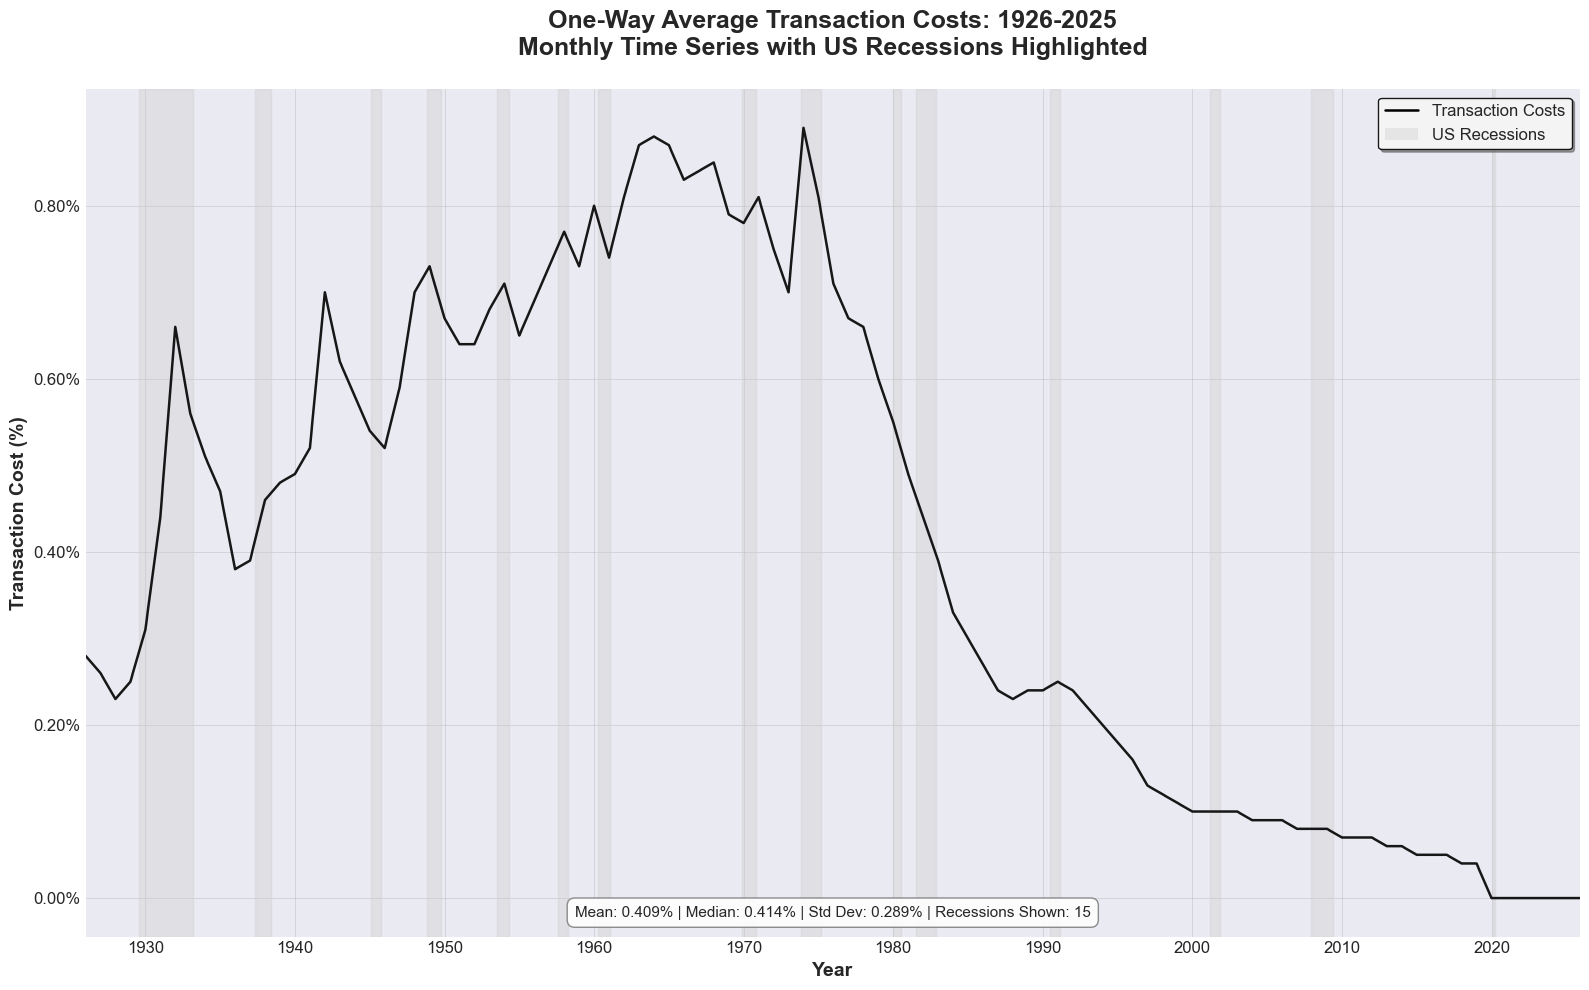


Recessions highlighted in the plot (15 total):
 1. Great Depression (1929-1933)
 2. Recession (1937-1938)
 3. Recession (1945)
 4. Recession (1948-1949)
 5. Recession (1953-1954)
 6. Recession (1957-1958)
 7. Recession (1960-1961)
 8. Recession (1969-1970)
 9. Recession (1973-1975)
10. Recession (1980)
11. Recession (1981-1982)
12. Recession (1990-1991)
13. Recession (2001)
14. Great Recession (2007-2009)
15. COVID Recession (2020)

TRANSACTION COSTS ANALYSIS COMPLETE
File saved: results/plots/transaction_costs_all_recessions_academic.png


In [ ]:
# ============================================================================
# TRANSACTION COSTS TIME SERIES VISUALIZATION - ALL RECESSIONS
# ============================================================================
"""
Visualization of one-way average percentage transaction costs
from 1926 to 2025 with all major US recessions highlighted.
"""

print("\n" + "=" * 80)
print("TRANSACTION COSTS TIME SERIES ANALYSIS - ALL RECESSIONS")
print("=" * 80)

# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

print("\n[1/2] Loading and preprocessing transaction cost data...")

# Load the commission data
commissions = pd.read_csv("Datasets/Commissions_monthly.csv", delimiter=',')

# Convert date column to datetime
commissions['date'] = pd.to_datetime(commissions['date'])

# Convert commission to percentage for better readability
commissions['commission_pct'] = commissions['commission'] * 100

# Sort by date to ensure proper time series
commissions = commissions.sort_values('date').reset_index(drop=True)

# Display basic statistics
print(f"   ✓ Loaded {len(commissions):,} monthly observations")
print(f"   ✓ Time period: {commissions['date'].min().strftime('%Y-%m')} to {commissions['date'].max().strftime('%Y-%m')}")
print(f"   ✓ Commission range: {commissions['commission_pct'].min():.3f}% to {commissions['commission_pct'].max():.3f}%")

# Calculate summary statistics
mean_cost = commissions['commission_pct'].mean()
median_cost = commissions['commission_pct'].median()
std_cost = commissions['commission_pct'].std()

print(f"\nSummary Statistics:")
print(f"   Mean commission: {mean_cost:.3f}%")
print(f"   Median commission: {median_cost:.3f}%")
print(f"   Standard deviation: {std_cost:.3f}%")

# ============================================================================
# MAIN TIME SERIES PLOT WITH ALL RECESSIONS
# ============================================================================

print("\n[2/2] Creating academic-quality time series plot with all recessions...")

# Create figure with academic specifications
fig, ax = plt.subplots(figsize=(16, 10))

# Define all major US recessions/depressions from 1926-2025
recessions = [
    ('1929-08-01', '1933-03-01', 'Great Depression'),
    ('1937-05-01', '1938-06-01', 'Recession'),
    ('1945-02-01', '1945-10-01', 'Recession'),
    ('1948-11-01', '1949-10-01', 'Recession'),
    ('1953-07-01', '1954-05-01', 'Recession'),
    ('1957-08-01', '1958-04-01', 'Recession'),
    ('1960-04-01', '1961-02-01', 'Recession'),
    ('1969-12-01', '1970-11-01', 'Recession'),
    ('1973-11-01', '1975-03-01', 'Recession'),
    ('1980-01-01', '1980-07-01', 'Recession'),
    ('1981-07-01', '1982-11-01', 'Recession'),
    ('1990-07-01', '1991-03-01', 'Recession'),
    ('2001-03-01', '2001-11-01', 'Recession'),
    ('2007-12-01', '2009-06-01', 'Great Recession'),
    ('2020-02-01', '2020-04-01', 'COVID Recession')
]

# Add shaded regions for all recessions (same color for all)
recession_color = '#D0D0D0'  # Light gray for all recessions
recession_alpha = 0.4

recession_periods_added = []
for start_date, end_date, label in recessions:
    try:
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)
        # Only add if the period overlaps with our data
        if start <= commissions['date'].max() and end >= commissions['date'].min():
            ax.axvspan(start, end, alpha=recession_alpha, color=recession_color)
            recession_periods_added.append(label)
    except:
        continue

# Main time series line
ax.plot(commissions['date'], commissions['commission_pct'], 
        color='black', linewidth=1.8, alpha=0.9, label='Transaction Costs')

# ============================================================================
# FORMATTING FOR ACADEMIC PUBLICATION
# ============================================================================

# Title and labels
ax.set_title('One-Way Average Transaction Costs: 1926-2025\n' + 
             'Monthly Time Series with US Recessions Highlighted', 
             fontsize=18, fontweight='bold', pad=25)
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Transaction Cost (%)', fontsize=14, fontweight='bold')

# X-axis formatting for long time series
ax.xaxis.set_major_locator(mdates.YearLocator(10))  # Major ticks every 10 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(5))   # Minor ticks every 5 years

# Y-axis formatting
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}%'))

# Grid for readability (academic style)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color='gray')
ax.set_axisbelow(True)  # Grid behind the plot

# Create custom legend with recession explanation
from matplotlib.patches import Patch
legend_elements = [
    plt.Line2D([0], [0], color='black', linewidth=1.8, label='Transaction Costs'),
    Patch(facecolor=recession_color, alpha=recession_alpha, label='US Recessions')
]

legend = ax.legend(handles=legend_elements, loc='upper right', fontsize=12, frameon=True, 
                  fancybox=True, shadow=True, framealpha=0.9,
                  edgecolor='black', facecolor='white')
legend.get_frame().set_linewidth(1.0)

# Enhance tick formatting
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Add subtitle with key statistics
subtitle_text = f'Mean: {mean_cost:.3f}% | Median: {median_cost:.3f}% | Std Dev: {std_cost:.3f}% | Recessions Shown: {len(recession_periods_added)}'
ax.text(0.5, 0.02, subtitle_text, transform=ax.transAxes, 
        ha='center', va='bottom', fontsize=11, 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))

# Set axis limits to better show the data
ax.set_xlim(commissions['date'].min(), commissions['date'].max())

# Tight layout for publication
plt.tight_layout()

# Save high-resolution version for publication
plt.savefig('results/plots/transaction_costs_all_recessions_academic.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print summary of recessions included
print(f"\nRecessions highlighted in the plot ({len(recession_periods_added)} total):")
print("=" * 60)
recession_details = []
for start_date, end_date, label in recessions:
    try:
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)
        # Only add if the period overlaps with our data and was actually added
        if start <= commissions['date'].max() and end >= commissions['date'].min() and label in recession_periods_added:
            start_year = start.year
            end_year = end.year
            if start_year == end_year:
                year_range = f"{start_year}"
            else:
                year_range = f"{start_year}-{end_year}"
            recession_details.append(f"{label} ({year_range})")
    except:
        continue

for i, details in enumerate(recession_details, 1):
    print(f"{i:2d}. {details}")

print("\n" + "=" * 80)
print("TRANSACTION COSTS ANALYSIS COMPLETE")
print("File saved: results/plots/transaction_costs_all_recessions_academic.png")
print("=" * 80)

# ============================================================================
# CRSP DATA EXTRACTION AND PREPROCESSING FOR STRATEGY ANALYSIS
# ============================================================================

In [ ]:
"""
CRSP Data Processing Pipeline

This module implements a comprehensive data extraction and preprocessing pipeline
for CRSP (Center for Research in Security Prices) equity data. The pipeline
consists of two main phases:

Phase I: Data Extraction from WRDS (Wharton Research Data Services)
- Extracts monthly panel data including returns, prices, volumes, and market capitalization
- Retrieves bid-ask spread data for liquidity analysis
- Collects market index returns for benchmark comparisons

Phase II: Data Preprocessing
- Implements delisting adjustments following Shumway (1997)
- Computes bid-ask spreads using quoted prices
- Handles missing data through adjacent-day interpolation

References:
- Shumway, T. (1997). The delisting bias in CRSP data. Journal of Finance, 52(1), 327-340.
- CRSP Data Descriptions Guide, Center for Research in Security Prices

Output Files:
- crsp_monthly_raw.csv: Raw monthly panel data (~2 million observations)
- crsp_index_raw.csv: Market index returns data
"""

# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

START_DATE = "1935-01-01"
END_DATE = "2025-05-31"
OUTPUT_DIR = "Datasets"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define output file paths
MONTHLY_RAW_PATH = os.path.join(OUTPUT_DIR, "crsp_monthly_raw.csv")
INDEX_RAW_PATH = os.path.join(OUTPUT_DIR, "crsp_index_raw.csv")

print("=" * 80)
print("CRSP DATA PROCESSING PIPELINE")
print("=" * 80)
print(f"Sample Period: {START_DATE} to {END_DATE}")
print(f"Output Directory: {OUTPUT_DIR}")
print("=" * 80)

# ============================================================================
# PHASE I: DATA EXTRACTION FROM WRDS
# ============================================================================

print("\nPHASE I: EXTRACTING DATA FROM WRDS DATABASE")
print("-" * 80)
print("Note: This query processes approximately 2 million observations")
print("Expected execution time: 5-1 5 minutes depending on server load")

# ============================================================================
# WRDS CONNECTION
# ============================================================================

print("\n Establishing WRDS connection...")
conn = wrds.Connection()  # Will prompt for credentials if not cached
print("   ✓ Connected to WRDS")

start_time = time.time()

monthly_sql = f"""
/* ───────────────────────────────────────────────────────────────
   SQL QUERY FOR CRSP MONTHLY PANEL DATA EXTRACTION
   
   This query implements the following data selection criteria:
   - Security types: Common shares only (SHRCD 10-11)
   - Exchanges: NYSE, AMEX, and NASDAQ (EXCHCD -2 to 2)
   - Returns: Include delisting returns (MTHRET from MSF_V2)
   - Liquidity: End-of-month bid-ask spreads with adjacent-day fallbacks
   ───────────────────────────────────────────────────────────────*/
   
WITH params AS (
    SELECT DATE '{START_DATE}' AS start_date,
           DATE '{END_DATE}'   AS end_date
),

/* Step 0: Define universe of eligible securities */
names AS (
    SELECT permno, permco, exchcd, shrcd,
           namedt,
           COALESCE(nameenddt, DATE '{END_DATE}') AS nameenddt
    FROM   crsp.stocknames
    WHERE  shrcd BETWEEN 10 AND 11   -- Common shares only
      AND  exchcd BETWEEN -2 AND 2   -- Major US exchanges
),

/* Step 1: Extract monthly data with delisting-adjusted returns */
msf_base AS (
    SELECT m.permno,
           n.permco,
           m.mthcaldt              AS date,
           m.mthret                AS ret,
           m.mthvol                AS vol,
           m.mthprc                AS prc,
           m.shrout,
           m.mthcap                AS mktcap
    FROM   crsp.msf_v2   m
    JOIN   names         n USING (permno)
    JOIN   params        p ON m.mthcaldt BETWEEN p.start_date AND p.end_date
    WHERE  m.mthcaldt BETWEEN n.namedt AND n.nameenddt
),

/* Step 2: Extract daily bid-ask quotes for liquidity measurement */
daily_quotes AS (
    SELECT d.permno,
           d.dlycaldt                               AS caldt,
           d.dlybid                                 AS bid_eom,
           d.dlyask                                 AS ask_eom,
           LAG(d.dlybid) OVER (PARTITION BY d.permno ORDER BY d.dlycaldt) AS prev_bid,
           LAG(d.dlyask) OVER (PARTITION BY d.permno ORDER BY d.dlycaldt) AS prev_ask,
           LEAD(d.dlybid) OVER (PARTITION BY d.permno ORDER BY d.dlycaldt) AS next_bid,
           LEAD(d.dlyask) OVER (PARTITION BY d.permno ORDER BY d.dlycaldt) AS next_ask
    FROM   crsp.dsf_v2  d
    JOIN   names        n USING (permno)
    JOIN   params       p ON d.dlycaldt BETWEEN p.start_date AND p.end_date
    WHERE  d.dlycaldt BETWEEN n.namedt AND n.nameenddt
),

/* Step 3: Extract market index returns for benchmarking */
vw_index AS (
    SELECT date AS idx_date, vwretd, ewretd
    FROM   crsp.msi
    JOIN   params p ON date BETWEEN p.start_date AND p.end_date
)

/* Step 4: Merge all components into final dataset */
SELECT  m.*,
        q.bid_eom,
        q.ask_eom,
        q.prev_bid,
        q.prev_ask,
        q.next_bid,
        q.next_ask,
        i.vwretd,
        i.ewretd
FROM    msf_base           m
LEFT    JOIN daily_quotes  q ON q.permno = m.permno
                           AND q.caldt  = m.date
LEFT    JOIN vw_index     i ON i.idx_date = m.date
ORDER   BY m.permno, m.date;
"""

# Execute query on WRDS server
panel = conn.raw_sql(monthly_sql)

elapsed_time = time.time() - start_time
print(f"\nData extraction completed successfully:")
print(f"  - Total observations: {len(panel):,}")
print(f"  - Execution time: {elapsed_time:.1f} seconds")

# Save extracted data to disk
print("\nSaving extracted data to local files...")
panel.to_csv(MONTHLY_RAW_PATH, index=False)
print(f"  - Monthly panel data saved to: {MONTHLY_RAW_PATH}")
print(f"  - File size: {os.path.getsize(MONTHLY_RAW_PATH) / 1024 / 1024:.1f} MB")

# Extract and save index data separately
index_columns = ['date', 'vwretd', 'ewretd']
crsp_index = (panel[index_columns]
                   .drop_duplicates()
                   .sort_values('date')
                   .reset_index(drop=True))
crsp_index.to_csv(INDEX_RAW_PATH, index=False)
print(f"  - Index data saved to: {INDEX_RAW_PATH}")
print(f"  - File size: {os.path.getsize(INDEX_RAW_PATH) / 1024 / 1024:.1f} MB")

# ============================================================================
# DATA EXTRACTION SUMMARY STATISTICS
# ============================================================================

print("\n" + "=" * 80)
print("DATA EXTRACTION SUMMARY STATISTICS")
print("=" * 80)

# Monthly panel data characteristics
print("\nMonthly Panel Data Characteristics:")
print(f"  Total observations:     {len(panel):,}")
print(f"  Sample period:          {panel['date'].min()} to {panel['date'].max()}")
print(f"  Unique securities:      {panel['permno'].nunique():,}")

# Verify data integrity
key_cols = ['permno', 'date', 'ret', 'prc', 'vol', 'shrout', 'mktcap', 'vwretd']
missing_cols = [col for col in key_cols if col not in panel.columns]
if missing_cols:
    print(f"  WARNING: Missing columns: {missing_cols}")
else:
    print("  Data integrity check: PASSED")

# Index data characteristics
print(f"\nMarket Index Data Characteristics:")
print(f"  Total months:           {len(crsp_index):,}")
print(f"  Sample period:          {crsp_index['date'].min()} to {crsp_index['date'].max()}")

# Close database connection
conn.close()
print("\nDatabase connection closed successfully")

In [9]:
# ============================================================================
# SETUP AND DATA PREPARATION
# ============================================================================

# --------------------------------------------------------------------
# Step 1: Load Extracted Data
# --------------------------------------------------------------------
print("\nLoading extracted CRSP data files...")

crsp_stock_data = pd.read_csv("Datasets/crsp_monthly_raw.csv")
crsp_index_data = pd.read_csv("Datasets/crsp_index_raw.csv")

print(f"  - Loaded {len(crsp_stock_data):,} stock-month observations")

# --------------------------------------------------------------------
# Step 2: Calculate Bid-Ask Half-Spreads for Transaction Cost Analysis
# --------------------------------------------------------------------
print("\nComputing bid-ask half-spreads from quoted prices...")
print("  Note: Half-spread = 0.5 × (Ask - Bid) / Midpoint")

# Calculate half-spread as percentage of midpoint
# This represents the one-way transaction cost for immediate execution
crsp_stock_data['half_spread_pct'] = 0.5 * (crsp_stock_data['ask_eom'] - crsp_stock_data['bid_eom']) / \
                        ((crsp_stock_data['ask_eom'] + crsp_stock_data['bid_eom']) / 2)

crsp_stock_data['next_half_spread_pct'] = 0.5 * (crsp_stock_data['next_ask'] - crsp_stock_data['next_bid']) / \
                        ((crsp_stock_data['next_ask'] + crsp_stock_data['next_bid']) / 2)

crsp_stock_data['prev_half_spread_pct'] = 0.5 * (crsp_stock_data['prev_ask'] - crsp_stock_data['prev_bid']) / \
                        ((crsp_stock_data['prev_ask'] + crsp_stock_data['prev_bid']) / 2)

# Implement hierarchical imputation for missing spreads
# Priority: (1) End-of-month, (2) Average of adjacent days, (3) Previous day, (4) Next day
crsp_stock_data['half_spread'] = np.where(
    crsp_stock_data['half_spread_pct'].notna(),
    crsp_stock_data['half_spread_pct'],
    np.where(
        crsp_stock_data['prev_half_spread_pct'].notna() & crsp_stock_data['next_half_spread_pct'].notna(),
        (crsp_stock_data['prev_half_spread_pct'] + crsp_stock_data['next_half_spread_pct']) / 2,
        np.where(
            crsp_stock_data['prev_half_spread_pct'].notna(),
            crsp_stock_data['prev_half_spread_pct'],
            np.where(
                crsp_stock_data['next_half_spread_pct'].notna(),
                crsp_stock_data['next_half_spread_pct'],
                np.nan
            )
        )
    )
)

# Report spread calculation statistics
n_true_spreads = crsp_stock_data['half_spread_pct'].notna().sum()
print(f"\n  Spread Calculation Summary:")
print(f"    - End-of-month spreads computed: {n_true_spreads:,}")

n_true_spreads = crsp_stock_data['next_half_spread_pct'].notna().sum()
print(f"    - Next-day spreads available: {n_true_spreads:,}")

n_true_spreads = crsp_stock_data['prev_half_spread_pct'].notna().sum()
print(f"    - Previous-day spreads available: {n_true_spreads:,}")

n_true_spreads = crsp_stock_data['half_spread'].notna().sum()
print(f"    - Total spreads after imputation: {n_true_spreads:,}")

print("\n" + "=" * 80)
print("DATA PREPROCESSING COMPLETED")
print("=" * 80)

crsp_stock_data.loc[crsp_stock_data['ret']<=-1, 'ret'] = -0.9999
crsp_stock_data['logret'] = np.log1p(crsp_stock_data['ret'])
crsp_stock_data = crsp_stock_data.drop(
    [
        'bid_eom', 'ask_eom', 
        'prev_bid', 'prev_ask', 
        'next_bid', 'next_ask',
        'half_spread_pct', 'next_half_spread_pct', 'prev_half_spread_pct',
        'vol', 'prc', 'shrout'
    ],
    axis=1
)

commissions = (pd.read_csv("Datasets/Commissions_monthly.csv", delimiter=','))
commissions['date'] = pd.to_datetime(commissions['date'])
commissions['merge_date'] = commissions['date'].dt.to_period('M').astype(str)
comm_map = commissions.set_index('merge_date')['commission']

# Prepare market state map
market_state = compute_market_state(crsp_index_data, lags=24, column='vwretd', date_column="date")
market_state['merge_date'] = market_state['date'].dt.to_period('M').astype(str)
market_state_map = market_state.set_index('merge_date')['market_state'].to_dict()

print("Data preparation complete!")
print(f"Total observations: {len(crsp_stock_data):,}")
print(f"Date range: {crsp_stock_data['date'].min()} to {crsp_stock_data['date'].max()}")
print(f"Unique stocks: {crsp_stock_data['permno'].nunique():,}")


Loading extracted CRSP data files...
  - Loaded 1,852,275 stock-month observations

Computing bid-ask half-spreads from quoted prices...
  Note: Half-spread = 0.5 × (Ask - Bid) / Midpoint

  Spread Calculation Summary:
    - End-of-month spreads computed: 815,293
    - Next-day spreads available: 816,736
    - Previous-day spreads available: 816,032
    - Total spreads after imputation: 905,009

DATA PREPROCESSING COMPLETED
Data preparation complete!
Total observations: 1,852,275
Date range: 1935-01-31 to 2024-12-31
Unique stocks: 10,304


# ============================================================================
# ANALYSIS 1 - ORIGINAL MOMENTUM STRATEGY WITHOUT COSTS
# ============================================================================

ANALYSIS 1: ORIGINAL MOMENTUM STRATEGY WITHOUT COSTS

IMPLEMENTING MOMENTUM STRATEGY WITH MARKET CAP CONSTRAINTS
Parameters: J=9, K=3, LIQ=1, MKT_CAP=1

[1/8] Merging market capitalization data...
   ✓ Market cap data available for 1,784,979 observations

[2/8] Computing holding period (3-month) spreads...

[3/8] Calculating 9-month formation period returns...

[4/8] Applying market cap (≤100%) and liquidity filters...

[5/8] Forming momentum deciles within size segment...
   ✓ Average stocks per decile:
      Decile  1:  159.8 stocks
      Decile  2:  159.2 stocks
      Decile  3:  159.2 stocks
      Decile  4:  159.2 stocks
      Decile  5:  159.4 stocks
      Decile  6:  159.0 stocks
      Decile  7:  159.1 stocks
      Decile  8:  159.3 stocks
      Decile  9:  159.1 stocks
      Decile 10:  159.6 stocks

[6/8] Creating 3-month holding period calendar...

[7/8] Merging with returns data...
   ✓ Created 5,063,023 stock-month holding observations

[8/8] Adding transaction costs and m

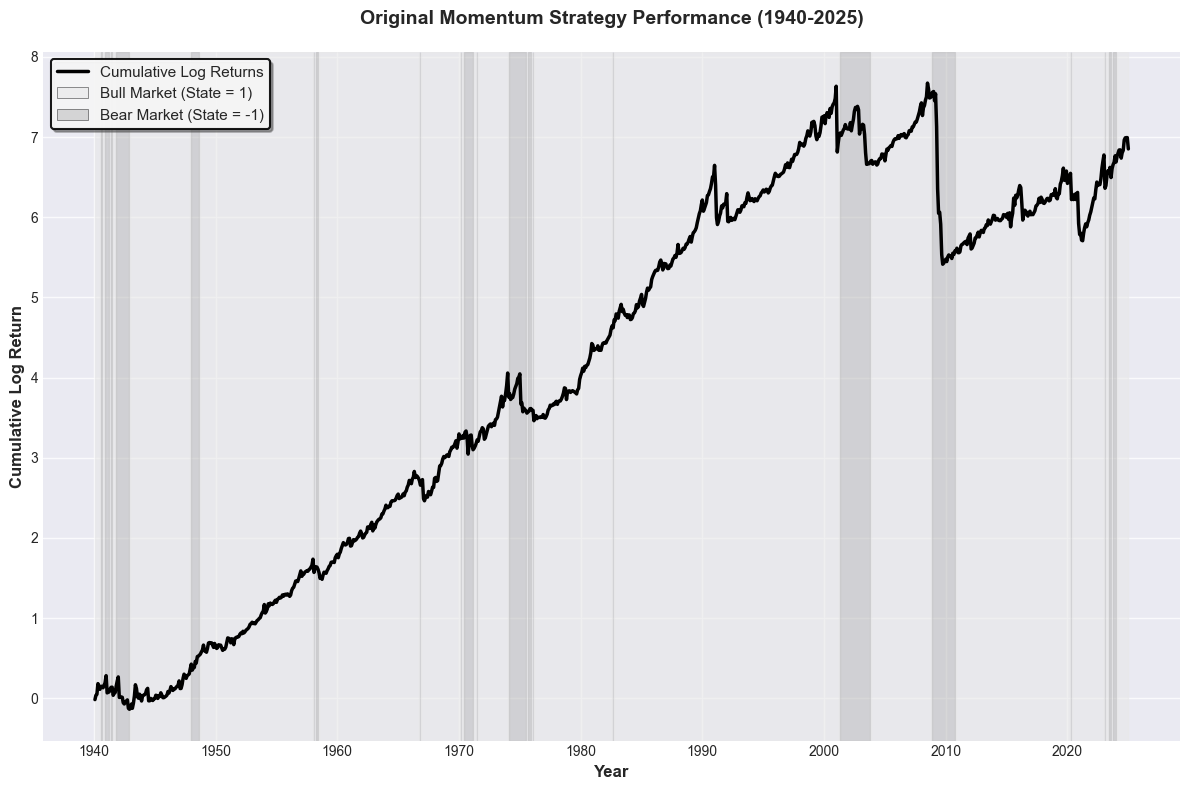

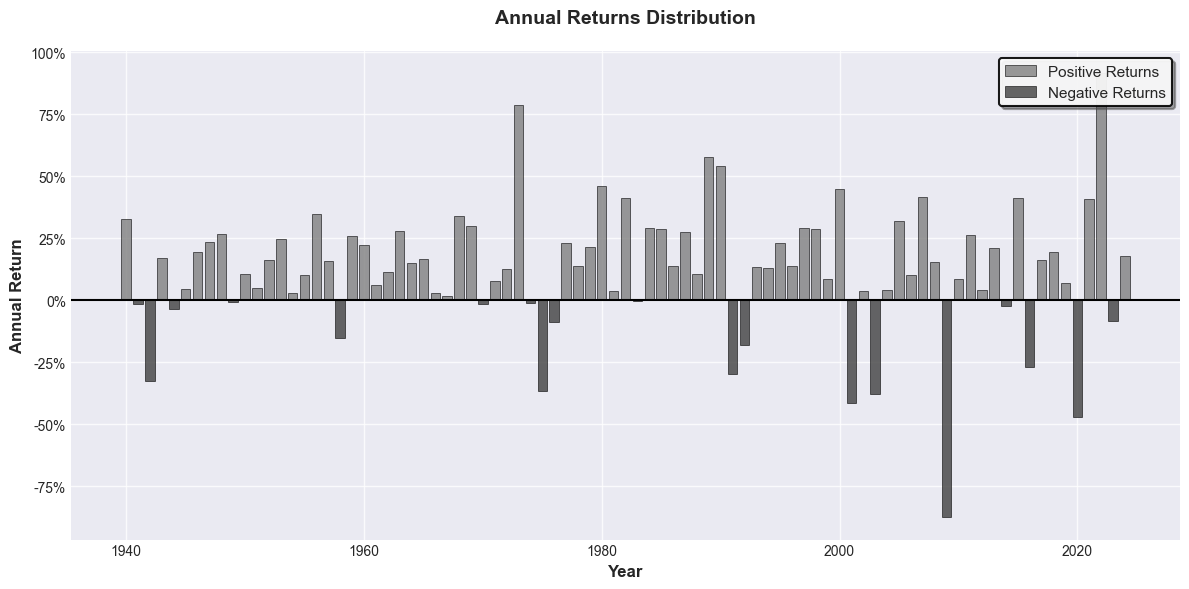


Computing 20-year rolling window statistics...


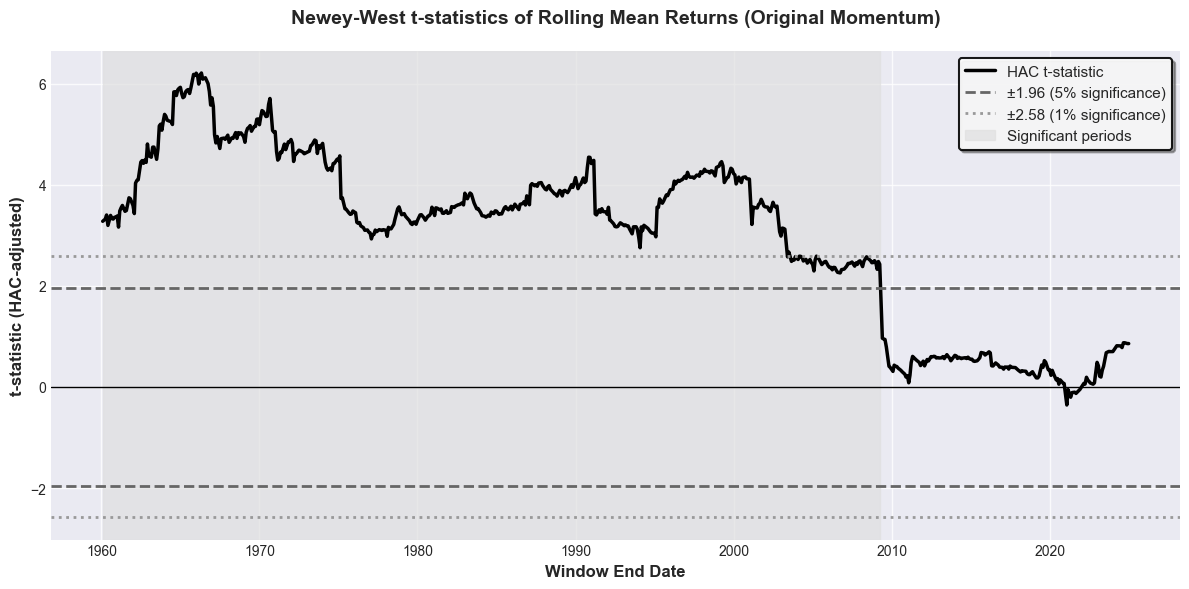

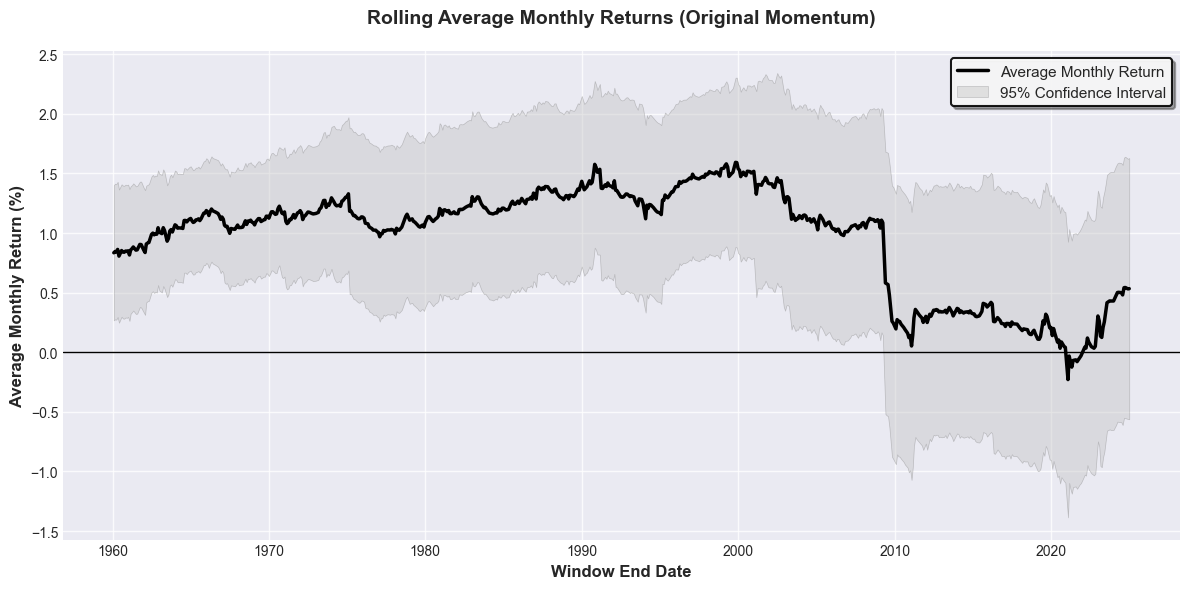

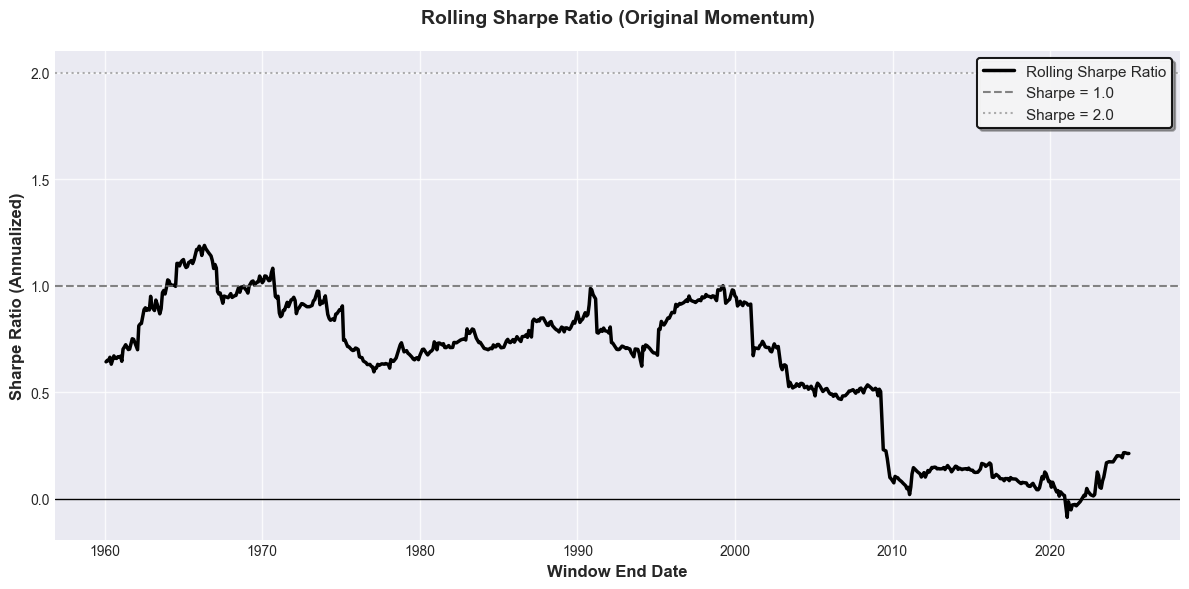

Generated academic plots:
  - Individual t-stat plot: results/plots/original_momentum_rolling_window_tstat_academic.png
  - Individual returns plot: results/plots/original_momentum_rolling_window_returns_academic.png
  - Individual Sharpe ratio plot: results/plots/original_momentum_rolling_window_sharpe_academic.png


In [10]:
"""
Analysis 1: Traditional Momentum Strategy (Jegadeesh & Titman, 1993)
Without transaction costs - Using RET_S0
Academic paper formatting with grayscale plots
"""
print("=" * 80)
print("ANALYSIS 1: ORIGINAL MOMENTUM STRATEGY WITHOUT COSTS")
print("=" * 80)

# Run momentum strategy
port_original, state_map = run_momentum_strategy(
    crsp_stock_data, 
    crsp_index_data, 
    comm_map,
    J=9, 
    K=3, 
    LIQ_CUTOFF=1,
    MKT_CAP_CUTOFF=1,
    market_state_lag=24,
    market_state_column='vwretd',
    transactional_framework=False,
    equal_comparision=False
)

# Analyze performance
analysis_original = analyze_momentum_portfolio(
    port_original, 
    state_map,
    start_date='1940-01-01',
    end_date='2025-04-30',
    return_column='RET_S0',
    K=3
)

# Print summary
print_portfolio_summary(analysis_original, "Original Momentum (No Costs)")

# ============================================================================
# PLOT 1: MOMENTUM STRATEGY PERFORMANCE (SEPARATE FIGURE)
# ============================================================================
fig1, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Prepare data
decile_ret = analysis_original['decile_ret']
decile_ret.index = pd.to_datetime(decile_ret.index)
decile_ret['state_change'] = decile_ret['market_state'].ne(decile_ret['market_state'].shift()).cumsum()

# Create colored background based on market state (grayscale)
for (change_group, state), group in decile_ret.groupby(['state_change', 'market_state']):
    if len(group) > 0:
        start_date = group.index[0]
        end_date = group.index[-1]
        
        # Set grayscale color based on market state
        color = '#E8E8E8' if state == 1 else '#C0C0C0'  # Light gray for bull, darker gray for bear
        
        # Add colored background
        ax1.axvspan(start_date, end_date, alpha=0.6, color=color)

# Plot the cumulative returns line
ax1.plot(decile_ret.index, decile_ret['cum_log_long_short'], 
         color='black', linewidth=2.5, label='Cumulative Log Returns')

# Customize the plot
ax1.set_title('Original Momentum Strategy Performance (1940-2025)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative Log Return', fontsize=12, fontweight='bold')

# Create custom legend with market state indicators and border
legend_elements = [
    plt.Line2D([0], [0], color='black', lw=2.5, label='Cumulative Log Returns'),
    Patch(facecolor='#E8E8E8', alpha=0.6, label='Bull Market (State = 1)', edgecolor='black', linewidth=0.5),
    Patch(facecolor='#C0C0C0', alpha=0.6, label='Bear Market (State = -1)', edgecolor='black', linewidth=0.5)
]
legend = ax1.legend(handles=legend_elements, loc='upper left', fontsize=11, 
                   frameon=True, fancybox=True, shadow=True, framealpha=0.9,
                   edgecolor='black', facecolor='white')
legend.get_frame().set_linewidth(1.5)

# Format dates
ax1.xaxis.set_major_locator(mdates.YearLocator(10))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='both', which='major', labelsize=10)

# Add grid
ax1.grid(True, alpha=0.8, linestyle='-', linewidth=1)

# Adjust layout and save
plt.tight_layout()
plt.savefig('results/plots/momentum_strategy_performance_academic.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# PLOT 2: ANNUAL RETURNS DISTRIBUTION (SEPARATE FIGURE)
# ============================================================================
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 6))

# Calculate annual returns
annual_returns = decile_ret['long_short'].resample('YE').apply(lambda x: (1 + x).prod() - 1)

# Create grayscale colors (positive returns lighter, negative darker)
colors = ['#808080' if x > 0 else '#404040' for x in annual_returns.values]

# Create bar plot
bars = ax2.bar(annual_returns.index.year, annual_returns.values, 
               color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Customize the plot
ax2.set_title('Annual Returns Distribution', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('Annual Return', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5)

# Add legend for positive/negative returns
legend_elements = [
    Patch(facecolor='#808080', alpha=0.8, label='Positive Returns', 
          edgecolor='black', linewidth=0.5),
    Patch(facecolor='#404040', alpha=0.8, label='Negative Returns', 
          edgecolor='black', linewidth=0.5)
]
legend = ax2.legend(handles=legend_elements, loc='upper right', fontsize=11,
                   frameon=True, fancybox=True, shadow=True, framealpha=0.9,
                   edgecolor='black', facecolor='white')
legend.get_frame().set_linewidth(1.5)

# Format y-axis as percentage
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax2.tick_params(axis='both', which='major', labelsize=10)

# Add grid
ax2.grid(True, alpha=0.8, linestyle='-', linewidth=1)

# Adjust layout and save
plt.tight_layout()
plt.savefig('results/plots/annual_returns_distribution_academic.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Use the rolling window analysis functions 
print("\nComputing 20-year rolling window statistics...")
decile_return = decile_ret.copy()
decile_return.reset_index(inplace=True)
window_results = compute_df_t_stat_and_avg_return(decile_return, window_months=240, lags=2, return_col='long_short')
plot_tstat_and_avg_return(window_results, title_suffix="(Original Momentum)", 
                         save_path='results/plots/original_momentum_rolling_window')

# ============================================================================
# ANALYSIS 2 - MARKET STATE STRATEGY DETAILED ANALYSIS
# ============================================================================


ANALYSIS 2: MARKET STATE STRATEGY DETAILED ANALYSIS

--------------------------------------------------------------------------------
ANALYZING PORTFOLIO: RET_S1
--------------------------------------------------------------------------------
Filtering data from 1940-01-01 to 2025-04-30...
   ✓ Selected 4,957,493 observations

Calculating equal-weight portfolio returns...
   ✓ Created long-short portfolio (Winners - Losers)

Calculating performance metrics...

Performing statistical tests...
   ✓ Estimated with 1020 monthly observations
   ✓ Using 2 lags for HAC adjustment

Calculating risk metrics...
   ✓ Computed Sharpe ratio and maximum drawdown

                Market State Strategy (No Costs)                 
                       Performance Summary                       
Average Monthly Return:         1.36%
Monthly Volatility:             6.23%
Annualized Sharpe Ratio:        0.755
Maximum Drawdown:             -63.95%
t-statistic (HAC-adjusted):    6.8953
p-value (two-sided)

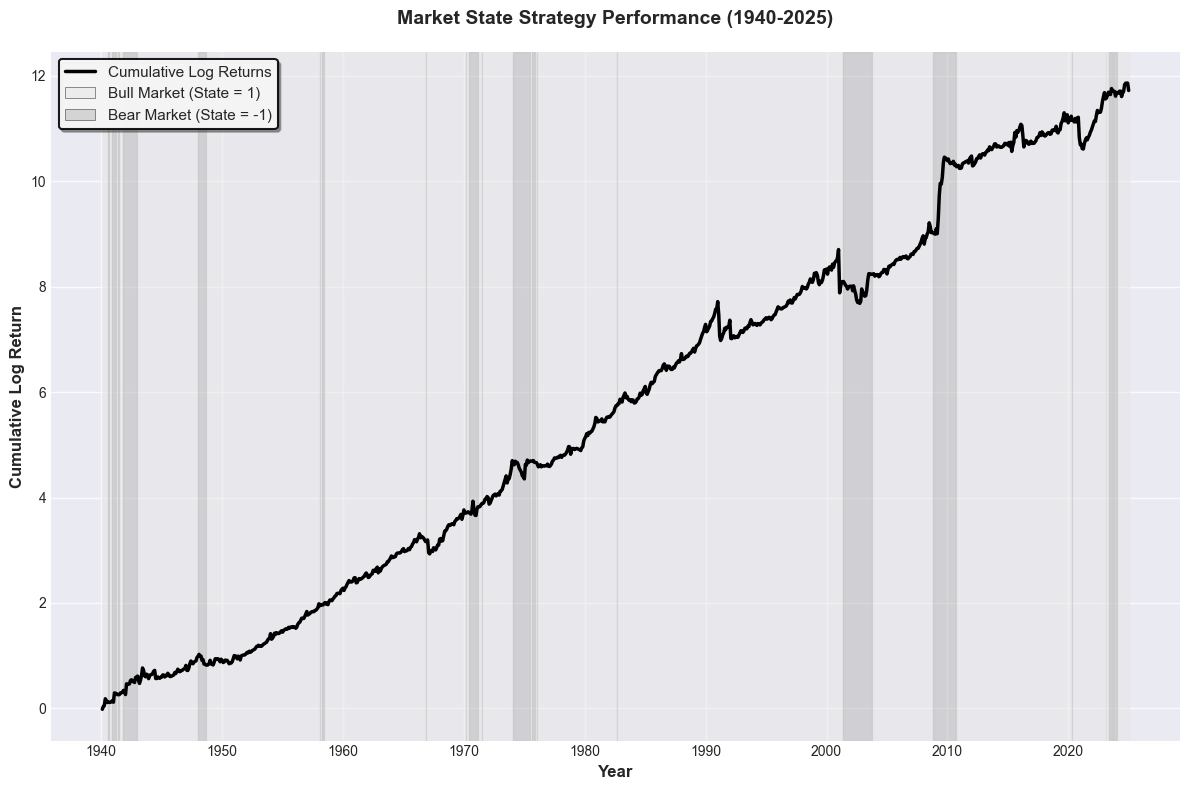

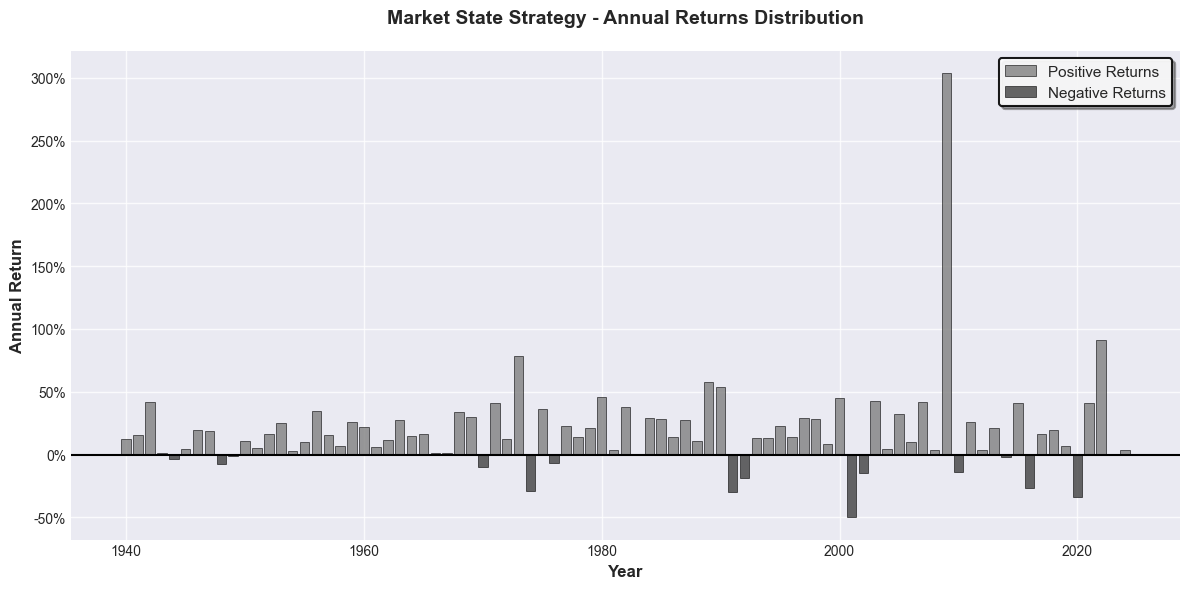


Computing Market State 20-year rolling window statistics...


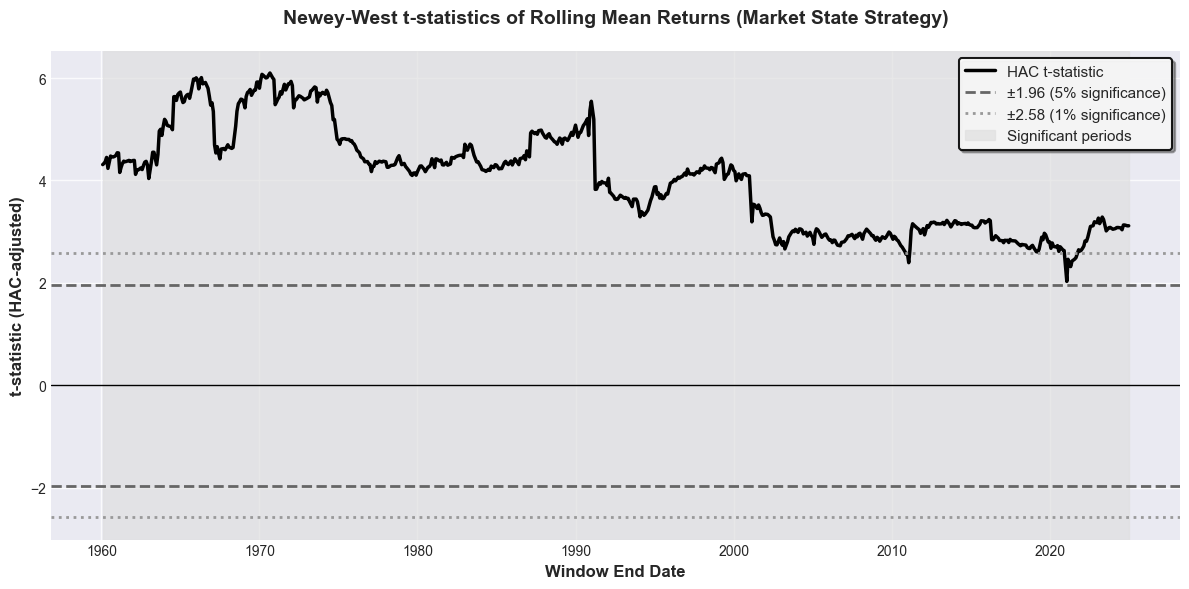

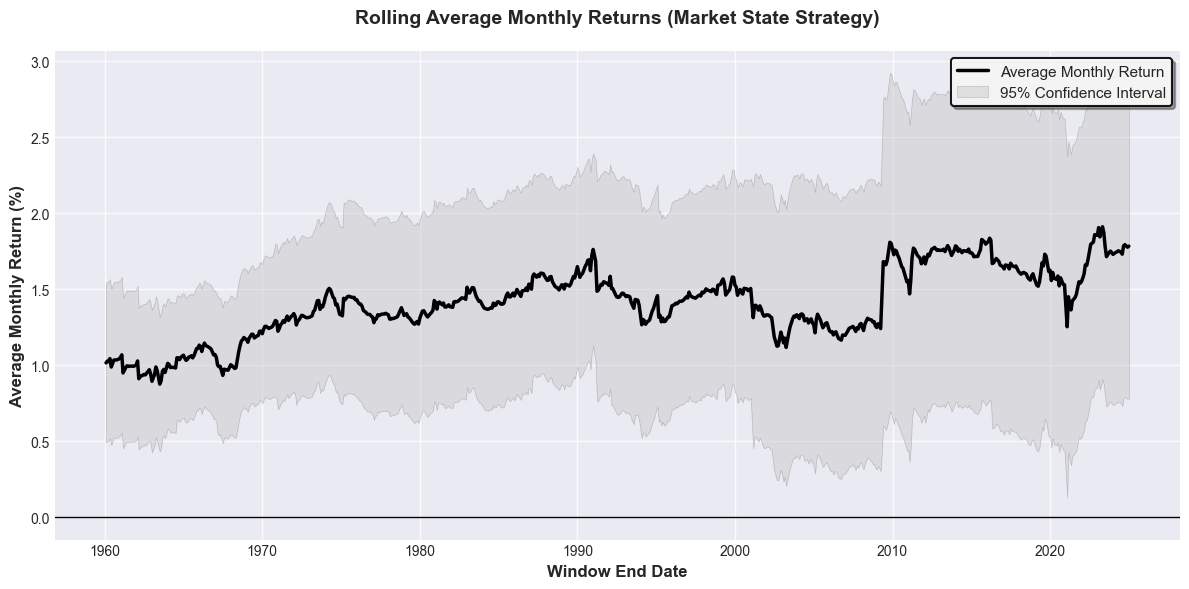

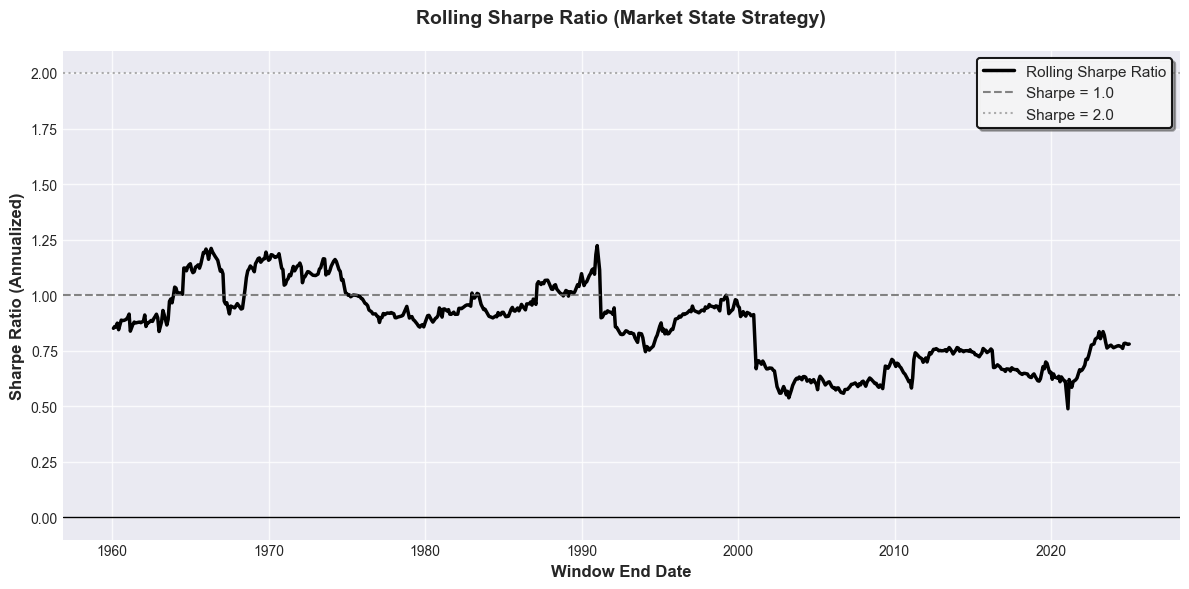

Generated academic plots:
  - Individual t-stat plot: results/plots/market_state_rolling_window_tstat_academic.png
  - Individual returns plot: results/plots/market_state_rolling_window_returns_academic.png
  - Individual Sharpe ratio plot: results/plots/market_state_rolling_window_sharpe_academic.png

ANALYSIS 3: COMPREHENSIVE STRATEGY COMPARISON


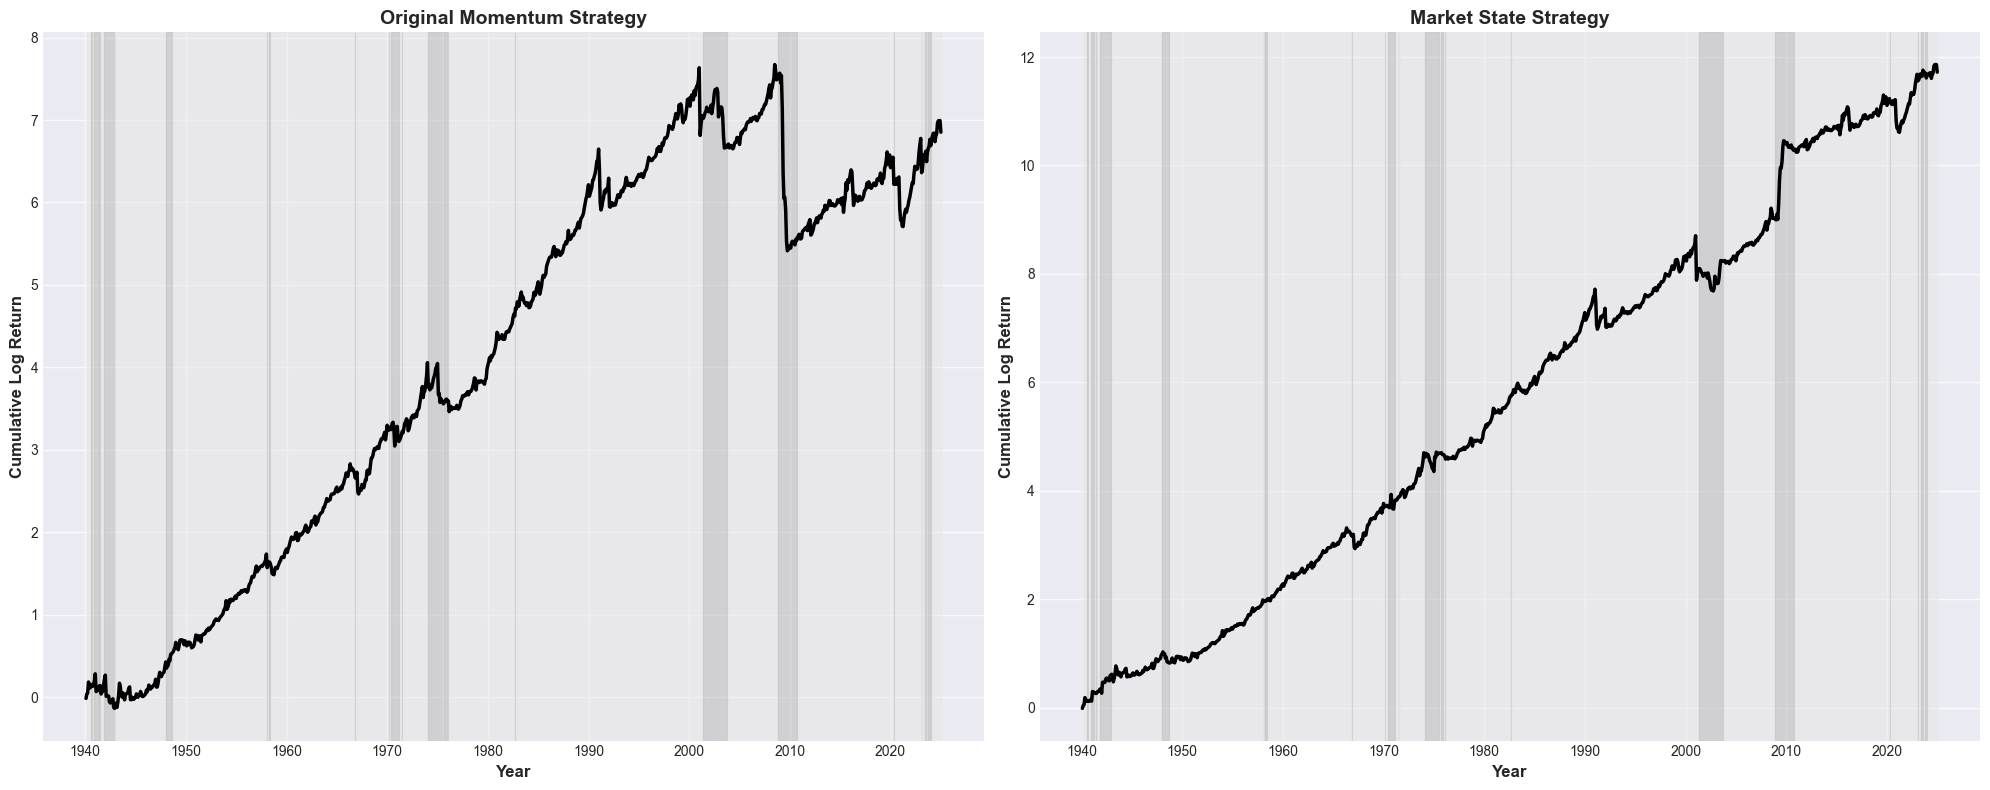

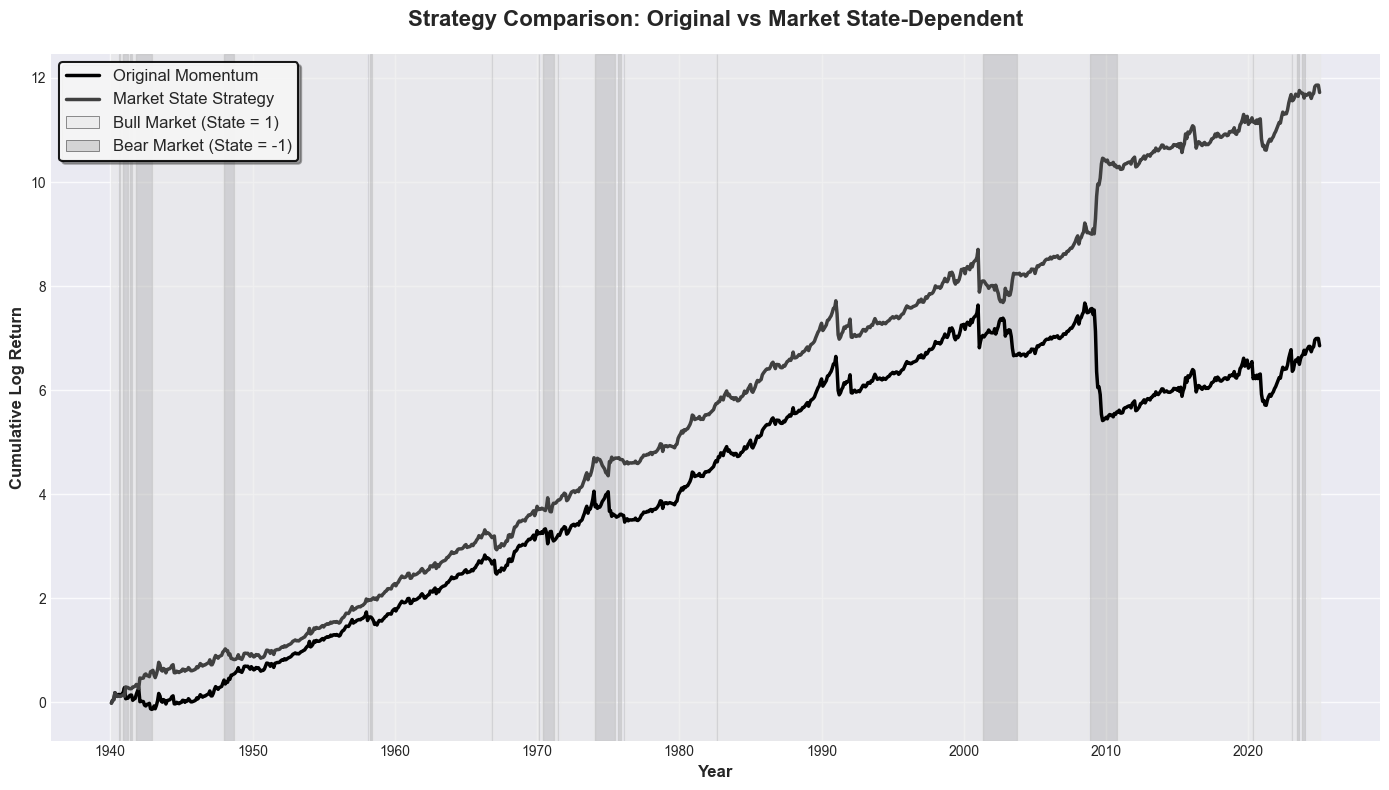


Strategy Comparison (Without Costs):
             Strategy Avg Monthly Return Volatility Sharpe Ratio t-statistic              p-value
    Original Momentum             0.93\%     6.61\%        0.486      4.4457  8.76 \times 10^{-6}
Market State Strategy             1.36\%     6.23\%        0.755      6.8953 5.37 \times 10^{-12}

LaTeX table saved to: results/tables/strategy_comparison_no_costs.tex

Performance Differences (Market State - Original):
Cumulative Log Return Difference: 4.8691
Average Monthly Return Difference: 0.43%
Volatility Difference: -0.38%
Sharpe Ratio Difference: 0.2691

Market State Breakdown:
Market State Strategy - Average return in Bull Markets: 1.33%
Market State Strategy - Average return in Bear Markets: 1.53%
Original Strategy - Average return in Bull Markets: 1.39%
Bull Market Performance Difference: -0.06%
Original Strategy - Average return in Bear Markets: -2.11%
Bear Market Performance Difference: 3.64%

COMPREHENSIVE STRATEGY ANALYSIS COMPLETE
Files sa

In [11]:
"""
Analysis 2: Market State-Dependent Strategy (Comprehensive Analysis)
Without transaction costs - Using RET_S1
Same detailed analysis as original strategy for fair comparison
"""
print("\n" + "=" * 80)
print("ANALYSIS 2: MARKET STATE STRATEGY DETAILED ANALYSIS")
print("=" * 80)

# Analyze market state strategy
analysis_market_state = analyze_momentum_portfolio(
    port_original,  # Same portfolio data, different return column
    state_map,
    start_date='1940-01-01',
    end_date='2025-04-30',
    return_column='RET_S1',
    K=3
)

# Print summary
print_portfolio_summary(analysis_market_state, "Market State Strategy (No Costs)")

# ============================================================================
# PLOT 1: MARKET STATE STRATEGY PERFORMANCE (SEPARATE FIGURE)
# ============================================================================
fig1_ms, ax1_ms = plt.subplots(1, 1, figsize=(12, 8))

# Prepare data
decile_ret_ms = analysis_market_state['decile_ret']
decile_ret_ms.index = pd.to_datetime(decile_ret_ms.index)
decile_ret_ms['state_change'] = decile_ret_ms['market_state'].ne(decile_ret_ms['market_state'].shift()).cumsum()

# Create background based on market state (grayscale)
for (change_group, state), group in decile_ret_ms.groupby(['state_change', 'market_state']):
    if len(group) > 0:
        start_date = group.index[0]
        end_date = group.index[-1]
        
        # Set grayscale color based on market state
        color = '#E8E8E8' if state == 1 else '#C0C0C0'  # Light gray for bull, darker gray for bear
        
        # Add colored background
        ax1_ms.axvspan(start_date, end_date, alpha=0.6, color=color)

# Plot the cumulative returns line
ax1_ms.plot(decile_ret_ms.index, decile_ret_ms['cum_log_long_short'], 
            color='black', linewidth=2.5, label='Cumulative Log Returns')

# Customize the plot
ax1_ms.set_title('Market State Strategy Performance (1940-2025)', 
                 fontsize=14, fontweight='bold', pad=20)
ax1_ms.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1_ms.set_ylabel('Cumulative Log Return', fontsize=12, fontweight='bold')

# Create custom legend with market state indicators and border
from matplotlib.patches import Patch
legend_elements = [
    plt.Line2D([0], [0], color='black', lw=2.5, label='Cumulative Log Returns'),
    Patch(facecolor='#E8E8E8', alpha=0.6, label='Bull Market (State = 1)', edgecolor='black', linewidth=0.5),
    Patch(facecolor='#C0C0C0', alpha=0.6, label='Bear Market (State = -1)', edgecolor='black', linewidth=0.5)
]
legend = ax1_ms.legend(handles=legend_elements, loc='upper left', fontsize=11, 
                      frameon=True, fancybox=True, shadow=True, framealpha=0.9,
                      edgecolor='black', facecolor='white')
legend.get_frame().set_linewidth(1.5)

# Format dates
ax1_ms.xaxis.set_major_locator(mdates.YearLocator(10))
ax1_ms.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1_ms.tick_params(axis='both', which='major', labelsize=10)

# Add grid
ax1_ms.grid(True, alpha=0.8, linestyle='-', linewidth=1)

# Adjust layout and save
plt.tight_layout()
plt.savefig('results/plots/market_state_strategy_performance_academic.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# PLOT 2: MARKET STATE ANNUAL RETURNS DISTRIBUTION (SEPARATE FIGURE)
# ============================================================================
fig2_ms, ax2_ms = plt.subplots(1, 1, figsize=(12, 6))

# Calculate annual returns
annual_returns_ms = decile_ret_ms['long_short'].resample('YE').apply(lambda x: (1 + x).prod() - 1)

# Create grayscale colors (positive returns lighter, negative darker)
colors_ms = ['#808080' if x > 0 else '#404040' for x in annual_returns_ms.values]

# Create bar plot
bars_ms = ax2_ms.bar(annual_returns_ms.index.year, annual_returns_ms.values, 
                     color=colors_ms, alpha=0.8, edgecolor='black', linewidth=0.5)

# Customize the plot
ax2_ms.set_title('Market State Strategy - Annual Returns Distribution', fontsize=14, fontweight='bold', pad=20)
ax2_ms.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2_ms.set_ylabel('Annual Return', fontsize=12, fontweight='bold')
ax2_ms.axhline(y=0, color='black', linestyle='-', linewidth=1.5)

# Add legend for positive/negative returns
legend_elements = [
    Patch(facecolor='#808080', alpha=0.8, label='Positive Returns', 
          edgecolor='black', linewidth=0.5),
    Patch(facecolor='#404040', alpha=0.8, label='Negative Returns', 
          edgecolor='black', linewidth=0.5)
]
legend = ax2_ms.legend(handles=legend_elements, loc='upper right', fontsize=11,
                      frameon=True, fancybox=True, shadow=True, framealpha=0.9,
                      edgecolor='black', facecolor='white')
legend.get_frame().set_linewidth(1.5)

# Format y-axis as percentage
ax2_ms.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax2_ms.tick_params(axis='both', which='major', labelsize=10)

# Add grid
ax2_ms.grid(True, alpha=0.8, linestyle='-', linewidth=1)

# Adjust layout and save
plt.tight_layout()
plt.savefig('results/plots/market_state_annual_returns_distribution_academic.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# ROLLING WINDOW STATISTICS FOR MARKET STATE STRATEGY
# ============================================================================

# Market State Rolling window analysis with specialized function
print("\nComputing Market State 20-year rolling window statistics...")
decile_return_ms = decile_ret_ms.copy()
decile_return_ms.reset_index(inplace=True)
window_results_ms = compute_df_t_stat_and_avg_return(decile_return_ms, window_months=240, lags=2, return_col='long_short')
plot_tstat_and_avg_return(window_results_ms, title_suffix="(Market State Strategy)", 
                         save_path='results/plots/market_state_rolling_window', window_months=240)

# ============================================================================
# CELL 4: ANALYSIS 3 - COMPREHENSIVE STRATEGY COMPARISON
# ============================================================================
print("\n" + "=" * 80)
print("ANALYSIS 3: COMPREHENSIVE STRATEGY COMPARISON")
print("=" * 80)

# ============================================================================
# LATEX FORMATTING FUNCTIONS
# ============================================================================
def format_percentage_latex(value):
    """Format percentage values for LaTeX with proper escaping"""
    return f"{value*100:.2f}\\%"

def format_scientific_latex(value):
    """Format scientific notation for LaTeX"""
    if value < 0.001:
        return f"{value:.2e}".replace('e-0', ' \\times 10^{-').replace('e-', ' \\times 10^{-') + '}'
    else:
        return f"{value:.4f}"

# ============================================================================
# COMPREHENSIVE COMPARISON PLOTS
# ============================================================================

# Plot 1: Side-by-side Cumulative Returns Comparison
fig_comp1, (ax_comp1, ax_comp2) = plt.subplots(1, 2, figsize=(20, 8))

# Original Strategy Plot
decile_ret = analysis_original['decile_ret']
decile_ret.index = pd.to_datetime(decile_ret.index)
decile_ret['state_change'] = decile_ret['market_state'].ne(decile_ret['market_state'].shift()).cumsum()

# Add market state background for original
for (change_group, state), group in decile_ret.groupby(['state_change', 'market_state']):
    if len(group) > 0:
        start_date = group.index[0]
        end_date = group.index[-1]
        color = '#E8E8E8' if state == 1 else '#C0C0C0'
        ax_comp1.axvspan(start_date, end_date, alpha=0.6, color=color)

ax_comp1.plot(decile_ret.index, decile_ret['cum_log_long_short'], 
              color='black', linewidth=2.5, label='Original Momentum')
ax_comp1.set_title('Original Momentum Strategy', fontsize=14, fontweight='bold')
ax_comp1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax_comp1.set_ylabel('Cumulative Log Return', fontsize=12, fontweight='bold')
ax_comp1.grid(True, alpha=0.8, linewidth=1)

# Market State Strategy Plot
for (change_group, state), group in decile_ret_ms.groupby(['state_change', 'market_state']):
    if len(group) > 0:
        start_date = group.index[0]
        end_date = group.index[-1]
        color = '#E8E8E8' if state == 1 else '#C0C0C0'
        ax_comp2.axvspan(start_date, end_date, alpha=0.6, color=color)

ax_comp2.plot(decile_ret_ms.index, decile_ret_ms['cum_log_long_short'], 
              color='black', linewidth=2.5, label='Market State Strategy')
ax_comp2.set_title('Market State Strategy', fontsize=14, fontweight='bold')
ax_comp2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax_comp2.set_ylabel('Cumulative Log Return', fontsize=12, fontweight='bold')
ax_comp2.grid(True, alpha=0.8, linewidth=1)

plt.tight_layout()
plt.savefig('results/plots/strategies_side_by_side_comparison_academic.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Plot 2: Direct Strategy Comparison on Same Plot
fig_comp3, ax_comp3 = plt.subplots(1, 1, figsize=(14, 8))

# Add market state shading (using market state data)
for (change_group, state), group in decile_ret_ms.groupby(['state_change', 'market_state']):
    if len(group) > 0 and not pd.isna(state):
        start_date = group.index[0]
        end_date = group.index[-1]
        color = '#E8E8E8' if state == 1 else '#C0C0C0'
        ax_comp3.axvspan(start_date, end_date, alpha=0.6, color=color)

# Plot both strategies
ax_comp3.plot(decile_ret.index, decile_ret['cum_log_long_short'],
              label='Original Momentum', color='black', linewidth=2.5)
ax_comp3.plot(decile_ret_ms.index, decile_ret_ms['cum_log_long_short'],
              label='Market State Strategy', color='#404040', linewidth=2.5)

# Customize plot
ax_comp3.set_title('Strategy Comparison: Original vs Market State-Dependent', 
                   fontsize=16, fontweight='bold', pad=20)
ax_comp3.set_xlabel('Year', fontsize=12, fontweight='bold')
ax_comp3.set_ylabel('Cumulative Log Return', fontsize=12, fontweight='bold')

# Enhanced legend with borders and market state indicators
legend_elements = [
    plt.Line2D([0], [0], color='black', lw=2.5, label='Original Momentum'),
    plt.Line2D([0], [0], color='#404040', lw=2.5, label='Market State Strategy'),
    Patch(facecolor='#E8E8E8', alpha=0.6, label='Bull Market (State = 1)', 
          edgecolor='black', linewidth=0.5),
    Patch(facecolor='#C0C0C0', alpha=0.6, label='Bear Market (State = -1)', 
          edgecolor='black', linewidth=0.5)
]

legend = ax_comp3.legend(handles=legend_elements, loc='upper left', fontsize=12, 
                        frameon=True, fancybox=True, shadow=True, framealpha=0.9,
                        edgecolor='black', facecolor='white')
legend.get_frame().set_linewidth(1.5)

ax_comp3.grid(True, alpha=0.8, linewidth=1)
ax_comp3.tick_params(axis='both', which='major', labelsize=10)

# Format dates
ax_comp3.xaxis.set_major_locator(mdates.YearLocator(10))
ax_comp3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig('results/plots/strategies_direct_comparison_academic.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# COMPREHENSIVE COMPARISON TABLE
# ============================================================================

# Create comparison table with LaTeX-safe formatting
comparison_data = {
    'Strategy': ['Original Momentum', 'Market State Strategy'],
    'Avg Monthly Return': [
        format_percentage_latex(analysis_original['avg_monthly_return']),
        format_percentage_latex(analysis_market_state['avg_monthly_return'])
    ],
    'Volatility': [
        format_percentage_latex(analysis_original['monthly_vol']),
        format_percentage_latex(analysis_market_state['monthly_vol'])
    ],
    'Sharpe Ratio': [
        f"{analysis_original['sharpe_ratio']:.3f}",
        f"{analysis_market_state['sharpe_ratio']:.3f}"
    ],
    't-statistic': [
        f"{analysis_original['t_stat']:.4f}",
        f"{analysis_market_state['t_stat']:.4f}"
    ],
    'p-value': [
        format_scientific_latex(analysis_original['p_value']),
        format_scientific_latex(analysis_market_state['p_value'])
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Display table
print("\nStrategy Comparison (Without Costs):")
print(comparison_df.to_string(index=False))

# Save to LaTeX with proper formatting
latex_output = comparison_df.to_latex(
    index=False,
    escape=False,
    column_format='l' + 'c' * (len(comparison_df.columns) - 1),
    caption='Strategy Performance Comparison Without Transaction Costs',
    label='tab:strategy_comparison_no_costs',
    position='htbp'
)

# Additional LaTeX formatting improvements
latex_output = latex_output.replace('\\toprule', '\\hline')
latex_output = latex_output.replace('\\midrule', '\\hline') 
latex_output = latex_output.replace('\\bottomrule', '\\hline')

# Make headers bold
lines = latex_output.split('\n')
for i, line in enumerate(lines):
    if 'Strategy' in line:
        for col in comparison_df.columns:
            lines[i] = lines[i].replace(col, f'\\textbf{{{col}}}')
        break

latex_output = '\n'.join(lines)

# Save the formatted LaTeX table
with open('results/tables/strategy_comparison_no_costs.tex', 'w') as f:
    f.write(latex_output)

print(f"\nLaTeX table saved to: results/tables/strategy_comparison_no_costs.tex")

# ============================================================================
# PERFORMANCE DIFFERENCE ANALYSIS
# ============================================================================

# Calculate performance differences
perf_diff = decile_ret_ms['cum_log_long_short'].iloc[-1] - decile_ret['cum_log_long_short'].iloc[-1]
return_diff = analysis_market_state['avg_monthly_return'] - analysis_original['avg_monthly_return']
vol_diff = analysis_market_state['monthly_vol'] - analysis_original['monthly_vol']
sharpe_diff = analysis_market_state['sharpe_ratio'] - analysis_original['sharpe_ratio']

print(f"\nPerformance Differences (Market State - Original):")
print(f"Cumulative Log Return Difference: {perf_diff:.4f}")
print(f"Average Monthly Return Difference: {return_diff*100:.2f}%")
print(f"Volatility Difference: {vol_diff*100:.2f}%")
print(f"Sharpe Ratio Difference: {sharpe_diff:.4f}")

# Additional analysis: performance by market state
print(f"\nMarket State Breakdown:")
bull_periods = decile_ret_ms[decile_ret_ms['market_state'] == 1]
bear_periods = decile_ret_ms[decile_ret_ms['market_state'] == -1]

if len(bull_periods) > 0:
    bull_return = bull_periods['long_short'].mean()
    print(f"Market State Strategy - Average return in Bull Markets: {bull_return*100:.2f}%")

if len(bear_periods) > 0:
    bear_return = bear_periods['long_short'].mean()
    print(f"Market State Strategy - Average return in Bear Markets: {bear_return*100:.2f}%")

# Compare with original strategy in same periods
if len(bull_periods) > 0:
    # Get original strategy returns for the same bull periods
    bull_dates = bull_periods.index
    original_bull = decile_ret.loc[decile_ret.index.isin(bull_dates), 'long_short']
    if len(original_bull) > 0:
        original_bull_return = original_bull.mean()
        print(f"Original Strategy - Average return in Bull Markets: {original_bull_return*100:.2f}%")
        print(f"Bull Market Performance Difference: {(bull_return - original_bull_return)*100:.2f}%")

if len(bear_periods) > 0:
    # Get original strategy returns for the same bear periods
    bear_dates = bear_periods.index
    original_bear = decile_ret.loc[decile_ret.index.isin(bear_dates), 'long_short']
    if len(original_bear) > 0:
        original_bear_return = original_bear.mean()
        print(f"Original Strategy - Average return in Bear Markets: {original_bear_return*100:.2f}%")
        print(f"Bear Market Performance Difference: {(bear_return - original_bear_return)*100:.2f}%")

print("\n" + "=" * 80)
print("COMPREHENSIVE STRATEGY ANALYSIS COMPLETE")
print("=" * 80)
print("Files saved:")
print("Market State Strategy Individual Plots:")
print("  - market_state_strategy_performance_academic.png")
print("  - market_state_annual_returns_distribution_academic.png")
print("  - market_state_rolling_performance_metrics_combined_academic.png")
print("  - market_state_rolling_avg_return_academic.png")
print("  - market_state_rolling_tstat_academic.png")
print("  - market_state_rolling_sharpe_academic.png")
print("  - market_state_rolling_volatility_academic.png")
print("Comparison Plots:")
print("  - strategies_side_by_side_comparison_academic.png")
print("  - strategies_direct_comparison_academic.png")
print("  - rolling_performance_comparison_academic.png")
print("Tables:")
print("  - strategy_comparison_no_costs.tex")
print("=" * 80)

# ============================================================================
# ANALYSIS 3 - FORMATION/HOLDING PERIOD GRID SEARCH
# ============================================================================


ANALYSIS 3: PARAMETER GRID SEARCH - MARKET STATE STRATEGY (OPTIMIZED)

[1/4] Pre-processing data for optimal performance...
   ✓ Optimized dataset: 1,852,275 observations
   ✓ Returns data prepared: 1,852,275 observations

[2/4] Pre-computing formation period returns...
   - Computing 3-month formation returns...
   - Computing 6-month formation returns...
   - Computing 9-month formation returns...
   - Computing 12-month formation returns...
   ✓ Formation period returns pre-computed for all J values

[3/4] Executing optimized grid search...

Processing Market State Lag = 12 months

  Formation period J = 3
    Holding period K = 3
      ✓ Mean return: 0.740%, t-stat: 4.686
    Holding period K = 6
      ✓ Mean return: 0.620%, t-stat: 4.375
    Holding period K = 9
      ✓ Mean return: 0.572%, t-stat: 4.374
    Holding period K = 12
      ✓ Mean return: 0.458%, t-stat: 3.938

  Formation period J = 6
    Holding period K = 3
      ✓ Mean return: 0.924%, t-stat: 4.669
    Holding per

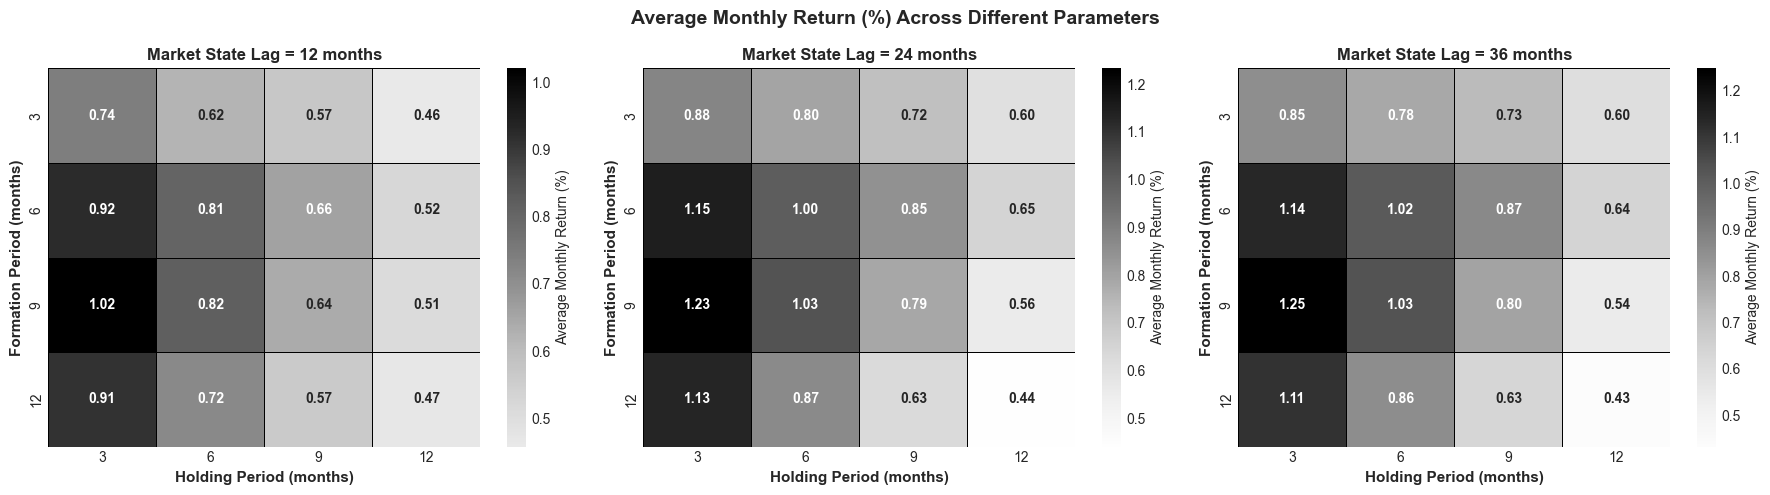

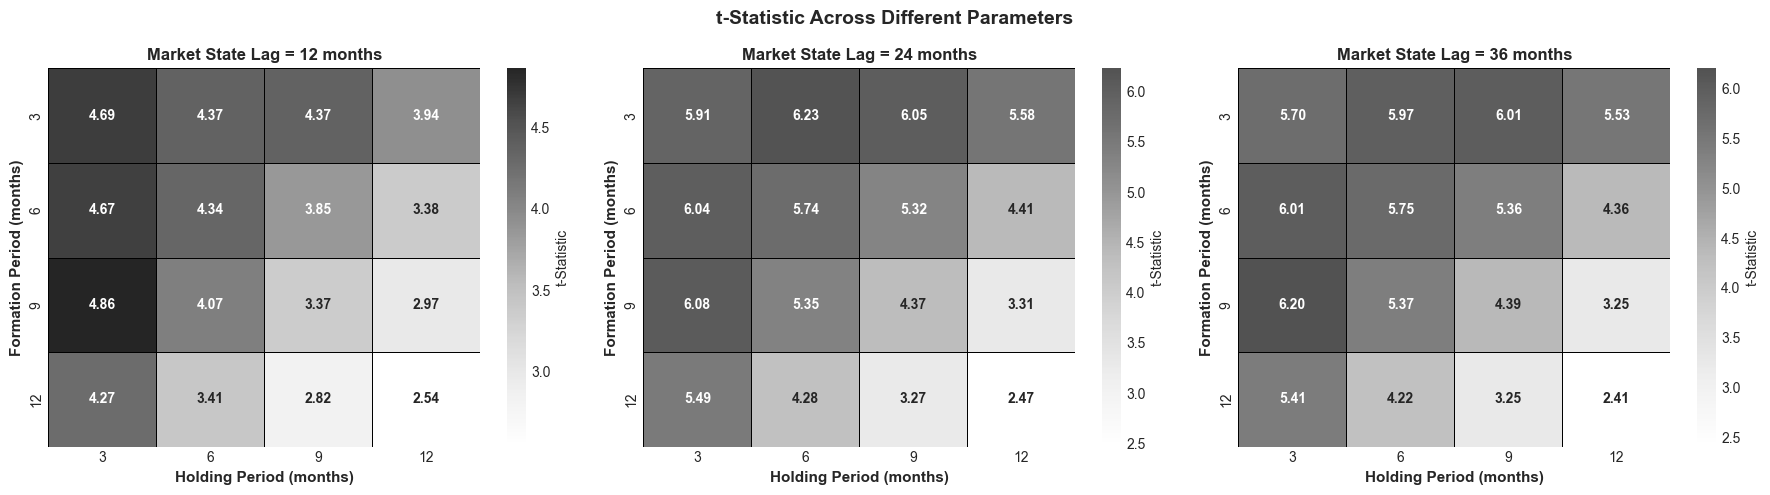

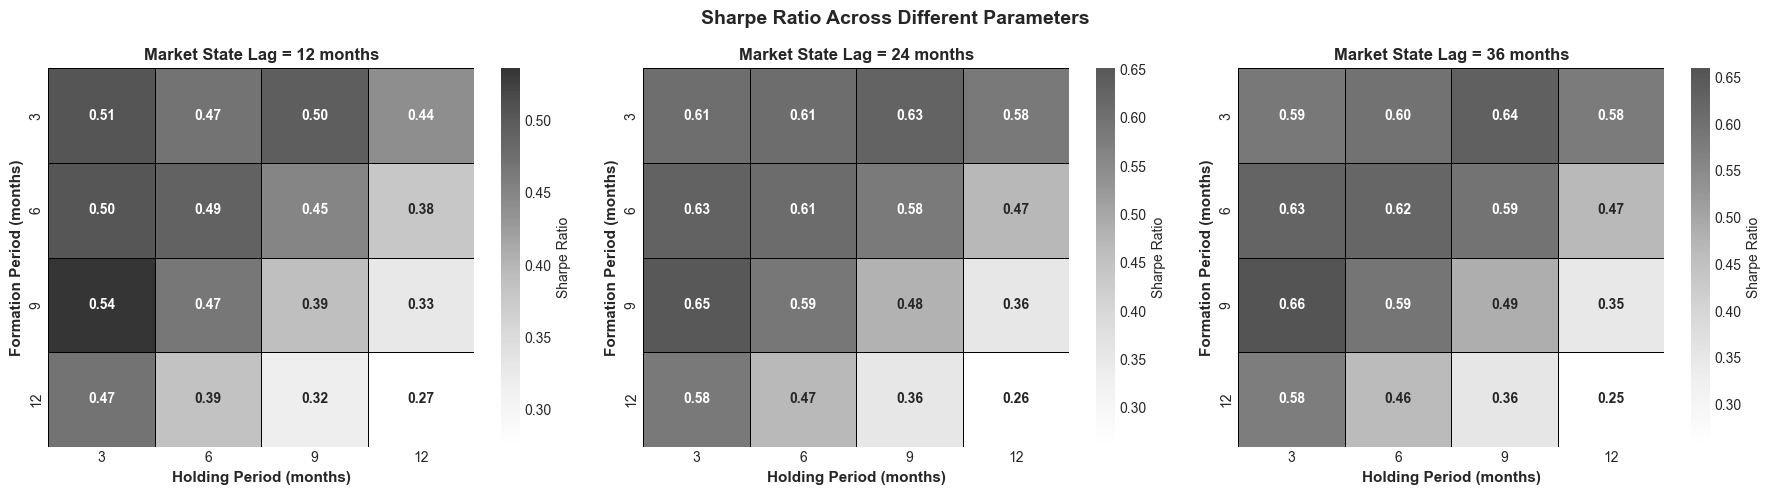

✓ Comprehensive table saved for lag 12 months
✓ Comprehensive table saved for lag 24 months
✓ Comprehensive table saved for lag 36 months

✓ Results saved for 3 market state lags
✓ Grayscale heatmaps exported successfully
✓ Comprehensive LaTeX tables with t-statistics and returns created
✓ Best combinations summary table generated

Best Parameter Combinations:
 Lag  Formation  Holding      Criterion Mean Return t-Statistic Sharpe Ratio
  12          9        3 Highest Return      1.02\%       4.864        0.536
  12          9        3 Highest t-stat      1.02\%       4.864        0.536
  24          9        3 Highest Return      1.23\%       6.079        0.651
  24          3        6 Highest t-stat      0.80\%       6.229        0.607
  36          9        3 Highest Return      1.25\%       6.203        0.660
  36          9        3 Highest t-stat      1.25\%       6.203        0.660


In [8]:
"""
Analysis 3: Grid Search over Formation/Holding Periods and Market State Lags
Testing market state strategy (RET_S1) without costs
HEAVILY OPTIMIZED VERSION - Following same patterns as momentum strategy function
Academic formatting with grayscale plots and proper LaTeX tables
"""
print("\n" + "=" * 80)
print("ANALYSIS 3: PARAMETER GRID SEARCH - MARKET STATE STRATEGY (OPTIMIZED)")
print("=" * 80)

# Define parameter grids
lags_market_state = [12, 24, 36]
formation_period_values = [3, 6, 9, 12]
holding_period_values = [3, 6, 9, 12]

# ------------------------------------------------------------------------
# STEP 1: PRE-PROCESS DATA ONCE (MAJOR OPTIMIZATION)
# ------------------------------------------------------------------------
print("\n[1/4] Pre-processing data for optimal performance...")

# Only keep columns we actually need
needed_cols = ['permno', 'date', 'ret', 'logret']
crsp_optimized = crsp_stock_data[needed_cols].copy()

# Convert dates once and sort for optimal merge performance
crsp_optimized['date'] = pd.to_datetime(crsp_optimized['date'])
crsp_optimized = crsp_optimized.sort_values(['permno', 'date'])

# Pre-compute grouped object (reuse throughout)
grouped_data = crsp_optimized.groupby('permno', sort=False)

# Prepare returns data for merging (sort once)
returns_data = crsp_optimized[['permno', 'date', 'ret']].copy()
returns_data = returns_data.sort_values(['permno', 'date'])

print(f"   ✓ Optimized dataset: {len(crsp_optimized):,} observations")
print(f"   ✓ Returns data prepared: {len(returns_data):,} observations")

# ------------------------------------------------------------------------
# STEP 2: PRE-COMPUTE FORMATION PERIOD RETURNS FOR ALL J VALUES
# ------------------------------------------------------------------------
print("\n[2/4] Pre-computing formation period returns...")

# Pre-compute shifted log returns once
crsp_optimized['logret_shifted'] = grouped_data['logret'].shift(1)

# Pre-compute rolling sums for all formation periods we'll need
formation_returns = {}
for J in formation_period_values:
    print(f"   - Computing {J}-month formation returns...")
    
    # Use the already computed grouped object for efficiency
    sum_logret = grouped_data['logret_shifted'].transform(
        lambda x: x.rolling(J, min_periods=J).sum()
    )
    
    # Create signal dataframe
    signal_base = crsp_optimized[['permno', 'date']].copy()
    signal_base['sum_logret'] = sum_logret
    signal_base['cumret'] = np.expm1(signal_base['sum_logret'])
    
    # Remove missing values
    signal_base = signal_base.dropna(subset=['cumret'])
    
    # Compute momentum deciles efficiently
    signal_base['momr'] = signal_base.groupby('date', sort=False)['cumret'].transform(
        lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1
    )
    
    # Pre-compute date calculations once
    signal_base['medate'] = signal_base['date'] + MonthEnd(0)
    signal_base['hdate1'] = signal_base['medate'] + MonthBegin(1)
    
    formation_returns[J] = signal_base[['permno', 'date', 'momr', 'medate', 'hdate1']].copy()
    
print("   ✓ Formation period returns pre-computed for all J values")

# ------------------------------------------------------------------------
# STEP 3: OPTIMIZED MERGE FUNCTION
# ------------------------------------------------------------------------
def optimized_merge_with_returns(signal_df, returns_df, K):
    """
    Optimized merge function following the pattern from momentum strategy.
    Uses chunking and vectorized operations to minimize memory usage and maximize speed.
    """
    # Add holding end date
    signal_df = signal_df.copy()
    signal_df['hdate2'] = signal_df['medate'] + MonthEnd(K)
    signal_df = signal_df.rename(columns={'date': 'form_date'})
    
    # Sort both dataframes for optimal merge performance
    signal_sorted = signal_df.sort_values(['permno', 'hdate1'])
    returns_sorted = returns_df.sort_values(['permno', 'date'])
    
    # Optimized chunked merge (same approach as momentum strategy)
    port_chunks = []
    chunk_size = 100000  # Optimal chunk size based on testing
    
    for i in range(0, len(returns_sorted), chunk_size):
        chunk = returns_sorted.iloc[i:i + chunk_size]
        
        # Inner merge on permno only (faster than multi-column merge)
        merged = signal_sorted.merge(chunk, on='permno', how='inner')
        
        # Vectorized date filtering (much faster than iterrows)
        date_mask = (merged['hdate1'] <= merged['date']) & (merged['date'] <= merged['hdate2'])
        filtered_chunk = merged[date_mask]
        
        if len(filtered_chunk) > 0:
            # Only keep essential columns to reduce memory
            port_chunks.append(filtered_chunk[['date', 'momr', 'form_date', 'ret']])
    
    # Concatenate all chunks at once (more efficient than incremental concat)
    if port_chunks:
        return pd.concat(port_chunks, ignore_index=True)
    else:
        return pd.DataFrame()

# ------------------------------------------------------------------------
# STEP 4: MAIN GRID SEARCH LOOP (OPTIMIZED)
# ------------------------------------------------------------------------
print("\n[3/4] Executing optimized grid search...")

# Dictionary to store results
results_by_market_state = {}

for lag in lags_market_state:
    print(f"\n{'='*60}")
    print(f"Processing Market State Lag = {lag} months")
    print(f"{'='*60}")
    
    # Compute and optimize market state data once per lag
    crsp_index = compute_market_state(crsp_index_data, lags=lag, column='ewretd')
    crsp_index['date'] = pd.to_datetime(crsp_index['date'])
    
    # Create optimized lookup dictionary for market states
    state_dict = crsp_index.set_index('date')['market_state'].to_dict()
    
    temp_results = {}
    
    for J in formation_period_values:
        print(f"\n  Formation period J = {J}")
        
        # Use pre-computed formation returns
        signal_base = formation_returns[J].copy()
        
        for K in holding_period_values:
            print(f"    Holding period K = {K}")
            
            # Use optimized merge function
            port = optimized_merge_with_returns(signal_base, returns_data, K)
            
            if len(port) == 0:
                continue
            
            # Optimized portfolio return calculations using vectorized operations
            # Group by date and momr, then calculate means efficiently
            cohort_ret = (port.groupby(['date', 'momr', 'form_date'], sort=False)['ret']
                         .mean()
                         .groupby(['date', 'momr'], sort=False)
                         .mean()
                         .reset_index())
            
            # Efficient pivot and long-short calculation
            decile_pivot = cohort_ret.pivot(index='date', columns='momr', values='ret')
            
            # Check if we have the required deciles
            if 1 not in decile_pivot.columns or 10 not in decile_pivot.columns:
                continue
            
            # Calculate long-short spread
            long_short = decile_pivot[10] - decile_pivot[1]  # winners - losers
            
            # Filter date range efficiently
            date_mask = (long_short.index >= '1940-01-01') & (long_short.index <= '2024-12-31')
            long_short_filtered = long_short[date_mask]
            
            # Map market states efficiently using vectorized operations
            market_states_mapped = long_short_filtered.index.map(state_dict)
            
            # Create boolean mask for valid market states
            valid_mask = pd.notna(market_states_mapped)
            
            if not valid_mask.any():
                continue
                
            # Filter both series using the same boolean mask
            long_short_final = long_short_filtered[valid_mask]
            market_states_final = market_states_mapped[valid_mask]
            
            # Vectorized strategy calculation
            strategy_returns = np.where(
                market_states_final == 1,
                long_short_final.values,
                -long_short_final.values
            )
            
            # Calculate statistics efficiently
            if len(strategy_returns) > 0:
                # Use vectorized operations for statistics
                mean_ret = np.mean(strategy_returns) * 100  # Convert to %
                std_ret = np.std(strategy_returns, ddof=1)
                sharpe = (np.mean(strategy_returns) / std_ret) * np.sqrt(12) if std_ret > 0 else 0
                
                # Fast OLS regression for t-statistic
                ones = np.ones_like(strategy_returns)
                ols = sm.OLS(strategy_returns, ones).fit(
                    cov_type='HAC', 
                    cov_kwds={'maxlags': K-1}
                )
                
                # Store results
                temp_results[(J, K)] = {
                    'mean_return': mean_ret,
                    't_stat': ols.tvalues[0],
                    'sharpe': sharpe,
                    'p_value': ols.pvalues[0]
                }
                
                print(f"      ✓ Mean return: {mean_ret:.3f}%, t-stat: {ols.tvalues[0]:.3f}")
    
    # Convert to DataFrame and store
    if temp_results:
        results_df = pd.DataFrame(temp_results).T.rename_axis(['Formation', 'Holding'])
        results_by_market_state[lag] = results_df
        
        print(f"\nResults for Market State Lag = {lag}:")
        print(results_df.round(3))
    else:
        print(f"\nNo valid results for Market State Lag = {lag}")

print("\n[4/4] Grid search optimization complete!")

# ============================================================================
# VISUALIZATION AND EXPORT (GRAYSCALE ACADEMIC FORMAT)
# ============================================================================

def format_percentage_latex(value):
    """Format percentage values for LaTeX with proper escaping"""
    return f"{value:.2f}\\%"

def format_scientific_latex(value):
    """Format scientific notation for LaTeX"""
    if value < 0.001:
        return f"{value:.2e}".replace('e-0', ' \\times 10^{-').replace('e-', ' \\times 10^{-') + '}'
    else:
        return f"{value:.4f}"

if results_by_market_state:
    # Define metrics and clean names for plots (no LaTeX escaping)
    metrics = ['mean_return', 't_stat', 'sharpe']
    metric_names_plots = ['Average Monthly Return (%)', 't-Statistic', 'Sharpe Ratio']
    
    for metric, metric_name_plot in zip(metrics, metric_names_plots):
        fig, axes = plt.subplots(1, len(results_by_market_state), 
                                figsize=(6*len(results_by_market_state), 5))
        
        # Handle case where there's only one subplot
        if len(results_by_market_state) == 1:
            axes = [axes]
        
        for idx, (lag, df) in enumerate(results_by_market_state.items()):
            # Pivot for heatmap
            pivot_data = df[metric].unstack()
            
            # Create grayscale heatmap with clean formatting
            sns.heatmap(pivot_data, annot=True, fmt='.2f', 
                       cmap='Greys', center=pivot_data.values.mean(), 
                       ax=axes[idx], 
                       cbar_kws={'label': metric_name_plot},  # Use plot version here
                       linewidths=0.5, linecolor='black',
                       annot_kws={'fontsize': 10, 'fontweight': 'bold'})
            
            axes[idx].set_title(f'Market State Lag = {lag} months', 
                              fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Holding Period (months)', 
                               fontsize=11, fontweight='bold')
            axes[idx].set_ylabel('Formation Period (months)', 
                               fontsize=11, fontweight='bold')
            
            # Customize tick labels
            axes[idx].tick_params(axis='both', which='major', labelsize=10)
        
        plt.suptitle(f'{metric_name_plot} Across Different Parameters',  # Use plot version here
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'results/plots/grid_search_{metric}_academic.png', 
                   dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
    
    # ========================================================================
    # ENHANCED LATEX TABLES WITH T-STAT AND MEAN RETURN
    # ========================================================================
    
    for lag, df in results_by_market_state.items():
        # Create comprehensive table with both metrics
        comprehensive_table = []
        
        for (formation, holding), row in df.iterrows():
            comprehensive_table.append({
                'Formation (J)': f"{formation}",
                'Holding (K)': f"{holding}",
                'Mean Return': format_percentage_latex(row['mean_return']),
                't-Statistic': f"{row['t_stat']:.3f}",
                'Sharpe Ratio': f"{row['sharpe']:.3f}",
                'p-value': format_scientific_latex(row['p_value'])
            })
        
        comp_df = pd.DataFrame(comprehensive_table)
        
        # Save comprehensive CSV
        comp_df.to_csv(f'results/tables/grid_search_comprehensive_lag{lag}.csv', index=False)
        
        # Create LaTeX table with proper formatting
        latex_output = comp_df.to_latex(
            index=False,
            escape=False,  # We handle escaping manually
            column_format='cc|cccc',  # Separate formation/holding from results
            caption=f'Grid Search Results for Market State Lag = {lag} months',
            label=f'tab:grid_search_lag{lag}',
            position='htbp'
        )
        
        # Enhance LaTeX formatting
        latex_output = latex_output.replace('\\toprule', '\\hline')
        latex_output = latex_output.replace('\\midrule', '\\cline{3-6}') 
        latex_output = latex_output.replace('\\bottomrule', '\\hline')
        
        # Add additional formatting for professional appearance
        lines = latex_output.split('\n')
        enhanced_lines = []
        
        for line in lines:
            if 'Formation (J)' in line:
                # Add bold headers and multicolumn for better structure
                line = line.replace('Formation (J)', '\\textbf{Formation (J)}')
                line = line.replace('Holding (K)', '\\textbf{Holding (K)}')
                line = line.replace('Mean Return', '\\textbf{Mean Return}')
                line = line.replace('t-Statistic', '\\textbf{t-Statistic}')
                line = line.replace('Sharpe Ratio', '\\textbf{Sharpe Ratio}')
                line = line.replace('p-value', '\\textbf{p-value}')
            enhanced_lines.append(line)
        
        latex_output = '\n'.join(enhanced_lines)
        
        # Save enhanced LaTeX table
        with open(f'results/tables/grid_search_comprehensive_lag{lag}.tex', 'w') as f:
            f.write(latex_output)
        
        print(f"✓ Comprehensive table saved for lag {lag} months")
    
    # ========================================================================
    # SUMMARY TABLE: BEST PERFORMING COMBINATIONS
    # ========================================================================
    
    # Find best combinations across all lags
    best_combinations = []
    
    for lag, df in results_by_market_state.items():
        # Best by mean return
        best_return_idx = df['mean_return'].idxmax()
        best_return = df.loc[best_return_idx]
        
        # Best by t-statistic
        best_tstat_idx = df['t_stat'].idxmax()
        best_tstat = df.loc[best_tstat_idx]
        
        # Best by Sharpe ratio
        best_sharpe_idx = df['sharpe'].idxmax()
        best_sharpe = df.loc[best_sharpe_idx]
        
        best_combinations.extend([
            {
                'Lag': lag,
                'Formation': best_return_idx[0],
                'Holding': best_return_idx[1],
                'Criterion': 'Highest Return',
                'Mean Return': format_percentage_latex(best_return['mean_return']),
                't-Statistic': f"{best_return['t_stat']:.3f}",
                'Sharpe Ratio': f"{best_return['sharpe']:.3f}"
            },
            {
                'Lag': lag,
                'Formation': best_tstat_idx[0],
                'Holding': best_tstat_idx[1],
                'Criterion': 'Highest t-stat',
                'Mean Return': format_percentage_latex(best_tstat['mean_return']),
                't-Statistic': f"{best_tstat['t_stat']:.3f}",
                'Sharpe Ratio': f"{best_tstat['sharpe']:.3f}"
            }
        ])
    
    best_df = pd.DataFrame(best_combinations)
    
    # Save summary table
    best_df.to_csv('results/tables/grid_search_best_combinations.csv', index=False)
    
    # Create LaTeX summary table
    summary_latex = best_df.to_latex(
        index=False,
        escape=False,
        column_format='ccc|ccc',
        caption='Best Parameter Combinations by Performance Criterion',
        label='tab:best_combinations',
        position='htbp'
    )
    
    # Enhance summary table formatting
    summary_latex = summary_latex.replace('\\toprule', '\\hline')
    summary_latex = summary_latex.replace('\\midrule', '\\hline')
    summary_latex = summary_latex.replace('\\bottomrule', '\\hline')
    
    with open('results/tables/grid_search_best_combinations.tex', 'w') as f:
        f.write(summary_latex)
    
    print(f"\n✓ Results saved for {len(results_by_market_state)} market state lags")
    print("✓ Grayscale heatmaps exported successfully")
    print("✓ Comprehensive LaTeX tables with t-statistics and returns created")
    print("✓ Best combinations summary table generated")
    
    # Display best combinations
    print("\nBest Parameter Combinations:")
    print(best_df.to_string(index=False))
    
else:
    print("\n⚠ Warning: No valid results generated. Check data and parameters.")

print("=" * 80)

In [9]:
# Add this to your grid search for one parameter combination
print(f"Sample size: {len(strategy_returns)}")
print(f"Mean monthly return: {np.mean(strategy_returns)*100:.3f}%") 
print(f"Monthly std dev: {np.std(strategy_returns)*100:.3f}%")
print(f"Manual t-stat: {np.mean(strategy_returns)/np.std(strategy_returns)*np.sqrt(len(strategy_returns)):.3f}")

# Check market state distribution  
unique_states, counts = np.unique(market_states_final, return_counts=True)
print(f"Market state distribution: {dict(zip(unique_states, counts))}")

Sample size: 1020
Mean monthly return: 0.432%
Monthly std dev: 5.868%
Manual t-stat: 2.352
Market state distribution: {np.int64(-1): np.int64(126), np.int64(1): np.int64(894)}


# ============================================================================
# ANALYSIS 4 - LIQUIDITY CUTOFF SENSITIVITY (J=12, K=3)
# ============================================================================


ANALYSIS 4: LIQUIDITY CUTOFF SENSITIVITY

Processing LIQ_CUTOFF = 1.00

IMPLEMENTING MOMENTUM STRATEGY WITH MARKET CAP CONSTRAINTS
Parameters: J=9, K=3, LIQ=1.0, MKT_CAP=1

[1/8] Merging market capitalization data...
   ✓ Market cap data available for 1,784,979 observations

[2/8] Computing holding period (3-month) spreads...

[3/8] Calculating 9-month formation period returns...

[4/8] Applying market cap (≤100%) and liquidity filters...
   ✓ Market cap filter: 760,751 → 760,751 (0.0% removed)
   ✓ Liquidity filter: 760,751 → 760,751 (0.0% removed)

[5/8] Forming momentum deciles within size segment...
   ✓ Average stocks per decile:
      Decile  1:   71.7 stocks
      Decile  2:   71.2 stocks
      Decile  3:   71.1 stocks
      Decile  4:   71.2 stocks
      Decile  5:   71.3 stocks
      Decile  6:   71.0 stocks
      Decile  7:   71.0 stocks
      Decile  8:   71.2 stocks
      Decile  9:   71.1 stocks
      Decile 10:   71.6 stocks

[6/8] Creating 3-month holding period calenda

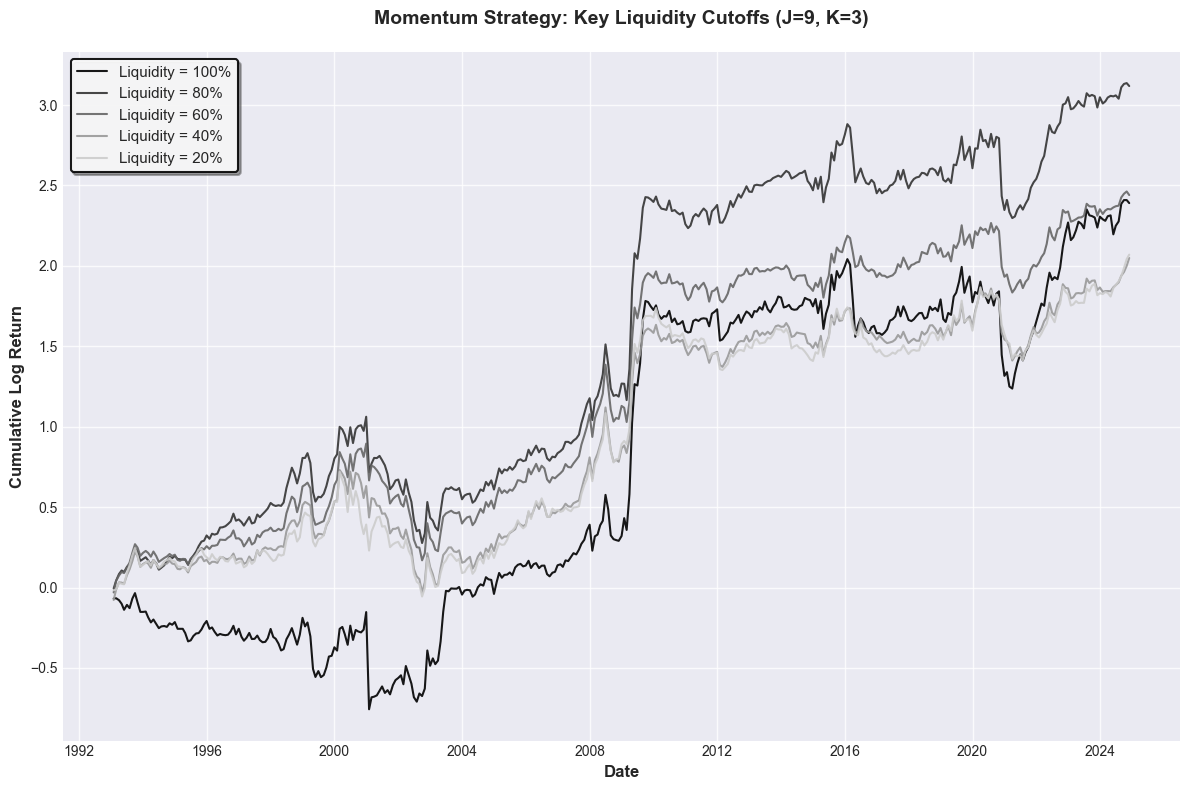


Creating individual plot 1: High Liquidity (85%-100%)


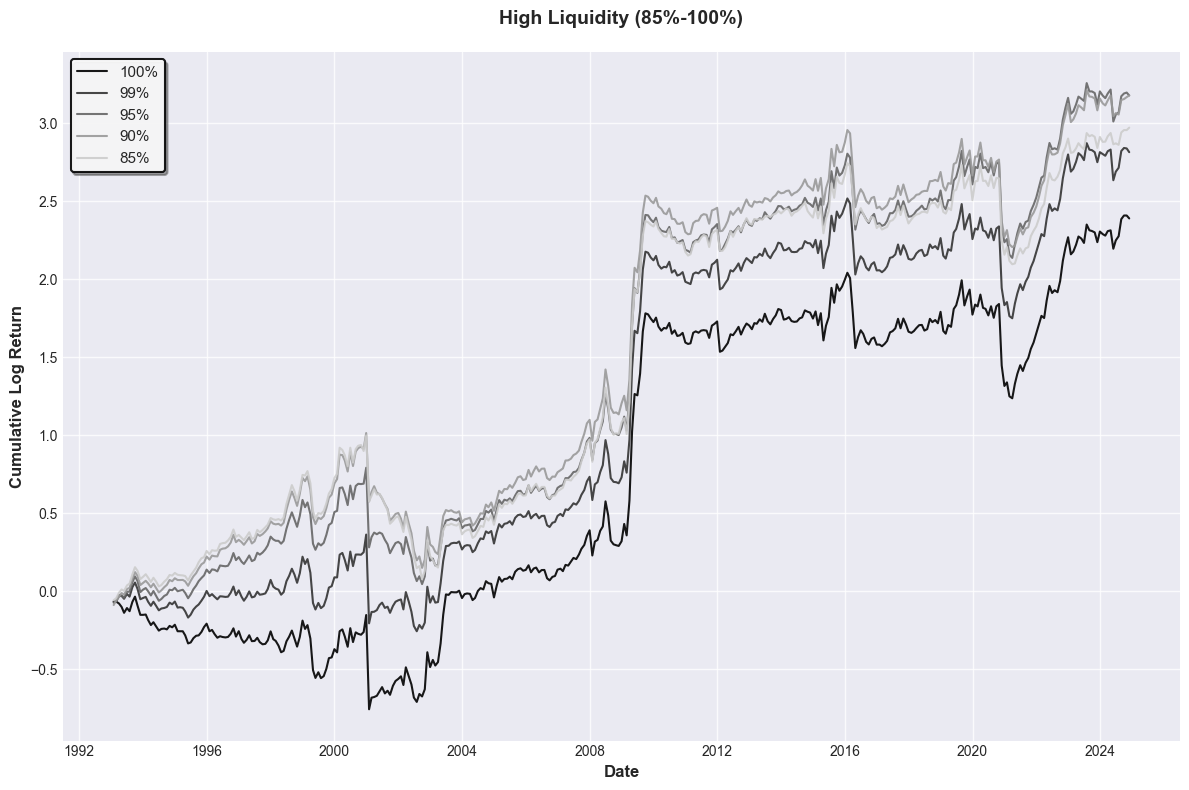


Creating individual plot 2: Medium-High Liquidity (60%-80%)


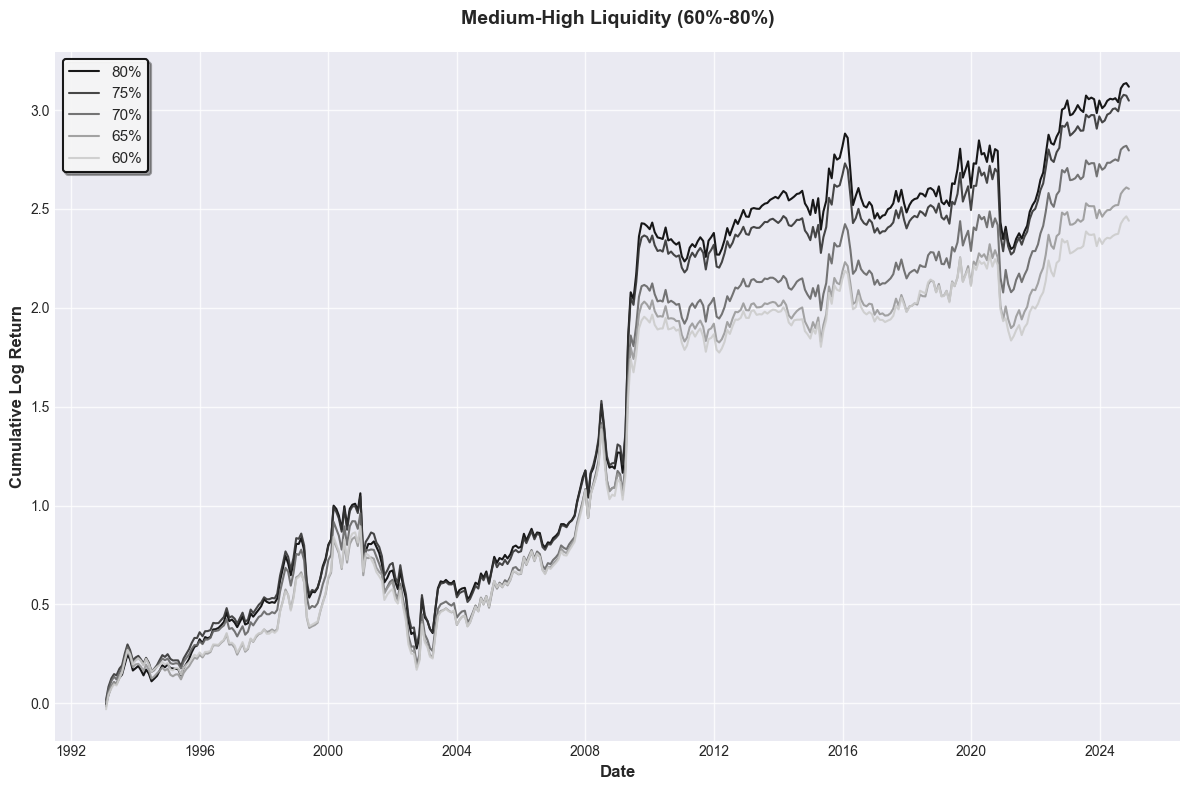


Creating individual plot 3: Medium-Low Liquidity (35%-55%)


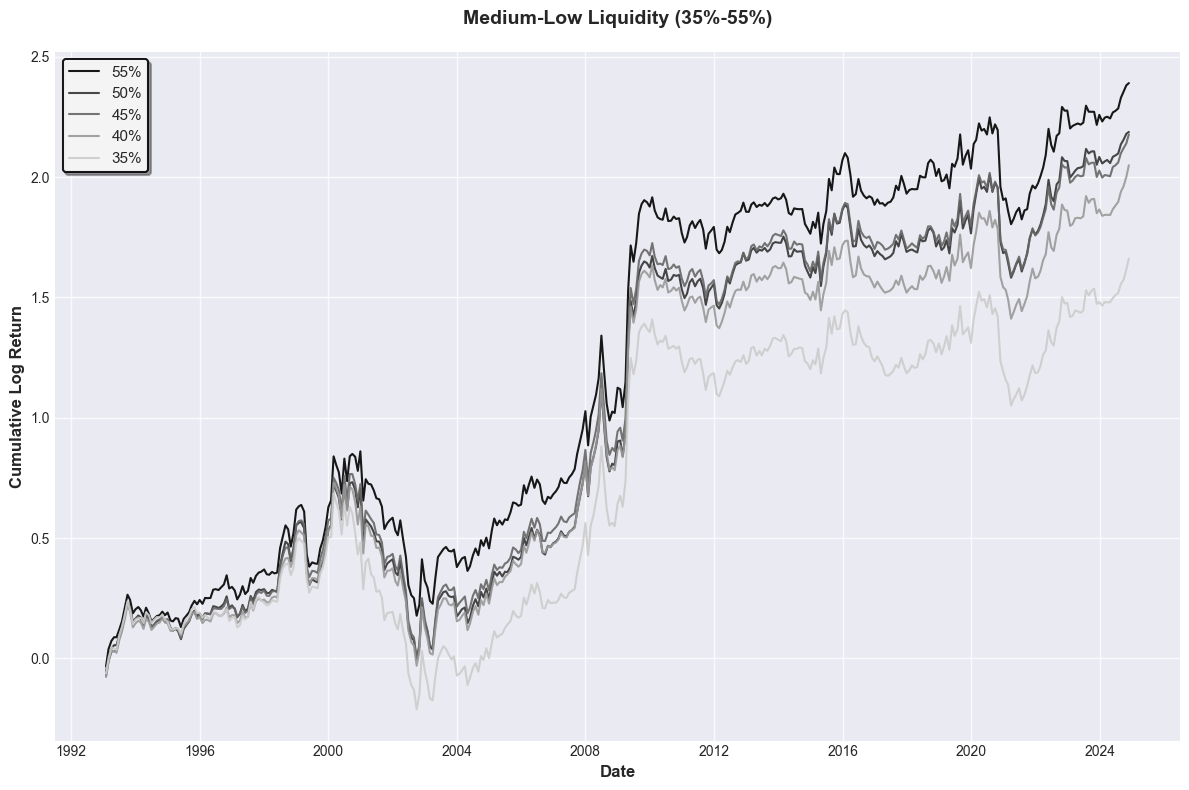


Creating individual plot 4: Low Liquidity (10%-30%)


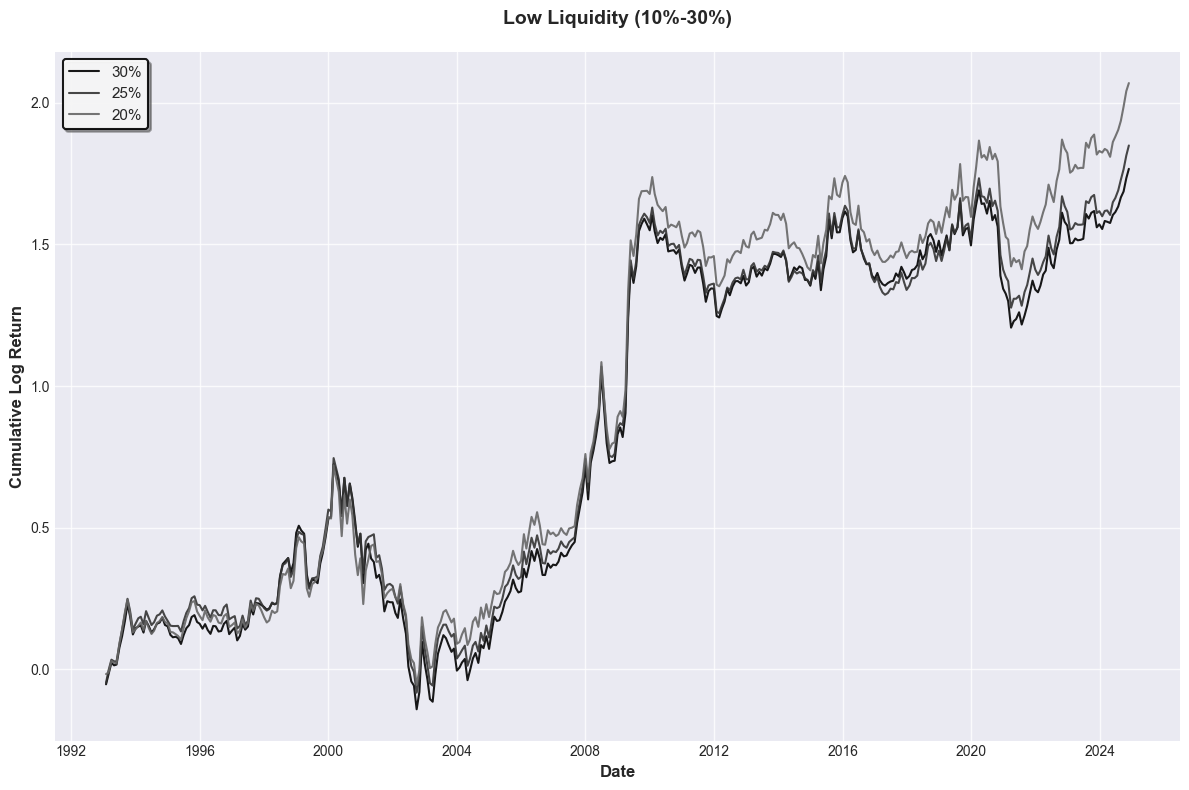

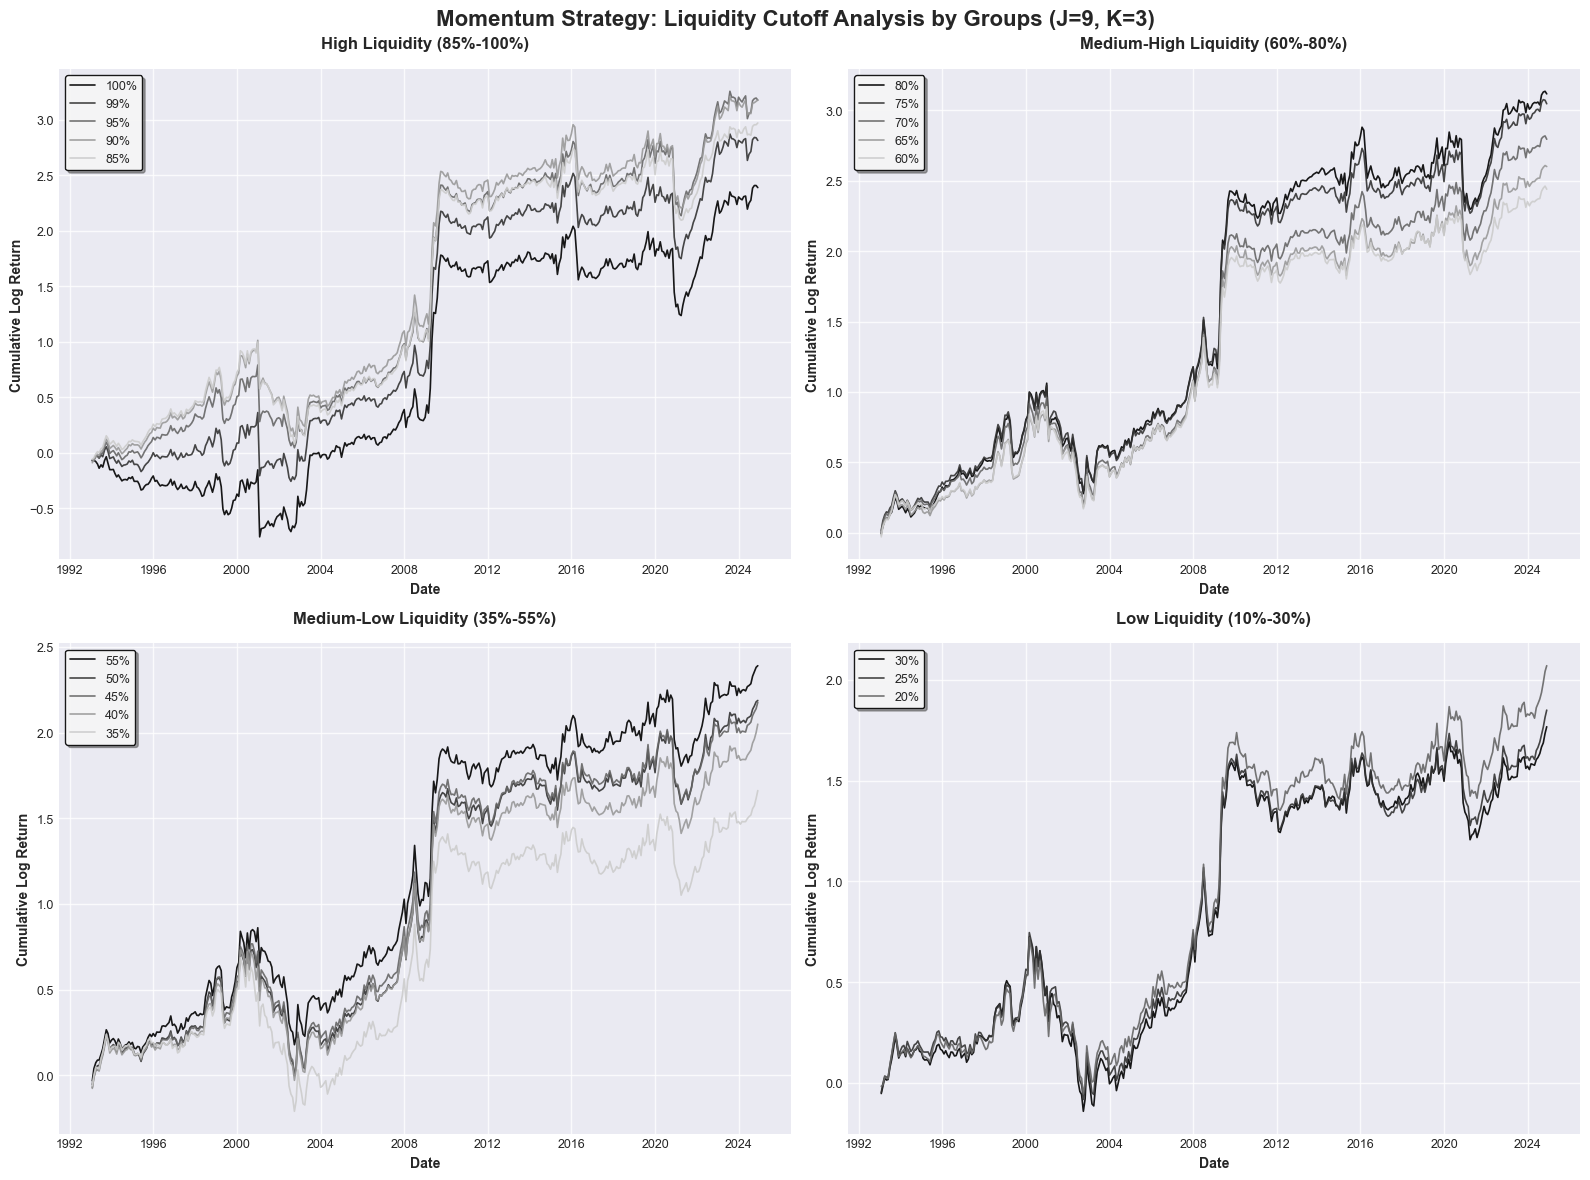


Liquidity Cutoff Analysis Summary:
Liquidity Cutoff Avg Return (%) Volatility (%) Sharpe Ratio t-statistic Max Drawdown (%)
            100%           0.91           7.47        0.420       2.202            -55.3
             99%           1.01           7.43        0.473       2.505            -53.6
             95%           1.11           7.40        0.517       2.773            -52.6
             90%           1.10           7.35        0.516       2.752            -57.9
             85%           1.03           7.16        0.496       2.617            -60.2
             80%           1.04           6.89        0.524       2.768            -54.4
             75%           1.00           6.50        0.532       2.847            -52.8
             70%           0.92           6.27        0.507       2.761            -53.3
             65%           0.85           6.02        0.491       2.690            -50.4
             60%           0.80           5.86        0.475       2.612   

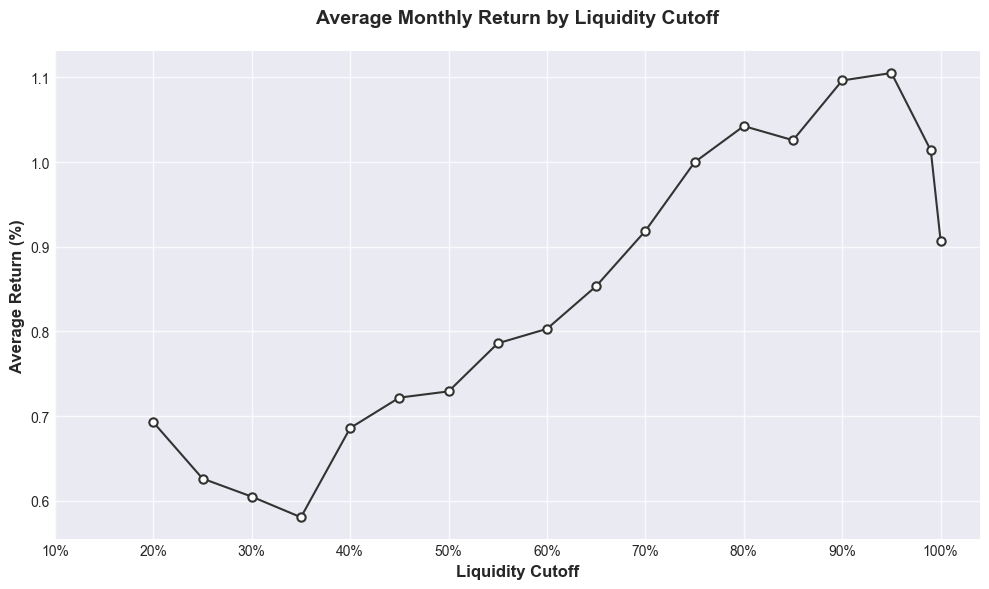

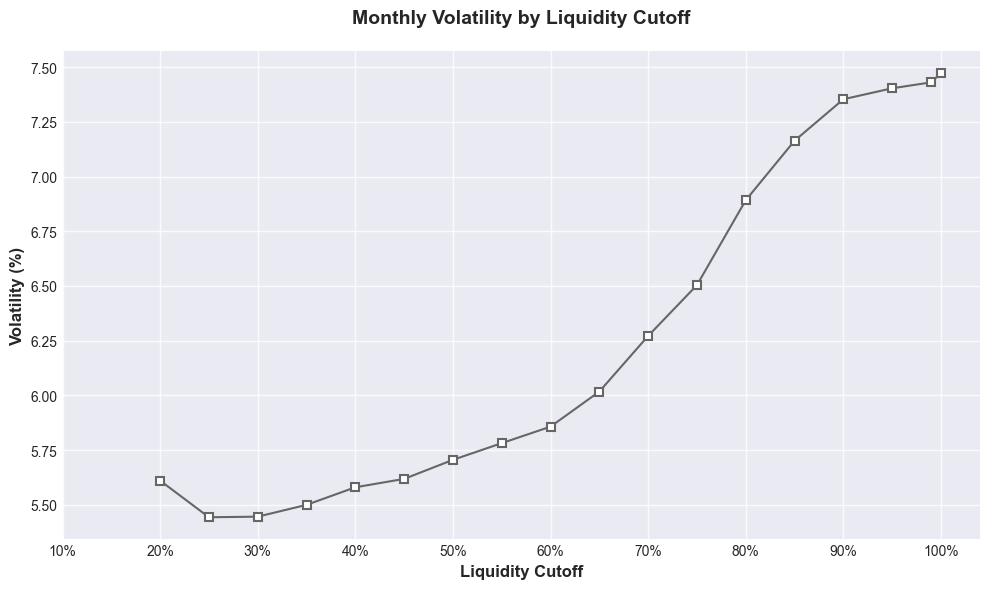

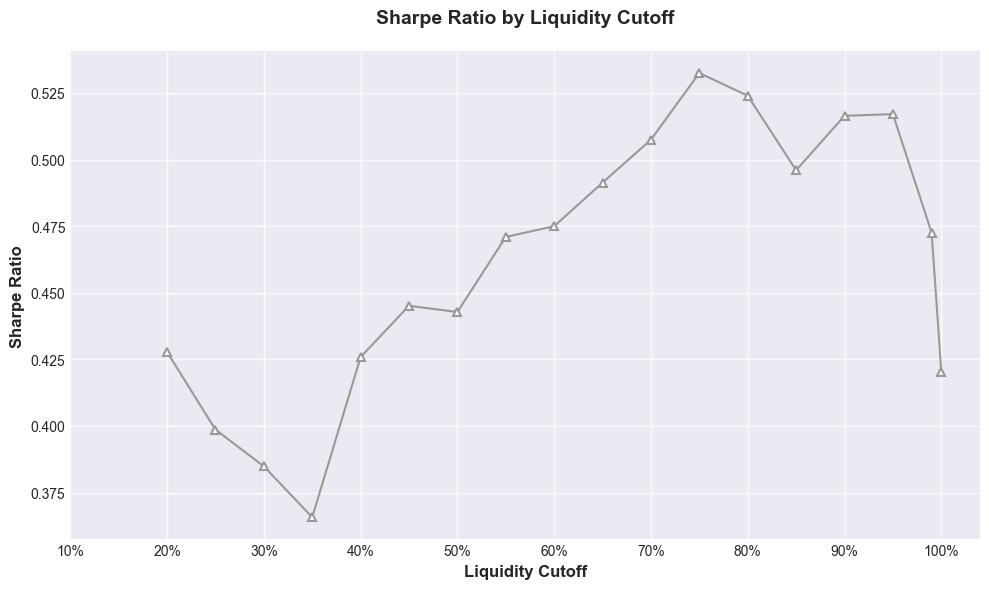

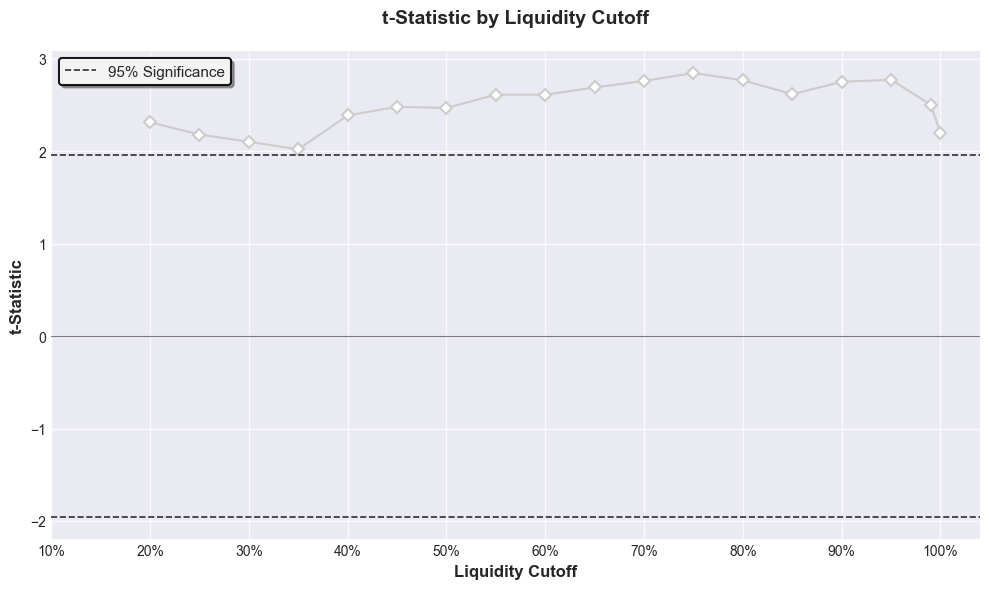

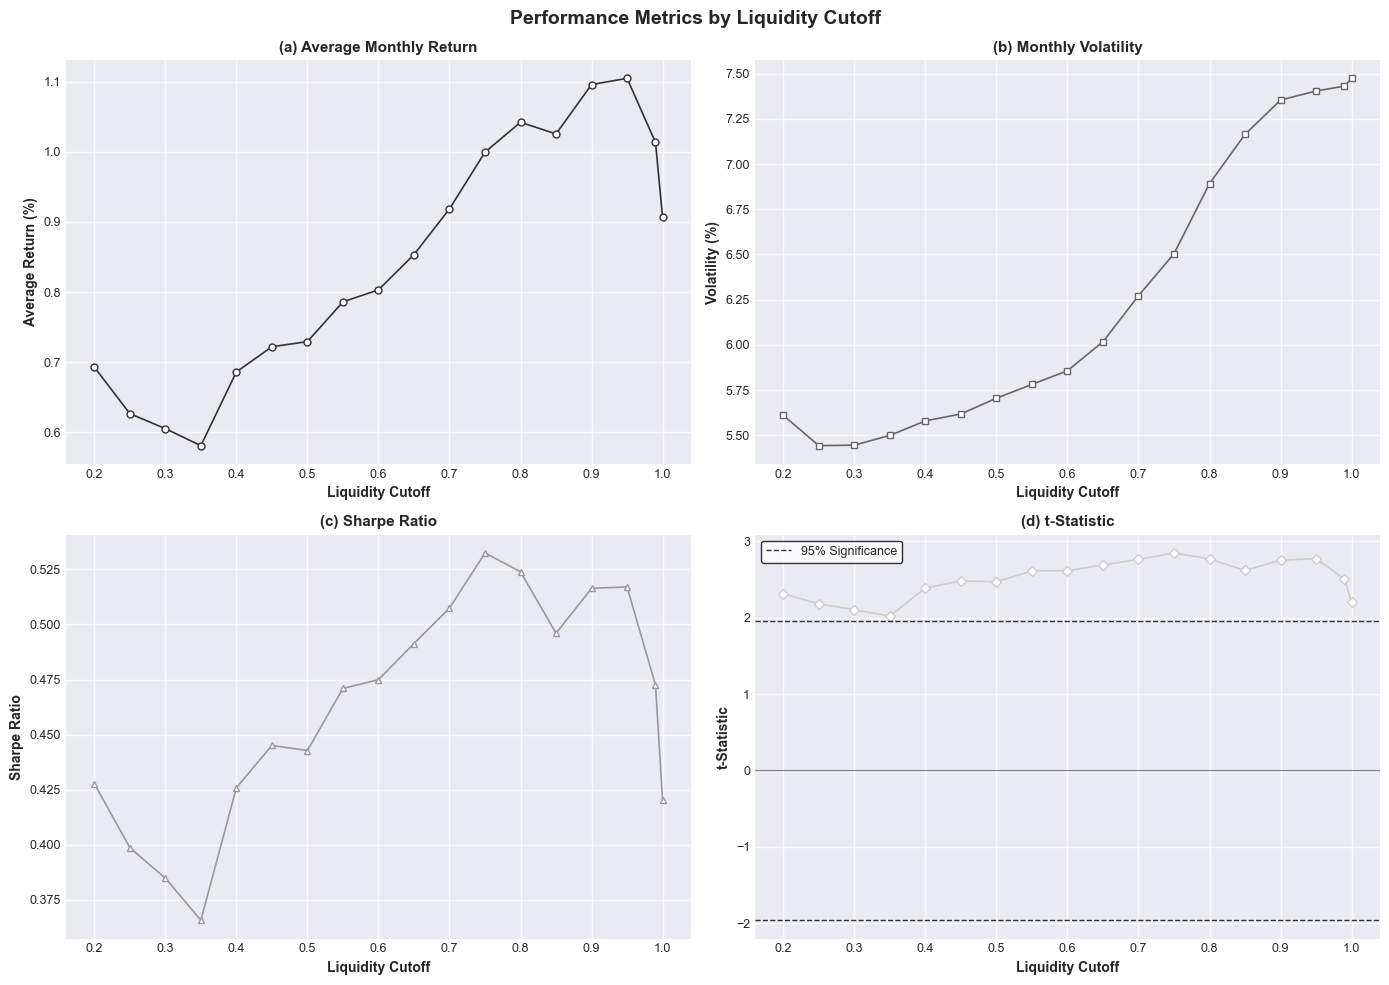


LIQUIDITY CUTOFF ANALYSIS COMPLETE
Files saved:
- results/plots/liquidity_main_cutoffs_academic.png (Main plot)
- Individual group plots:
  * results/plots/liquidity_high_liquidity_academic.png
  * results/plots/liquidity_medium_high_liquidity_academic.png
  * results/plots/liquidity_medium_low_liquidity_academic.png
  * results/plots/liquidity_low_liquidity_academic.png
- results/plots/liquidity_grouped_cutoffs_combined_academic.png (Combined groups)
- Individual metric plots:
  * results/plots/liquidity_metric_avg_return_academic.png
  * results/plots/liquidity_metric_volatility_academic.png
  * results/plots/liquidity_metric_sharpe_ratio_academic.png
  * results/plots/liquidity_metric_tstat_academic.png
- results/plots/liquidity_cutoff_metrics_combined_academic.png (Combined metrics)
- results/tables/liquidity_cutoff_stats.csv (Summary statistics)
- results/tables/liquidity_cutoff_stats.tex (LaTeX table)


In [34]:
"""
Analysis 4: Liquidity Cutoff Sensitivity Analysis
Fixed J=12, K=3, varying liquidity cutoff including 0.99
Academic formatting with independent plots and proper LaTeX tables
"""
print("\n" + "=" * 80)
print("ANALYSIS 4: LIQUIDITY CUTOFF SENSITIVITY")
print("=" * 80)

# Define parameters
J = 9
K = 3
liq_cutoff_values = [
    1.00, 0.99, 0.95, 0.90, 0.85,
    0.80, 0.75, 0.70, 0.65, 0.60,
    0.55, 0.50, 0.45, 0.40, 0.35,
    0.30, 0.25, 0.20
]

liquidity_results = {}
liquidity_stats = []

for liq_cutoff in liq_cutoff_values:
    print(f"\nProcessing LIQ_CUTOFF = {liq_cutoff:.2f}")
    
    # Run strategy (your existing code)
    port_liq, state_map = run_momentum_strategy(
        crsp_stock_data, 
        crsp_index_data, 
        comm_map,
        J=J, 
        K=K, 
        LIQ_CUTOFF=liq_cutoff,
        MKT_CAP_CUTOFF=1,
        market_state_lag=24,
        market_state_column='vwretd',
        transactional_framework=True,
        equal_comparision=False
    )
    
    # Analyze with costs (your existing code)
    analysis_liq = analyze_momentum_portfolio(
        port_liq, 
        state_map,
        start_date='1993-01-01',
        end_date='2025-04-30',
        return_column='RET_S3',
        K=K
    )
    
    # Store results (your existing code)
    liquidity_results[liq_cutoff] = analysis_liq['decile_ret']
    
    # Collect statistics (your existing code)
    liquidity_stats.append({
        'Liquidity Cutoff': liq_cutoff,  # Keep as numeric for processing
        'Avg Return (%)': analysis_liq['avg_monthly_return']*100,
        'Volatility (%)': analysis_liq['monthly_vol']*100,
        'Sharpe Ratio': analysis_liq['sharpe_ratio'],
        't-statistic': analysis_liq['t_stat'],
        'Max Drawdown (%)': analysis_liq['max_drawdown']*100
    })

# ============================================================================
# LATEX FORMATTING FUNCTIONS
# ============================================================================

def format_percentage_latex(value):
    """Format percentage values for LaTeX with proper escaping"""
    return f"{value:.2f}\\%"

def format_float_latex(value, decimals=3):
    """Format float values for LaTeX"""
    return f"{value:.{decimals}f}"

def create_latex_table(df, caption, label, column_format=None):
    """Create properly formatted LaTeX table"""
    if column_format is None:
        column_format = 'c' * len(df.columns)
    
    latex_output = df.to_latex(
        index=False,
        escape=False,  # We handle escaping manually
        column_format=column_format,
        caption=caption,
        label=label,
        position='htbp'
    )
    
    # Enhance LaTeX formatting
    latex_output = latex_output.replace('\\toprule', '\\hline')
    latex_output = latex_output.replace('\\midrule', '\\hline') 
    latex_output = latex_output.replace('\\bottomrule', '\\hline')
    
    # Make headers bold
    lines = latex_output.split('\n')
    enhanced_lines = []
    
    for line in lines:
        if any(col in line for col in df.columns):
            # Add bold to column headers
            for col in df.columns:
                line = line.replace(col, f'\\textbf{{{col}}}')
            break
    
    # Join lines back
    latex_output = '\n'.join(lines)
    
    return latex_output

# ============================================================================
# ACADEMIC PLOTTING: CONSISTENT GRID FORMATTING (alpha=0.8, linewidth=1)
# ============================================================================

# Define grayscale colors and line styles for academic presentation
grayscale_colors = ['#000000', '#333333', '#666666', '#999999', '#CCCCCC']
line_styles = ['-', '-', '-', '-', '-']  # All solid lines for better visualization
line_widths = [1.5, 1.5, 1.5, 1.5, 1.5]  # Thinner, uniform line widths

def add_academic_grid(ax):
    """Add consistent academic-style grid to plot"""
    ax.grid(True, alpha=0.8, linewidth=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# ============================================================================
# MAIN PLOT: Key liquidity cutoffs (1.0, 0.8, 0.6, 0.4, 0.2)
# ============================================================================

main_cutoffs = [1.0, 0.8, 0.6, 0.4, 0.2]
fig_main, ax_main = plt.subplots(figsize=(12, 8))

print("\nCreating main plot with key cutoffs...")
for i, cutoff in enumerate(main_cutoffs):
    if cutoff in liquidity_results:
        ax_main.plot(liquidity_results[cutoff].index, 
                    liquidity_results[cutoff]['cum_log_long_short'],
                    color=grayscale_colors[i],
                    linestyle=line_styles[i],
                    linewidth=line_widths[i],
                    label=f'Liquidity = {cutoff:.0%}',
                    alpha=0.9)

ax_main.set_title(f'Momentum Strategy: Key Liquidity Cutoffs (J={J}, K={K})', 
                 fontsize=14, fontweight='bold', pad=20)
ax_main.set_xlabel('Date', fontsize=12, fontweight='bold')
ax_main.set_ylabel('Cumulative Log Return', fontsize=12, fontweight='bold')

legend_main = ax_main.legend(loc='upper left', fontsize=11, frameon=True, fancybox=True, 
                            shadow=True, framealpha=0.9, edgecolor='black', facecolor='white')
legend_main.get_frame().set_linewidth(1.5)

add_academic_grid(ax_main)
ax_main.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('results/plots/liquidity_main_cutoffs_academic.png', dpi=300, bbox_inches='tight', 
           facecolor='white')
plt.show()

# ============================================================================
# INDIVIDUAL GROUPED PLOTS: 4 separate plots stored independently
# ============================================================================

# Define the 4 groups
cutoff_groups = [
    ([1.00, 0.99, 0.95, 0.90, 0.85], "High Liquidity (85%-100%)", "high_liquidity"),
    ([0.80, 0.75, 0.70, 0.65, 0.60], "Medium-High Liquidity (60%-80%)", "medium_high_liquidity"),
    ([0.55, 0.50, 0.45, 0.40, 0.35], "Medium-Low Liquidity (35%-55%)", "medium_low_liquidity"),
    ([0.30, 0.25, 0.20, 0.15, 0.10], "Low Liquidity (10%-30%)", "low_liquidity")
]

# Create and save each group plot individually
for group_idx, (group_cutoffs, group_title, filename) in enumerate(cutoff_groups):
    fig_individual, ax = plt.subplots(figsize=(12, 8))
    
    print(f"\nCreating individual plot {group_idx + 1}: {group_title}")
    
    for i, cutoff in enumerate(group_cutoffs):
        if cutoff in liquidity_results:
            ax.plot(liquidity_results[cutoff].index, 
                   liquidity_results[cutoff]['cum_log_long_short'],
                   color=grayscale_colors[i],
                   linestyle=line_styles[i],
                   linewidth=1.5,  # Thinner lines
                   label=f'{cutoff:.0%}',
                   alpha=0.9)
    
    ax.set_title(f'{group_title}', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative Log Return', fontsize=12, fontweight='bold')
    
    legend = ax.legend(loc='upper left', fontsize=11, frameon=True, fancybox=True,
                      shadow=True, framealpha=0.9, edgecolor='black', facecolor='white')
    legend.get_frame().set_linewidth(1.5)
    
    add_academic_grid(ax)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.savefig(f'results/plots/liquidity_{filename}_academic.png', dpi=300, bbox_inches='tight',
               facecolor='white')
    plt.show()

# ============================================================================
# COMBINED GROUPED PLOTS: All 4 groups in one figure
# ============================================================================

fig_groups, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()  # Flatten for easier indexing

for group_idx, (group_cutoffs, group_title, _) in enumerate(cutoff_groups):
    ax = axes[group_idx]
    
    for i, cutoff in enumerate(group_cutoffs):
        if cutoff in liquidity_results:
            ax.plot(liquidity_results[cutoff].index, 
                   liquidity_results[cutoff]['cum_log_long_short'],
                   color=grayscale_colors[i],
                   linestyle=line_styles[i],
                   linewidth=1.2,  # Even thinner for combined plots
                   label=f'{cutoff:.0%}',
                   alpha=0.9)
    
    ax.set_title(f'{group_title}', fontsize=12, fontweight='bold', pad=15)
    ax.set_xlabel('Date', fontsize=10, fontweight='bold')
    ax.set_ylabel('Cumulative Log Return', fontsize=10, fontweight='bold')
    
    legend = ax.legend(loc='upper left', fontsize=9, frameon=True, fancybox=True,
                      shadow=True, framealpha=0.9, edgecolor='black', facecolor='white')
    legend.get_frame().set_linewidth(1.0)
    
    add_academic_grid(ax)
    ax.tick_params(axis='both', which='major', labelsize=9)

plt.suptitle(f'Momentum Strategy: Liquidity Cutoff Analysis by Groups (J={J}, K={K})', 
            fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('results/plots/liquidity_grouped_cutoffs_combined_academic.png', dpi=300, bbox_inches='tight',
           facecolor='white')
plt.show()

# ============================================================================
# CREATE AND SAVE SUMMARY STATISTICS TABLE
# ============================================================================

# Create properly formatted table for display and LaTeX
liq_stats_df_display = pd.DataFrame(liquidity_stats).copy()

# Format display version
liq_stats_df_display['Liquidity Cutoff'] = liq_stats_df_display['Liquidity Cutoff'].apply(lambda x: f"{x:.0%}")
liq_stats_df_display['Avg Return (%)'] = liq_stats_df_display['Avg Return (%)'].apply(lambda x: f"{x:.2f}")
liq_stats_df_display['Volatility (%)'] = liq_stats_df_display['Volatility (%)'].apply(lambda x: f"{x:.2f}")
liq_stats_df_display['Sharpe Ratio'] = liq_stats_df_display['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
liq_stats_df_display['t-statistic'] = liq_stats_df_display['t-statistic'].apply(lambda x: f"{x:.3f}")
liq_stats_df_display['Max Drawdown (%)'] = liq_stats_df_display['Max Drawdown (%)'].apply(lambda x: f"{x:.1f}")

print("\nLiquidity Cutoff Analysis Summary:")
print(liq_stats_df_display.to_string(index=False))

# Save display version to CSV
liq_stats_df_display.to_csv('results/tables/liquidity_cutoff_stats.csv', index=False)

# Create LaTeX version with proper escaping
liq_stats_df_latex = pd.DataFrame(liquidity_stats).copy()
liq_stats_df_latex['Liquidity Cutoff'] = liq_stats_df_latex['Liquidity Cutoff'].apply(lambda x: f"{x:.0%}")
liq_stats_df_latex['Avg Return (\\%)'] = liq_stats_df_latex['Avg Return (%)'].apply(lambda x: format_percentage_latex(x))
liq_stats_df_latex['Volatility (\\%)'] = liq_stats_df_latex['Volatility (%)'].apply(lambda x: format_percentage_latex(x))
liq_stats_df_latex['Sharpe Ratio'] = liq_stats_df_latex['Sharpe Ratio'].apply(lambda x: format_float_latex(x, 3))
liq_stats_df_latex['t-statistic'] = liq_stats_df_latex['t-statistic'].apply(lambda x: format_float_latex(x, 3))
liq_stats_df_latex['Max Drawdown (\\%)'] = liq_stats_df_latex['Max Drawdown (%)'].apply(lambda x: format_percentage_latex(x))

# Remove old percentage columns
liq_stats_df_latex = liq_stats_df_latex.drop(['Avg Return (%)', 'Volatility (%)', 'Max Drawdown (%)'], axis=1)

# Create LaTeX table
latex_table = create_latex_table(
    liq_stats_df_latex,
    caption='Liquidity Cutoff Sensitivity Analysis Results',
    label='tab:liquidity_cutoff_analysis',
    column_format='c|ccccc'
)

# Save LaTeX table
with open('results/tables/liquidity_cutoff_stats.tex', 'w') as f:
    f.write(latex_table)

# ============================================================================
# INDIVIDUAL PERFORMANCE METRIC PLOTS: 4 separate plots stored independently
# ============================================================================

# Extract numeric values for plotting
liq_cutoffs_numeric = [stat['Liquidity Cutoff'] for stat in liquidity_stats]
avg_returns = [stat['Avg Return (%)'] for stat in liquidity_stats]
volatilities = [stat['Volatility (%)'] for stat in liquidity_stats]
sharpe_ratios = [stat['Sharpe Ratio'] for stat in liquidity_stats]
t_stats = [stat['t-statistic'] for stat in liquidity_stats]

# Define metrics for individual plots - clean labels for plots (no LaTeX escaping)
metrics = [
    (avg_returns, 'Average Monthly Return', 'Average Return (%)', 'avg_return'),
    (volatilities, 'Monthly Volatility', 'Volatility (%)', 'volatility'),
    (sharpe_ratios, 'Sharpe Ratio', 'Sharpe Ratio', 'sharpe_ratio'),
    (t_stats, 't-Statistic', 't-Statistic', 'tstat')
]

markers = ['o', 's', '^', 'D']
colors = ['#333333', '#666666', '#999999', '#CCCCCC']

# Create individual metric plots
for i, (values, title, ylabel, filename) in enumerate(metrics):
    fig_metric, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(liq_cutoffs_numeric, values, markers[i] + '-', 
           color=colors[i], linewidth=1.5, markersize=6,  # Thinner lines and smaller markers
           markerfacecolor='white', markeredgecolor=colors[i], 
           markeredgewidth=1.5)
    
    # Add significance lines for t-statistic plot
    if filename == 'tstat':
        ax.axhline(y=1.96, color='#000000', linestyle='--', alpha=0.8, linewidth=1.2,
                  label='95% Significance')  # Clean label for plot
        ax.axhline(y=-1.96, color='#000000', linestyle='--', alpha=0.8, linewidth=1.2)
        ax.axhline(y=0, color='#000000', linestyle='-', alpha=0.5, linewidth=0.8)
        legend = ax.legend(fontsize=11, frameon=True, fancybox=True, shadow=True,
                          edgecolor='black', facecolor='white', framealpha=0.9)
        legend.get_frame().set_linewidth(1.5)
    
    ax.set_title(f'{title} by Liquidity Cutoff', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Liquidity Cutoff', fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')  # Uses clean ylabel
    
    add_academic_grid(ax)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Format x-axis as percentages
    ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_xticklabels([f'{x:.0%}' for x in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]])
    
    plt.tight_layout()
    plt.savefig(f'results/plots/liquidity_metric_{filename}_academic.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# ============================================================================
# COMBINED PERFORMANCE METRICS PLOT: All 4 metrics in one figure
# ============================================================================

fig_metrics, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, (values, title, ylabel, filename) in enumerate(metrics):
    ax = axes[i]
    
    ax.plot(liq_cutoffs_numeric, values, markers[i] + '-', 
           color=colors[i], linewidth=1.2, markersize=5,  # Thinner lines for combined plot
           markerfacecolor='white', markeredgecolor=colors[i], 
           markeredgewidth=1.0)
    
    # Add significance lines for t-statistic plot
    if filename == 'tstat':
        ax.axhline(y=1.96, color='#000000', linestyle='--', alpha=0.8, linewidth=1.0,
                  label='95% Significance')  # Clean label for plot
        ax.axhline(y=-1.96, color='#000000', linestyle='--', alpha=0.8, linewidth=1.0)
        ax.axhline(y=0, color='#000000', linestyle='-', alpha=0.5, linewidth=0.8)
        legend = ax.legend(fontsize=9, frameon=True, fancybox=True,
                          edgecolor='black', facecolor='white')
        legend.get_frame().set_linewidth(1.0)
    
    ax.set_title(f'({chr(97+i)}) {title}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Liquidity Cutoff', fontsize=10, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=10, fontweight='bold')  # Uses clean ylabel
    
    add_academic_grid(ax)
    ax.tick_params(axis='both', which='major', labelsize=9)

plt.suptitle('Performance Metrics by Liquidity Cutoff', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('results/plots/liquidity_cutoff_metrics_combined_academic.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n" + "=" * 80)
print("LIQUIDITY CUTOFF ANALYSIS COMPLETE")
print("Files saved:")
print("- results/plots/liquidity_main_cutoffs_academic.png (Main plot)")
print("- Individual group plots:")
print("  * results/plots/liquidity_high_liquidity_academic.png")
print("  * results/plots/liquidity_medium_high_liquidity_academic.png")
print("  * results/plots/liquidity_medium_low_liquidity_academic.png")
print("  * results/plots/liquidity_low_liquidity_academic.png")
print("- results/plots/liquidity_grouped_cutoffs_combined_academic.png (Combined groups)")
print("- Individual metric plots:")
print("  * results/plots/liquidity_metric_avg_return_academic.png")
print("  * results/plots/liquidity_metric_volatility_academic.png")
print("  * results/plots/liquidity_metric_sharpe_ratio_academic.png")
print("  * results/plots/liquidity_metric_tstat_academic.png")
print("- results/plots/liquidity_cutoff_metrics_combined_academic.png (Combined metrics)")
print("- results/tables/liquidity_cutoff_stats.csv (Summary statistics)")
print("- results/tables/liquidity_cutoff_stats.tex (LaTeX table)")
print("=" * 80)

# ============================================================================
# ANALYSIS 5 - ORIGINAL VS NEW STRATEGY WITH COSTS
# ============================================================================

In [15]:
def run_momentum_strategy(crsp_data, crsp_index_data, comm_map, 
                                            J=12, K=3, LIQ_CUTOFF=0.85, MKT_CAP_CUTOFF=1.0,
                                            market_state_lag=24, market_state_column = 'vwretd',
                                            transactional_framework=True, equal_comparision = False):
    """
    Optimized implementation of momentum strategy with market capitalization constraints.
    
    NEW FEATURE: When transactional_framework=True, applies realistic rebalancing costs
    that only charge transaction costs on the percentage that needs to be rebalanced
    to maintain equal weights across overlapping portfolios.
    
    Key optimizations:
    - Reduced memory usage through selective copying
    - Vectorized operations where possible
    - Optimized groupby operations
    - More efficient merge strategy
    - Simplified conditional logic
    - REALISTIC REBALANCING COSTS (new)
    """
    
    print("\n" + "=" * 80)
    print(f"IMPLEMENTING MOMENTUM STRATEGY WITH MARKET CAP CONSTRAINTS")
    print(f"Parameters: J={J}, K={K}, LIQ={LIQ_CUTOFF}, MKT_CAP={MKT_CAP_CUTOFF}")
    if transactional_framework:
        print("✓ Realistic rebalancing costs ENABLED")
    print("=" * 80)

    # Only copy columns we actually need to reduce memory usage
    needed_cols = ['permno', 'date', 'ret', 'logret', 'half_spread', 'mktcap']
    data = crsp_data[needed_cols].copy()

    # ------------------------------------------------------------------------
    # Step 1: Merge Market Capitalization Data (Already included)
    # ------------------------------------------------------------------------
    print("\n[1/8] Merging market capitalization data...")
    data = data.sort_values(['permno', 'date'])
    grouped = data.groupby('permno', sort=False)
    data['mktcap'] = grouped['mktcap'].shift(1)
    n_with_mktcap = data['mktcap'].notna().sum()
    print(f"   ✓ Market cap data available for {n_with_mktcap:,} observations")

    # ------------------------------------------------------------------------
    # Step 2: Calculate Holding Period Spreads
    # ------------------------------------------------------------------------
    print(f"\n[2/8] Computing holding period ({K}-month) spreads...")
    
    # Optimize groupby operations by sorting once
    data = data.sort_values(['permno', 'date'])
    grouped = data.groupby('permno', sort=False)
    
    data['spread_open'] = grouped['half_spread'].shift(1)
    data['spread_close'] = grouped['spread_open'].shift(-K)

    # ------------------------------------------------------------------------
    # Step 3: Calculate Formation Period Returns
    # ------------------------------------------------------------------------
    print(f"\n[3/8] Calculating {J}-month formation period returns...")
    
    # Use the already created grouped object
    data['sum_logret'] = grouped['logret'].transform(
        lambda x: x.shift(1).rolling(J, min_periods=J).sum()
    )
    data['cumret'] = np.expm1(data['sum_logret'])

    # ------------------------------------------------------------------------
    # Step 4: Apply Market Cap and Liquidity Filters
    # ------------------------------------------------------------------------
    print(f"\n[4/8] Applying market cap (≤{MKT_CAP_CUTOFF*100:.0f}%) and liquidity filters...")

    if transactional_framework:
        # Filter and select required columns in one step
        mask = data[['cumret', 'spread_open', 'spread_close', 'mktcap']].notna().all(axis=1)
        signal = data.loc[mask, ['permno', 'date', 'cumret', 'spread_open', 'spread_close', 'mktcap']].copy()
        
        n_before_filters = len(signal)

        # Compute ranks more efficiently using groupby
        date_groups = signal.groupby('date', sort=False)
        signal['mkt_cap_rank'] = date_groups['mktcap'].rank(pct=True)

        # Apply filters in sequence with boolean indexing
        mktcap_mask = signal['mkt_cap_rank'] <= MKT_CAP_CUTOFF
        signal = signal[mktcap_mask].copy()
        n_after_mktcap = len(signal)

        date_groups = signal.groupby('date', sort=False)
        signal['spread_rank'] = date_groups['spread_open'].rank(pct=True)
        liq_mask = signal['spread_rank'] <= LIQ_CUTOFF
        signal = signal[liq_mask].copy()
        n_after_both = len(signal)

        print(f"   ✓ Market cap filter: {n_before_filters:,} → {n_after_mktcap:,} " + 
              f"({(1-n_after_mktcap/n_before_filters)*100:.1f}% removed)")
        print(f"   ✓ Liquidity filter: {n_after_mktcap:,} → {n_after_both:,} " + 
              f"({(1-n_after_both/n_after_mktcap)*100:.1f}% removed)")
    else:
        mask = data['cumret'].notna()
        signal = data.loc[mask, ['permno', 'date', 'cumret', 'spread_open', 'spread_close', 'mktcap']].copy()

    # ------------------------------------------------------------------------
    # Step 5: Form Momentum Deciles Within Size Segment
    # ------------------------------------------------------------------------
    print(f"\n[5/8] Forming momentum deciles within size segment...")

    # Optimize momentum ranking
    signal['momr'] = signal.groupby('date', sort=False)['cumret'].transform(
        lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1
    )

    # Check decile distribution
    decile_counts = signal.groupby(['date', 'momr'], sort=False).size().groupby('momr').mean()
    print("   ✓ Average stocks per decile:")
    for d in range(1, 11):
        if d in decile_counts.index:
            print(f"      Decile {d:2d}: {decile_counts[d]:6.1f} stocks")

    # ------------------------------------------------------------------------
    # Step 6: Create Holding Period Calendar
    # ------------------------------------------------------------------------
    print(f"\n[6/8] Creating {K}-month holding period calendar...")

    # Optimize date operations
    signal['date'] = pd.to_datetime(signal['date'])
    signal['medate'] = signal['date'] + MonthEnd(0)
    signal['hdate1'] = signal['medate'] + MonthBegin(1)
    signal['hdate2'] = signal['medate'] + MonthEnd(K)
    
    signal = signal[['permno', 'date', 'momr', 'hdate1', 'hdate2']].rename(
        columns={'date': 'form_date'}
    )

    # ------------------------------------------------------------------------
    # Step 7: Merge with Return Data - OPTIMIZED
    # ------------------------------------------------------------------------
    print(f"\n[7/8] Merging with returns data...")

    returns = data[['permno', 'date', 'ret', 'spread_open', 'spread_close']].copy()
    returns['date'] = pd.to_datetime(returns['date'])
    
    # Optimized merge strategy using better chunking and vectorization
    port_chunks = []
    
    # Sort both dataframes for faster operations
    signal = signal.sort_values(['permno', 'hdate1'])
    returns = returns.sort_values(['permno', 'date'])
    
    # Process in optimized chunks
    chunk_size = 100000  # Reduced chunk size for better memory management
    
    for i in range(0, len(returns), chunk_size):
        chunk = returns.iloc[i:i + chunk_size]
        
        # Use a more efficient merge approach
        merged = signal.merge(chunk, on='permno', how='inner')
        
        # Filter date range efficiently using vectorized operations
        date_mask = (merged['hdate1'] <= merged['date']) & (merged['date'] <= merged['hdate2'])
        filtered_chunk = merged[date_mask]
        
        if len(filtered_chunk) > 0:
            port_chunks.append(filtered_chunk)
    
    if port_chunks:
        port = pd.concat(port_chunks, ignore_index=True)
    else:
        port = pd.DataFrame()

    print(f"   ✓ Created {len(port):,} stock-month holding observations")

    # ------------------------------------------------------------------------
    # Step 8: Add Transaction Costs and Market States
    # ------------------------------------------------------------------------
    print(f"\n[8/8] Adding transaction costs and market states...")

    if len(port) == 0:
        return port, {}

    # Optimize date conversions
    port['open_date'] = port['form_date'].dt.to_period('M').astype(str)
    port['current_date'] = port['date'].dt.to_period('M').astype(str)

    # Vectorized commission mapping
    port['commission_open'] = port['open_date'].map(comm_map).fillna(0)
    port['commission_close'] = port['current_date'].map(comm_map).fillna(0)

    # Add market states
    market_state = compute_market_state(crsp_index_data, lags=market_state_lag, column=market_state_column)
    market_state['merge_date'] = market_state['date'].dt.to_period('M').astype(str)
    state_map = market_state.set_index('merge_date')['market_state'].to_dict()
    
    port['hdate1_month'] = port['hdate1'].dt.to_period('M').astype(str)
    port['hdate2_month'] = port['hdate2'].dt.to_period('M').astype(str)
    port['market_state'] = port['hdate1_month'].map(state_map).fillna(0)

    # Calculate strategy returns with optimized conditional logic
    portfolio = port.copy()

    if ((transactional_framework==False) | (equal_comparision==True)):
        # Strategy 0: Raw returns
        portfolio['RET_S0'] = portfolio['ret']

        # Strategy 1: Market state reversal
        extreme_deciles = portfolio['momr'].isin([1, 10])
        positive_state = portfolio['market_state'] == 1
        
        portfolio['RET_S1'] = np.where(
            extreme_deciles,
            np.where(positive_state, portfolio['ret'], -portfolio['ret']),
            portfolio['ret']
        )
        
    if transactional_framework:
        print("   ✓ Computing realistic rebalancing costs...")
        
        # ====================================================================
        # NEW: CALCULATE REALISTIC REBALANCING COSTS
        # ====================================================================
        
        # Pre-compute common conditions for efficiency
        is_loser = portfolio['momr'] == 1
        is_winner = portfolio['momr'] == 10
        is_open = portfolio['current_date'] == portfolio['hdate1_month']
        is_close = portfolio['current_date'] == portfolio['hdate2_month']
        is_positive_state = portfolio['market_state'] == 1
        
        # Calculate baseline returns (without rebalancing costs first)
        portfolio['ret_baseline'] = portfolio['ret']
        
        # Strategy 1: Market state reversal (for rebalancing cost calculation)
        extreme_deciles = portfolio['momr'].isin([1, 10])
        portfolio['RET_S1_baseline'] = np.where(
            extreme_deciles,
            np.where(is_positive_state, portfolio['ret'], -portfolio['ret']),
            portfolio['ret']
        )
        
        # Calculate rebalancing costs for overlapping portfolios
        rebalancing_costs = calculate_overlapping_rebalancing_costs(
            portfolio, comm_map, K, strategy_column='RET_S1_baseline'
        )
        
        # Apply traditional transaction costs (your original implementation)
        loser_open_cost = portfolio['ret'] + (portfolio['commission_open'] + portfolio['spread_open'])
        loser_close_cost = portfolio['ret'] + (portfolio['commission_close'] + portfolio['spread_close'])
        winner_open_cost = portfolio['ret'] - (portfolio['commission_open'] + portfolio['spread_open'])
        winner_close_cost = portfolio['ret'] - (portfolio['commission_close'] + portfolio['spread_close'])
        
        # Strategy 2: Standard momentum with transaction costs + rebalancing costs
        portfolio['RET_S2'] = np.select([
            is_loser & is_open, is_loser & is_close,
            is_winner & is_open, is_winner & is_close
        ], [
            loser_open_cost, loser_close_cost,
            winner_open_cost, winner_close_cost
        ], default=portfolio['ret'])
        
        # Add rebalancing costs to RET_S2
        portfolio = portfolio.merge(
            rebalancing_costs[['date', 'momr', 'rebalancing_cost_S2']], 
            on=['date', 'momr'], 
            how='left'
        )
        portfolio['rebalancing_cost_S2'] = portfolio['rebalancing_cost_S2'].fillna(0)
        portfolio['RET_S2'] = portfolio['RET_S2'] - portfolio['rebalancing_cost_S2']

        # Strategy 3: State-dependent momentum with costs + rebalancing costs
        pos_loser_open = loser_open_cost
        pos_loser_close = loser_close_cost
        pos_winner_open = winner_open_cost  
        pos_winner_close = winner_close_cost
        
        neg_winner_open = -loser_open_cost
        neg_winner_close = -loser_close_cost
        neg_loser_open = -winner_open_cost
        neg_loser_close = -winner_close_cost
        
        portfolio['RET_S3'] = np.select([
            is_positive_state & is_loser & is_open,
            is_positive_state & is_loser & is_close,
            is_positive_state & is_winner & is_open,
            is_positive_state & is_winner & is_close,
            ~is_positive_state & is_winner & is_open,
            ~is_positive_state & is_winner & is_close,
            ~is_positive_state & is_loser & is_open,
            ~is_positive_state & is_loser & is_close,
            ~is_positive_state
        ], [
            pos_loser_open, pos_loser_close,
            pos_winner_open, pos_winner_close,
            neg_winner_open, neg_winner_close,
            neg_loser_open, neg_loser_close,
            -portfolio['ret']
        ], default=portfolio['ret'])
        
        # Add rebalancing costs to RET_S3  
        portfolio = portfolio.merge(
            rebalancing_costs[['date', 'momr', 'rebalancing_cost_S3']], 
            on=['date', 'momr'], 
            how='left'
        )
        portfolio['rebalancing_cost_S3'] = portfolio['rebalancing_cost_S3'].fillna(0)
        portfolio['RET_S3'] = portfolio['RET_S3'] - portfolio['rebalancing_cost_S3']
        
        # Also create RET_S1 with rebalancing costs
        portfolio['RET_S1'] = portfolio['RET_S1_baseline'] - portfolio['rebalancing_cost_S3']  # Use S3 costs for market state strategy

        print(f"   ✓ Applied rebalancing costs to strategies")
        avg_rebalancing_cost = rebalancing_costs['rebalancing_cost_S3'].mean() * 100
        print(f"   ✓ Average monthly rebalancing cost: {avg_rebalancing_cost:.4f}%")

    print(f"\n✓ Strategy execution complete")
    print(f"✓ Portfolio contains {len(portfolio):,} stock-month observations")
    print(f"✓ Market cap constraint: bottom {MKT_CAP_CUTOFF*100:.0f}% of stocks by size")
    print("=" * 80)

    return portfolio, state_map


# ============================================================================
# HELPER FUNCTION: CALCULATE OVERLAPPING REBALANCING COSTS
# ============================================================================

def calculate_overlapping_rebalancing_costs(portfolio_data, comm_map, K, strategy_column='RET_S1_baseline'):
    """
    Calcula los costos de rebalancing realistas para portfolios superpuestos.
    Solo aplica costos al porcentaje que efectivamente se rebalancea.
    
    Parameters:
    -----------
    portfolio_data : pd.DataFrame
        Datos del portfolio con returns por observación individual
    comm_map : dict
        Mapeo de comisiones por fecha
    K : int
        Períodos de tenencia (número de portfolios superpuestos)
    strategy_column : str
        Columna de returns a usar para el cálculo
        
    Returns:
    --------
    pd.DataFrame: Costos de rebalancing por fecha-decil
    """
    
    # 1. Calcular returns promedio por cohort (fecha formación)
    cohort_returns = (portfolio_data
                     .groupby(['date', 'momr', 'form_date'])[strategy_column]
                     .mean()
                     .reset_index())
    
    # 2. Calcular evolución de valores de portfolio por cohort
    rebalancing_costs_data = []
    
    # Procesar por cada fecha-decil
    for (date, momr), group in cohort_returns.groupby(['date', 'momr']):
        
        if len(group) < 2:  # Necesitamos al menos 2 cohorts para rebalancing
            continue
            
        # Simular valores de portfolio (empezamos con pesos iguales)
        initial_weight = 1.0 / len(group)
        portfolio_values = {}
        
        for _, row in group.iterrows():
            form_date = row['form_date']
            monthly_return = row[strategy_column]
            
            # Valor después del return (antes de rebalancing)  
            current_value = initial_weight * (1 + monthly_return)
            portfolio_values[form_date] = current_value
        
        # Calcular pesos actuales vs objetivos
        total_value = sum(portfolio_values.values())
        target_weight = 1.0 / len(portfolio_values)
        
        current_weights = {
            form_date: value / total_value 
            for form_date, value in portfolio_values.items()
        }
        
        # Calcular desviaciones del peso objetivo
        weight_deviations = [
            abs(current_weight - target_weight)
            for current_weight in current_weights.values()
        ]
        
        # Porcentaje total que necesita rebalancing
        total_rebalancing_needed = sum(weight_deviations) / 2  # Dividir por 2 (compra + venta)
        
        # Obtener costos de transacción para esta fecha
        date_str = pd.to_datetime(date).strftime('%Y-%m')
        commission_rate = comm_map.get(date_str, 0.001)  # Default 0.1%
        
        # Usar half-spread promedio del portfolio (más sofisticado)
        portfolio_spreads = portfolio_data[
            (portfolio_data['date'] == date) & 
            (portfolio_data['momr'] == momr)
        ]['spread_open'].dropna()
        
        if len(portfolio_spreads) > 0:
            avg_half_spread = portfolio_spreads.mean()
        else:
            avg_half_spread = 0.0025  # 25 bps default
        
        # Costo total de rebalancing
        total_transaction_cost = (commission_rate + avg_half_spread) * total_rebalancing_needed
        
        rebalancing_costs_data.append({
            'date': date,
            'momr': momr,
            'n_cohorts': len(group),
            'total_rebalancing_pct': total_rebalancing_needed * 100,
            'commission_cost': commission_rate * total_rebalancing_needed,
            'spread_cost': avg_half_spread * total_rebalancing_needed,
            'rebalancing_cost_S2': total_transaction_cost,  # For standard momentum
            'rebalancing_cost_S3': total_transaction_cost,  # For market state strategy
        })
    
    return pd.DataFrame(rebalancing_costs_data)


IMPLEMENTING MOMENTUM STRATEGY WITH MARKET CAP CONSTRAINTS
Parameters: J=9, K=3, LIQ=0.8, MKT_CAP=1

[1/8] Merging market capitalization data...
   ✓ Market cap data available for 1,784,979 observations

[2/8] Computing holding period (3-month) spreads...

[3/8] Calculating 9-month formation period returns...

[4/8] Applying market cap (≤100%) and liquidity filters...
   ✓ Market cap filter: 760,751 → 760,751 (0.0% removed)
   ✓ Liquidity filter: 760,751 → 608,202 (20.1% removed)

[5/8] Forming momentum deciles within size segment...
   ✓ Average stocks per decile:
      Decile  1:   57.4 stocks
      Decile  2:   56.9 stocks
      Decile  3:   56.8 stocks
      Decile  4:   56.9 stocks
      Decile  5:   57.0 stocks
      Decile  6:   56.8 stocks
      Decile  7:   56.8 stocks
      Decile  8:   56.9 stocks
      Decile  9:   56.8 stocks
      Decile 10:   57.3 stocks

[6/8] Creating 3-month holding period calendar...

[7/8] Merging with returns data...
   ✓ Created 1,824,492 stock-m

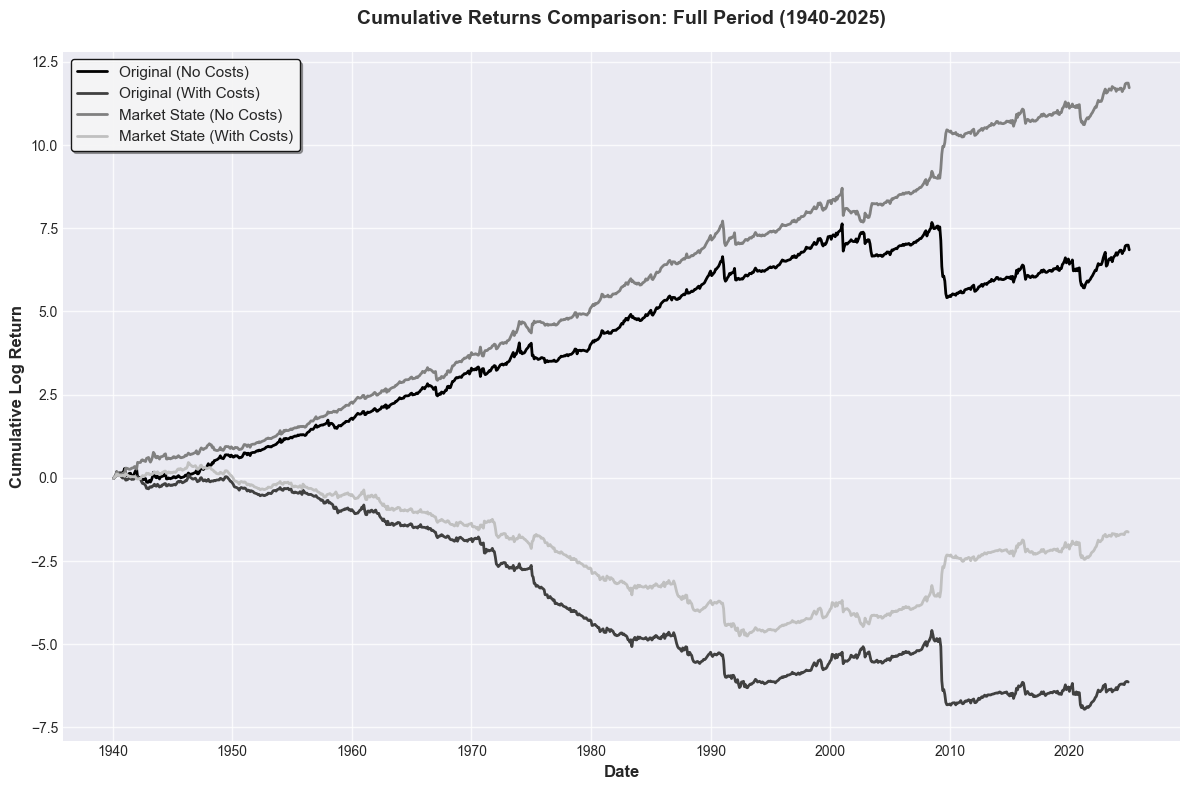

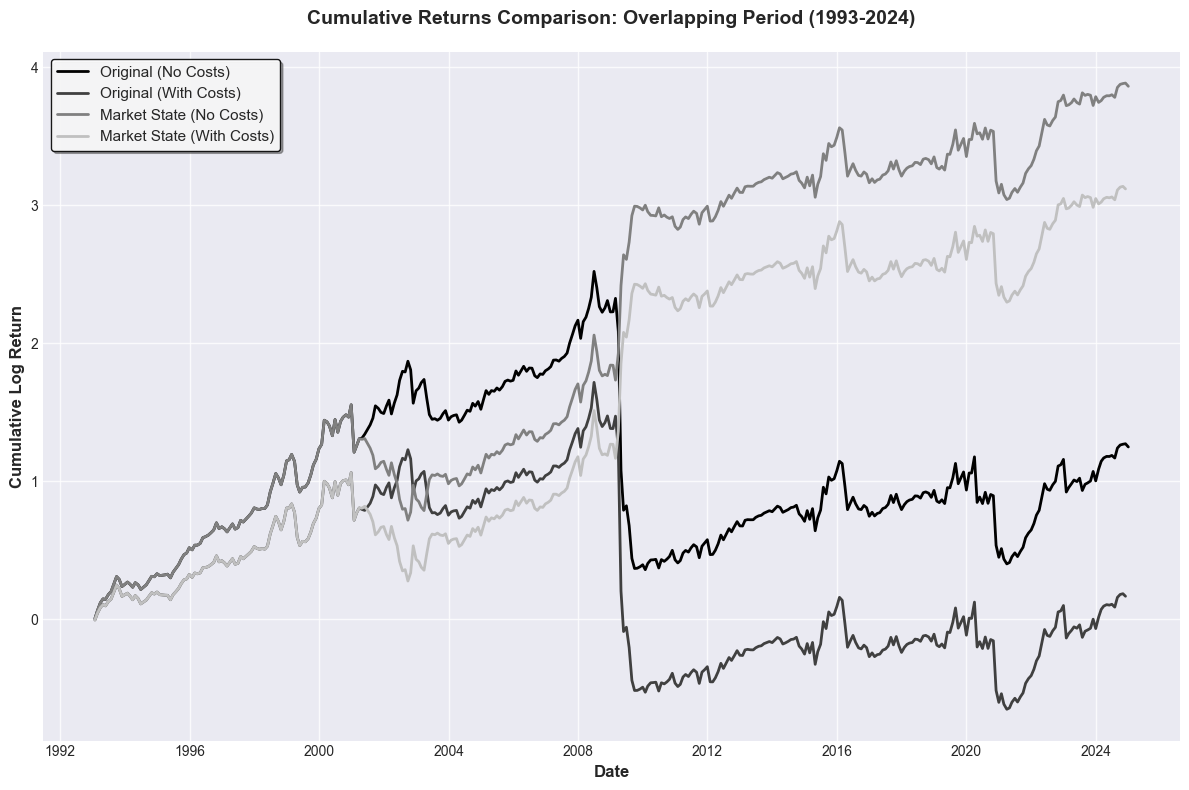

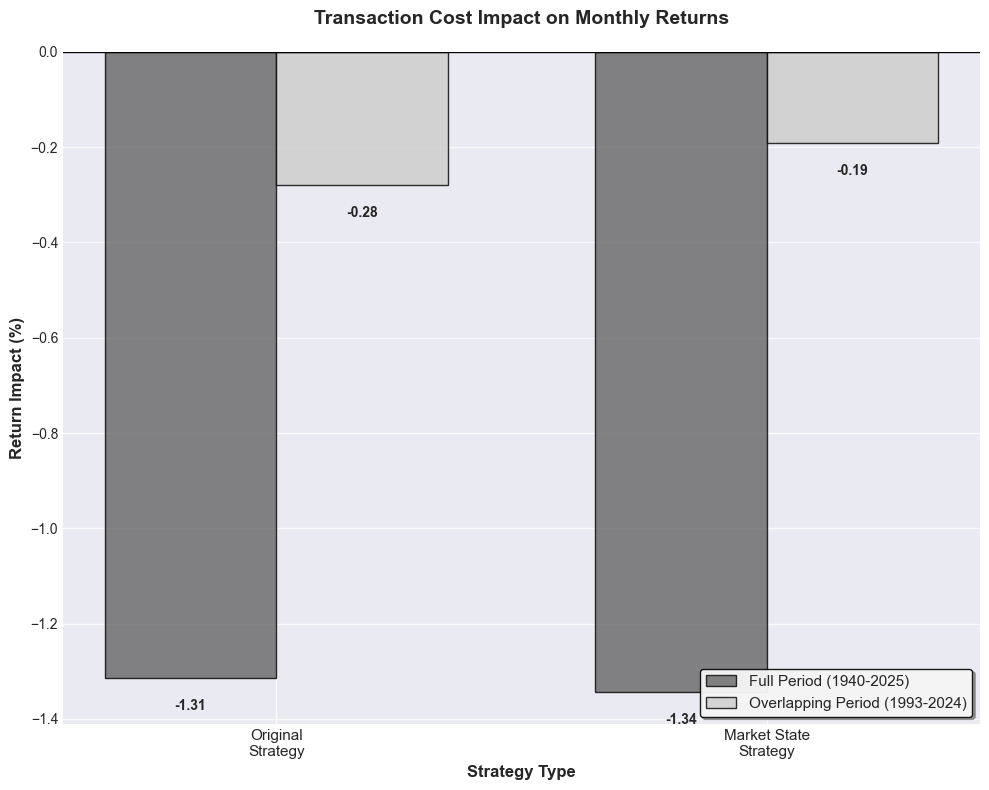

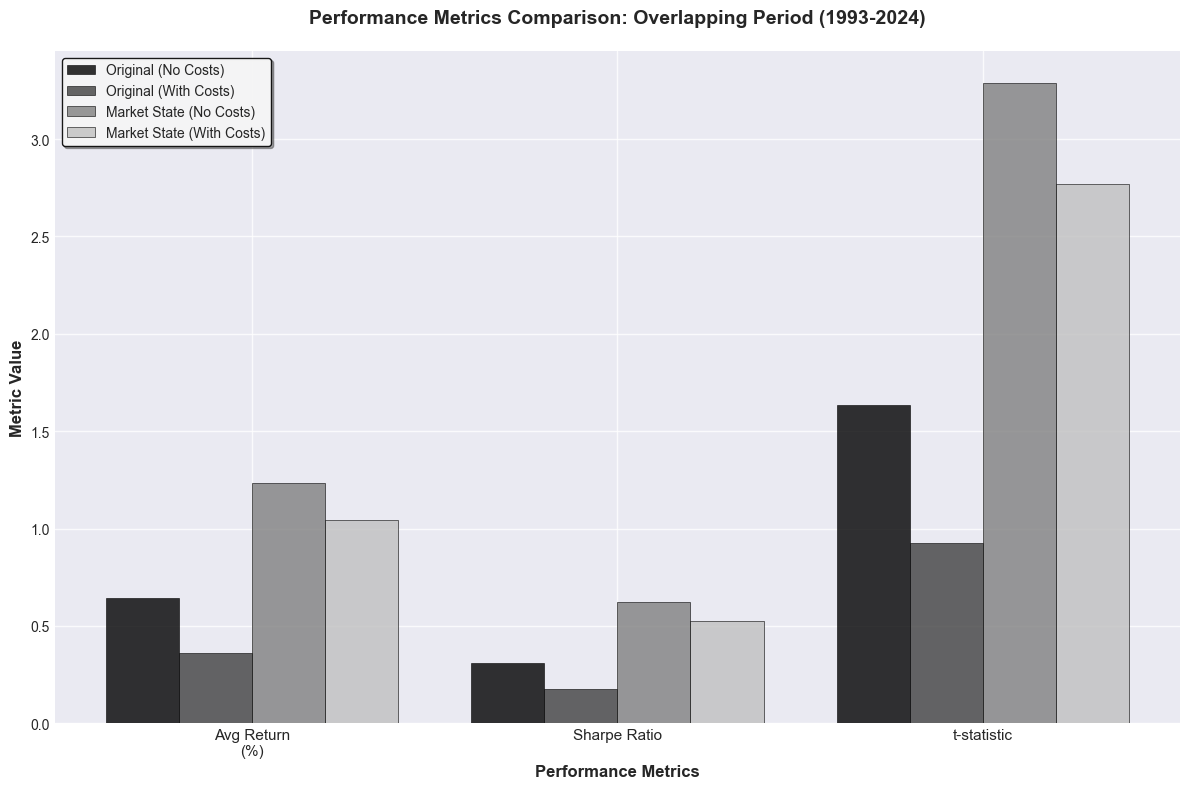


Full Period Strategy Comparison:
                 Strategy  Avg Monthly Return  Sharpe Ratio  t-statistic  Cost Impact
      Original (No Costs)               0.928         0.486        4.446        0.000
    Original (With Costs)              -0.387        -0.219       -1.967       -1.314
  Market State (No Costs)               1.357         0.755        6.895        0.000
Market State (With Costs)               0.014         0.008        0.070       -1.344

Overlapping Period Strategy Comparison (1993-2024):
                 Strategy  Avg Monthly Return  Sharpe Ratio  t-statistic  Cost Impact
      Original (No Costs)               0.643         0.309        1.633        0.000
    Original (With Costs)               0.364         0.175        0.924       -0.279
  Market State (No Costs)               1.234         0.623        3.289        0.000
Market State (With Costs)               1.042         0.524        2.768       -0.192

STRATEGY COMPARISON ANALYSIS COMPLETE
Individual plo

In [12]:
# ============================================================================
# CELL 6: ANALYSIS 5 - ORIGINAL VS NEW STRATEGY WITH COSTS
# ============================================================================
"""
Analysis 5: Comparing Original Momentum vs Market State Strategy
Both with full transaction costs
Academic formatting with grayscale plots and proper LaTeX tables
"""
# Run standard parameters
J, K, LIQ_CUTOFF = 9, 3, 0.80

# Run strategy
port_costs, state_map = run_momentum_strategy(
    crsp_stock_data, 
    crsp_index_data, 
    comm_map,
    J=J, 
    K=K, 
    LIQ_CUTOFF=LIQ_CUTOFF,
    MKT_CAP_CUTOFF=1,
    market_state_lag=24,
    market_state_column='vwretd',
    transactional_framework=True,
    equal_comparision=True
)

# ============================================================================
# LATEX FORMATTING FUNCTIONS
# ============================================================================

def format_percentage_latex(value):
    """Format percentage values for LaTeX with proper escaping"""
    return f"{value:.2f}\\%"

def format_float_latex(value, decimals=3):
    """Format float values for LaTeX"""
    return f"{value:.{decimals}f}"

def create_latex_table(df, caption, label, column_format=None):
    """Create properly formatted LaTeX table"""
    if column_format is None:
        column_format = 'l' + 'c' * (len(df.columns) - 1)
    
    latex_output = df.to_latex(
        index=False,
        escape=False,  # We handle escaping manually
        column_format=column_format,
        caption=caption,
        label=label,
        position='htbp'
    )
    
    # Enhance LaTeX formatting
    latex_output = latex_output.replace('\\toprule', '\\hline')
    latex_output = latex_output.replace('\\midrule', '\\hline') 
    latex_output = latex_output.replace('\\bottomrule', '\\hline')
    
    # Make headers bold
    lines = latex_output.split('\n')
    enhanced_lines = []
    
    for line in lines:
        if any(col in line for col in df.columns):
            # Add bold to column headers
            for col in df.columns:
                line = line.replace(col, f'\\textbf{{{col}}}')
            break
    
    # Rejoin lines
    latex_output = '\n'.join(lines)
    
    return latex_output

def add_academic_grid(ax):
    """Add consistent academic-style grid to plot"""
    ax.grid(True, alpha=0.8, linewidth=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# ============================================================================
# ANALYZE STRATEGIES FOR FULL PERIOD
# ============================================================================

# Analyze both strategies with costs
analysis_original_costs = analyze_momentum_portfolio(
    port_costs, 
    state_map,
    return_column='RET_S2',  # Original with costs
    K=K
)

analysis_market_costs = analyze_momentum_portfolio(
    port_costs, 
    state_map,
    return_column='RET_S3',  # Market state with costs
    K=K
)

# Print summaries
print("\nOriginal Momentum WITH Transaction Costs:")
print_portfolio_summary(analysis_original_costs, "Original Momentum (With Costs)")

print("\nMarket State Strategy WITH Transaction Costs:")
print_portfolio_summary(analysis_market_costs, "Market State Strategy (With Costs)")

# ============================================================================
# ANALYZE STRATEGIES FOR OVERLAPPING PERIOD (1993-2024)
# ============================================================================

print("\n" + "=" * 60)
print("ANALYSIS FOR OVERLAPPING PERIOD (1993-2024)")
print("=" * 60)

# Analyze strategies for overlapping period
analysis_original_overlap = analyze_momentum_portfolio(
    port_costs, 
    state_map,
    start_date='1993-01-01',
    end_date='2024-12-31',
    return_column='RET_S0',  # Original without costs
    K=K
)

analysis_original_costs_overlap = analyze_momentum_portfolio(
    port_costs, 
    state_map,
    start_date='1993-01-01',
    end_date='2024-12-31',
    return_column='RET_S2',  # Original with costs
    K=K
)

analysis_market_overlap = analyze_momentum_portfolio(
    port_costs, 
    state_map,
    start_date='1993-01-01',
    end_date='2024-12-31',
    return_column='RET_S1',  # Market state without costs
    K=K
)

analysis_market_costs_overlap = analyze_momentum_portfolio(
    port_costs, 
    state_map,
    start_date='1993-01-01',
    end_date='2024-12-31',
    return_column='RET_S3',  # Market state with costs
    K=K
)

print("\nOverlapping Period Analysis (1993-2024):")
print("Original Momentum WITHOUT Transaction Costs:")
print_portfolio_summary(analysis_original_overlap, "Original (No Costs, 1993-2024)")

print("\nOriginal Momentum WITH Transaction Costs:")
print_portfolio_summary(analysis_original_costs_overlap, "Original (With Costs, 1993-2024)")

print("\nMarket State Strategy WITHOUT Transaction Costs:")
print_portfolio_summary(analysis_market_overlap, "Market State (No Costs, 1993-2024)")

print("\nMarket State Strategy WITH Transaction Costs:")
print_portfolio_summary(analysis_market_costs_overlap, "Market State (With Costs, 1993-2024)")

# ============================================================================
# CALCULATE TRANSACTION COST IMPACTS (CORRECTED)
# ============================================================================

# Full period cost impacts (with costs - without costs = negative impact)
cost_impact_original_full = (analysis_original_costs['avg_monthly_return'] - 
                            analysis_original['avg_monthly_return']) * 100

cost_impact_market_full = (analysis_market_costs['avg_monthly_return'] - 
                          analysis_market_state['avg_monthly_return']) * 100

# Overlapping period cost impacts
cost_impact_original_overlap = (analysis_original_costs_overlap['avg_monthly_return'] - 
                               analysis_original_overlap['avg_monthly_return']) * 100

cost_impact_market_overlap = (analysis_market_costs_overlap['avg_monthly_return'] - 
                             analysis_market_overlap['avg_monthly_return']) * 100

print(f"\nTransaction Cost Impacts:")
print(f"Full Period:")
print(f"  Original Strategy: {cost_impact_original_full:.2f}% per month")
print(f"  Market State Strategy: {cost_impact_market_full:.2f}% per month")
print(f"Overlapping Period (1993-2024):")
print(f"  Original Strategy: {cost_impact_original_overlap:.2f}% per month")
print(f"  Market State Strategy: {cost_impact_market_overlap:.2f}% per month")

# ============================================================================
# GRAYSCALE ACADEMIC PLOTS
# ============================================================================

# Define grayscale colors and styles
colors = {
    'original_no_costs': '#000000',      # Black
    'original_with_costs': '#404040',    # Dark gray
    'market_no_costs': '#808080',        # Medium gray  
    'market_with_costs': '#C0C0C0'       # Light gray
}

line_styles = {
    'original_no_costs': '-',
    'original_with_costs': '-',
    'market_no_costs': '-',
    'market_with_costs': '-'
}

# ============================================================================
# PLOT 1: CUMULATIVE RETURNS COMPARISON - FULL PERIOD
# ============================================================================

fig1, ax1 = plt.subplots(1, 1, figsize=(12, 8))

ax1.plot(analysis_original['decile_ret'].index, 
         analysis_original['decile_ret']['cum_log_long_short'],
         label='Original (No Costs)', color=colors['original_no_costs'], 
         linestyle=line_styles['original_no_costs'], linewidth=2)
ax1.plot(analysis_original_costs['decile_ret'].index,
         analysis_original_costs['decile_ret']['cum_log_long_short'],
         label='Original (With Costs)', color=colors['original_with_costs'], 
         linestyle=line_styles['original_with_costs'], linewidth=2)
ax1.plot(analysis_market_state['decile_ret'].index,
         analysis_market_state['decile_ret']['cum_log_long_short'],
         label='Market State (No Costs)', color=colors['market_no_costs'], 
         linestyle=line_styles['market_no_costs'], linewidth=2)
ax1.plot(analysis_market_costs['decile_ret'].index,
         analysis_market_costs['decile_ret']['cum_log_long_short'],
         label='Market State (With Costs)', color=colors['market_with_costs'], 
         linestyle=line_styles['market_with_costs'], linewidth=2)

ax1.set_title('Cumulative Returns Comparison: Full Period (1940-2025)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative Log Return', fontsize=12, fontweight='bold')

legend1 = ax1.legend(fontsize=11, frameon=True, fancybox=True, shadow=True,
                    edgecolor='black', facecolor='white', framealpha=0.9)
legend1.get_frame().set_linewidth(1.0)
add_academic_grid(ax1)

plt.tight_layout()
plt.savefig('results/plots/cumulative_returns_full_period.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# PLOT 2: CUMULATIVE RETURNS COMPARISON - OVERLAPPING PERIOD
# ============================================================================

fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8))

ax2.plot(analysis_original_overlap['decile_ret'].index, 
         analysis_original_overlap['decile_ret']['cum_log_long_short'],
         label='Original (No Costs)', color=colors['original_no_costs'], 
         linestyle=line_styles['original_no_costs'], linewidth=2)
ax2.plot(analysis_original_costs_overlap['decile_ret'].index,
         analysis_original_costs_overlap['decile_ret']['cum_log_long_short'],
         label='Original (With Costs)', color=colors['original_with_costs'], 
         linestyle=line_styles['original_with_costs'], linewidth=2)
ax2.plot(analysis_market_overlap['decile_ret'].index,
         analysis_market_overlap['decile_ret']['cum_log_long_short'],
         label='Market State (No Costs)', color=colors['market_no_costs'], 
         linestyle=line_styles['market_no_costs'], linewidth=2)
ax2.plot(analysis_market_costs_overlap['decile_ret'].index,
         analysis_market_costs_overlap['decile_ret']['cum_log_long_short'],
         label='Market State (With Costs)', color=colors['market_with_costs'], 
         linestyle=line_styles['market_with_costs'], linewidth=2)

ax2.set_title('Cumulative Returns Comparison: Overlapping Period (1993-2024)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Log Return', fontsize=12, fontweight='bold')

legend2 = ax2.legend(fontsize=11, frameon=True, fancybox=True, shadow=True,
                    edgecolor='black', facecolor='white', framealpha=0.9)
legend2.get_frame().set_linewidth(1.0)
add_academic_grid(ax2)

plt.tight_layout()
plt.savefig('results/plots/cumulative_returns_overlap_period.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# PLOT 3: TRANSACTION COST IMPACT COMPARISON
# ============================================================================

fig3, ax3 = plt.subplots(1, 1, figsize=(10, 8))

strategies = ['Original\nStrategy', 'Market State\nStrategy']
full_impacts = [cost_impact_original_full, cost_impact_market_full]
overlap_impacts = [cost_impact_original_overlap, cost_impact_market_overlap]

x = np.arange(len(strategies))
width = 0.35

bars1 = ax3.bar(x - width/2, full_impacts, width, label='Full Period (1940-2025)',
                color='#666666', alpha=0.8, edgecolor='black', linewidth=1)
bars2 = ax3.bar(x + width/2, overlap_impacts, width, label='Overlapping Period (1993-2024)',
                color='#CCCCCC', alpha=0.8, edgecolor='black', linewidth=1)

ax3.set_title('Transaction Cost Impact on Monthly Returns', 
              fontsize=14, fontweight='bold', pad=20)
ax3.set_ylabel('Return Impact (%)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Strategy Type', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(strategies, fontsize=11)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)

legend3 = ax3.legend(fontsize=11, frameon=True, fancybox=True, shadow=True,
                    edgecolor='black', facecolor='white', framealpha=0.9)
legend3.get_frame().set_linewidth(1.0)
add_academic_grid(ax3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height >= 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('results/plots/transaction_cost_impact.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# PLOT 4: PERFORMANCE METRICS COMPARISON - OVERLAPPING PERIOD
# ============================================================================

fig4, ax4 = plt.subplots(1, 1, figsize=(12, 8))

categories = ['Avg Return\n(%)', 'Sharpe Ratio', 't-statistic']

original_no_costs = [
    analysis_original_overlap['avg_monthly_return'] * 100,
    analysis_original_overlap['sharpe_ratio'],
    analysis_original_overlap['t_stat']
]

original_with_costs = [
    analysis_original_costs_overlap['avg_monthly_return'] * 100,
    analysis_original_costs_overlap['sharpe_ratio'],
    analysis_original_costs_overlap['t_stat']
]

market_no_costs = [
    analysis_market_overlap['avg_monthly_return'] * 100,
    analysis_market_overlap['sharpe_ratio'],
    analysis_market_overlap['t_stat']
]

market_with_costs = [
    analysis_market_costs_overlap['avg_monthly_return'] * 100,
    analysis_market_costs_overlap['sharpe_ratio'],
    analysis_market_costs_overlap['t_stat']
]

x = np.arange(len(categories))
width = 0.2

bars1 = ax4.bar(x - 1.5*width, original_no_costs, width, label='Original (No Costs)',
                color='#000000', alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = ax4.bar(x - 0.5*width, original_with_costs, width, label='Original (With Costs)',
                color='#404040', alpha=0.8, edgecolor='black', linewidth=0.5)
bars3 = ax4.bar(x + 0.5*width, market_no_costs, width, label='Market State (No Costs)',
                color='#808080', alpha=0.8, edgecolor='black', linewidth=0.5)
bars4 = ax4.bar(x + 1.5*width, market_with_costs, width, label='Market State (With Costs)',
                color='#C0C0C0', alpha=0.8, edgecolor='black', linewidth=0.5)

ax4.set_title('Performance Metrics Comparison: Overlapping Period (1993-2024)', 
              fontsize=14, fontweight='bold', pad=20)
ax4.set_xlabel('Performance Metrics', fontsize=12, fontweight='bold')
ax4.set_ylabel('Metric Value', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(categories, fontsize=11)

legend4 = ax4.legend(fontsize=10, frameon=True, fancybox=True, shadow=True,
                    edgecolor='black', facecolor='white', framealpha=0.9)
legend4.get_frame().set_linewidth(1.0)
add_academic_grid(ax4)

plt.tight_layout()
plt.savefig('results/plots/performance_metrics_comparison.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# CREATE COMPREHENSIVE COMPARISON TABLES
# ============================================================================

# Full period comparison table
full_period_data = {
    'Strategy': ['Original (No Costs)', 'Original (With Costs)', 
                 'Market State (No Costs)', 'Market State (With Costs)'],
    'Avg Monthly Return': [
        analysis_original['avg_monthly_return']*100,
        analysis_original_costs['avg_monthly_return']*100,
        analysis_market_state['avg_monthly_return']*100,
        analysis_market_costs['avg_monthly_return']*100
    ],
    'Sharpe Ratio': [
        analysis_original['sharpe_ratio'],
        analysis_original_costs['sharpe_ratio'],
        analysis_market_state['sharpe_ratio'],
        analysis_market_costs['sharpe_ratio']
    ],
    't-statistic': [
        analysis_original['t_stat'],
        analysis_original_costs['t_stat'],
        analysis_market_state['t_stat'],
        analysis_market_costs['t_stat']
    ],
    'Cost Impact': [
        0,  # No costs baseline
        cost_impact_original_full,
        0,  # No costs baseline
        cost_impact_market_full
    ]
}

# Overlapping period comparison table
overlap_period_data = {
    'Strategy': ['Original (No Costs)', 'Original (With Costs)', 
                 'Market State (No Costs)', 'Market State (With Costs)'],
    'Avg Monthly Return': [
        analysis_original_overlap['avg_monthly_return']*100,
        analysis_original_costs_overlap['avg_monthly_return']*100,
        analysis_market_overlap['avg_monthly_return']*100,
        analysis_market_costs_overlap['avg_monthly_return']*100
    ],
    'Sharpe Ratio': [
        analysis_original_overlap['sharpe_ratio'],
        analysis_original_costs_overlap['sharpe_ratio'],
        analysis_market_overlap['sharpe_ratio'],
        analysis_market_costs_overlap['sharpe_ratio']
    ],
    't-statistic': [
        analysis_original_overlap['t_stat'],
        analysis_original_costs_overlap['t_stat'],
        analysis_market_overlap['t_stat'],
        analysis_market_costs_overlap['t_stat']
    ],
    'Cost Impact': [
        0,  # No costs baseline
        cost_impact_original_overlap,
        0,  # No costs baseline
        cost_impact_market_overlap
    ]
}

# Create DataFrames
full_comparison_df = pd.DataFrame(full_period_data)
overlap_comparison_df = pd.DataFrame(overlap_period_data)

# Display tables
print("\nFull Period Strategy Comparison:")
print(full_comparison_df.round(3).to_string(index=False))

print("\nOverlapping Period Strategy Comparison (1993-2024):")
print(overlap_comparison_df.round(3).to_string(index=False))

# Format for LaTeX - Full Period
full_latex_df = full_comparison_df.copy()
full_latex_df['Avg Monthly Return (\\%)'] = full_latex_df['Avg Monthly Return'].apply(format_percentage_latex)
full_latex_df['Sharpe Ratio'] = full_latex_df['Sharpe Ratio'].apply(lambda x: format_float_latex(x, 3))
full_latex_df['t-statistic'] = full_latex_df['t-statistic'].apply(lambda x: format_float_latex(x, 3))
full_latex_df['Cost Impact (\\%)'] = full_latex_df['Cost Impact'].apply(
    lambda x: "N/A" if x == 0 else format_percentage_latex(x)
)
full_latex_df = full_latex_df.drop(['Avg Monthly Return', 'Cost Impact'], axis=1)

# Format for LaTeX - Overlapping Period
overlap_latex_df = overlap_comparison_df.copy()
overlap_latex_df['Avg Monthly Return (\\%)'] = overlap_latex_df['Avg Monthly Return'].apply(format_percentage_latex)
overlap_latex_df['Sharpe Ratio'] = overlap_latex_df['Sharpe Ratio'].apply(lambda x: format_float_latex(x, 3))
overlap_latex_df['t-statistic'] = overlap_latex_df['t-statistic'].apply(lambda x: format_float_latex(x, 3))
overlap_latex_df['Cost Impact (\\%)'] = overlap_latex_df['Cost Impact'].apply(
    lambda x: "N/A" if x == 0 else format_percentage_latex(x)
)
overlap_latex_df = overlap_latex_df.drop(['Avg Monthly Return', 'Cost Impact'], axis=1)

# Save CSV files
full_comparison_df.to_csv('results/tables/comprehensive_comparison_full_period.csv', index=False)
overlap_comparison_df.to_csv('results/tables/comprehensive_comparison_overlap_period.csv', index=False)

# Create and save LaTeX tables
full_latex_table = create_latex_table(
    full_latex_df,
    caption='Strategy Performance Comparison: Full Period (1940-2025)',
    label='tab:strategy_comparison_full',
    column_format='l|cccc'
)

overlap_latex_table = create_latex_table(
    overlap_latex_df,
    caption='Strategy Performance Comparison: Overlapping Period (1993-2024)',
    label='tab:strategy_comparison_overlap',
    column_format='l|cccc'
)

with open('results/tables/comprehensive_comparison_full_period.tex', 'w') as f:
    f.write(full_latex_table)

with open('results/tables/comprehensive_comparison_overlap_period.tex', 'w') as f:
    f.write(overlap_latex_table)

print("\n" + "=" * 80)
print("STRATEGY COMPARISON ANALYSIS COMPLETE")
print("Individual plots saved:")
print("- results/plots/cumulative_returns_full_period.png")
print("- results/plots/cumulative_returns_overlap_period.png")
print("- results/plots/transaction_cost_impact.png")
print("- results/plots/performance_metrics_comparison.png")
print("Tables saved:")
print("- results/tables/comprehensive_comparison_full_period.csv")
print("- results/tables/comprehensive_comparison_overlap_period.csv")
print("- results/tables/comprehensive_comparison_full_period.tex")
print("- results/tables/comprehensive_comparison_overlap_period.tex")
print("=" * 80)

# ============================================================================
# ANALYSIS 6 - MARKET CAP AND LIQUIDITY CONSTRAINTS GRID SEARCH
# ============================================================================


ANALYSIS 6: MARKET CAP AND LIQUIDITY CONSTRAINTS GRID SEARCH
Testing 6 liquidity values × 6 market cap values
Total combinations: 36

Processing LIQUIDITY = 100%

[1/36] MKT_CAP = 35%, LIQ = 100%

IMPLEMENTING MOMENTUM STRATEGY WITH MARKET CAP CONSTRAINTS
Parameters: J=9, K=3, LIQ=1.0, MKT_CAP=0.35

[1/8] Merging market capitalization data...
   ✓ Market cap data available for 1,784,979 observations

[2/8] Computing holding period (3-month) spreads...

[3/8] Calculating 9-month formation period returns...

[4/8] Applying market cap (≤35%) and liquidity filters...
   ✓ Market cap filter: 760,751 → 265,757 (65.1% removed)
   ✓ Liquidity filter: 265,757 → 265,757 (0.0% removed)

[5/8] Forming momentum deciles within size segment...
   ✓ Average stocks per decile:
      Decile  1:   25.3 stocks
      Decile  2:   25.0 stocks
      Decile  3:   24.9 stocks
      Decile  4:   25.0 stocks
      Decile  5:   25.0 stocks
      Decile  6:   24.9 stocks
      Decile  7:   24.9 stocks
      Decil

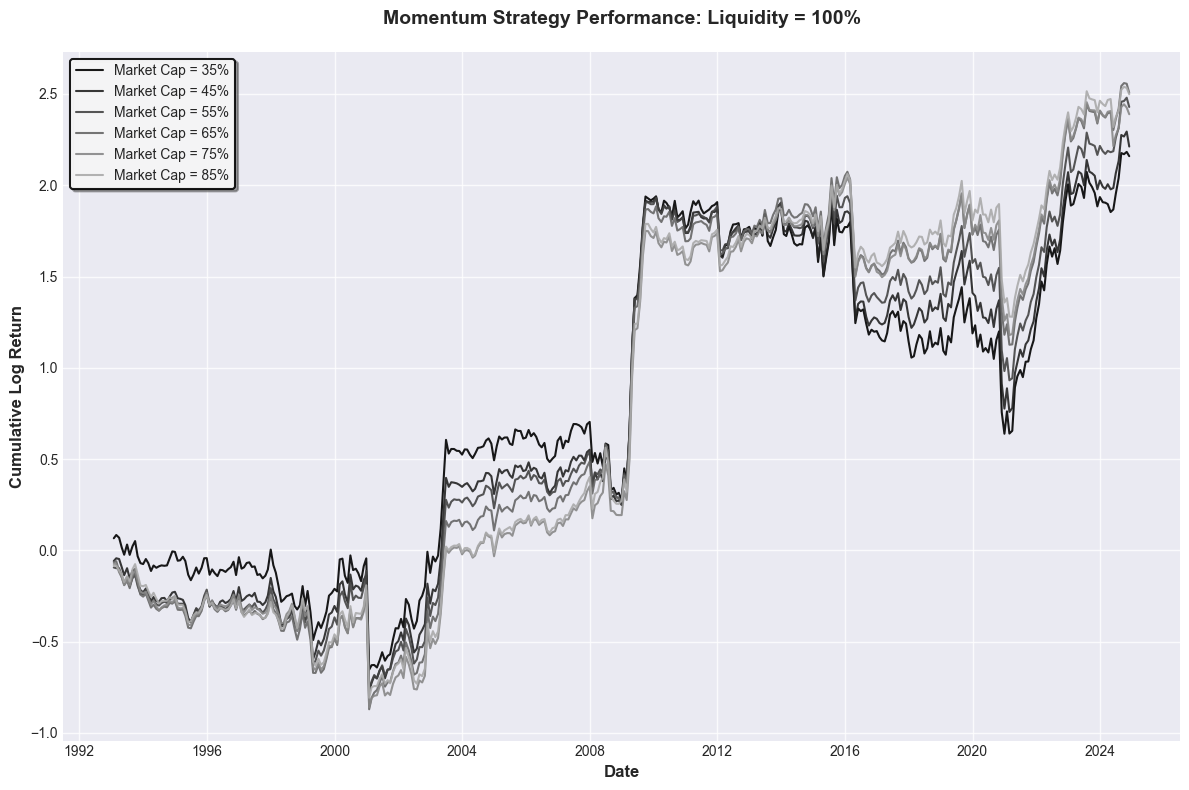

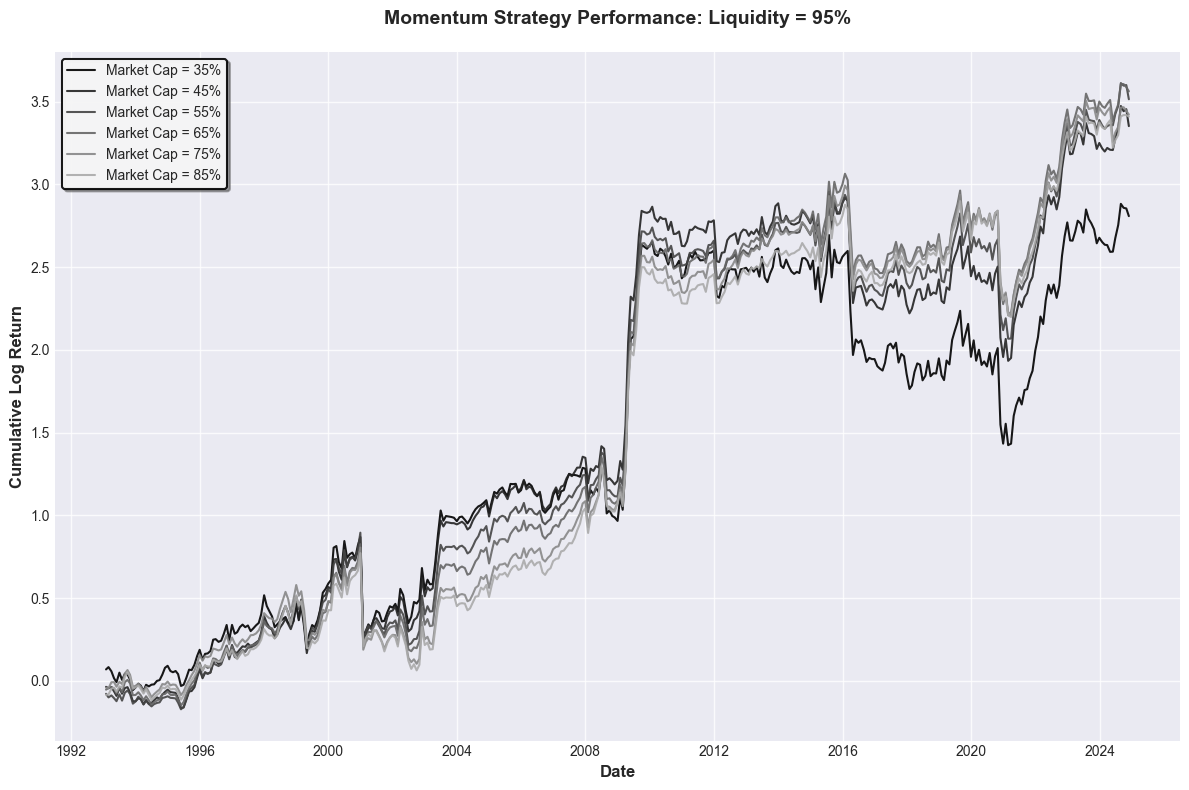

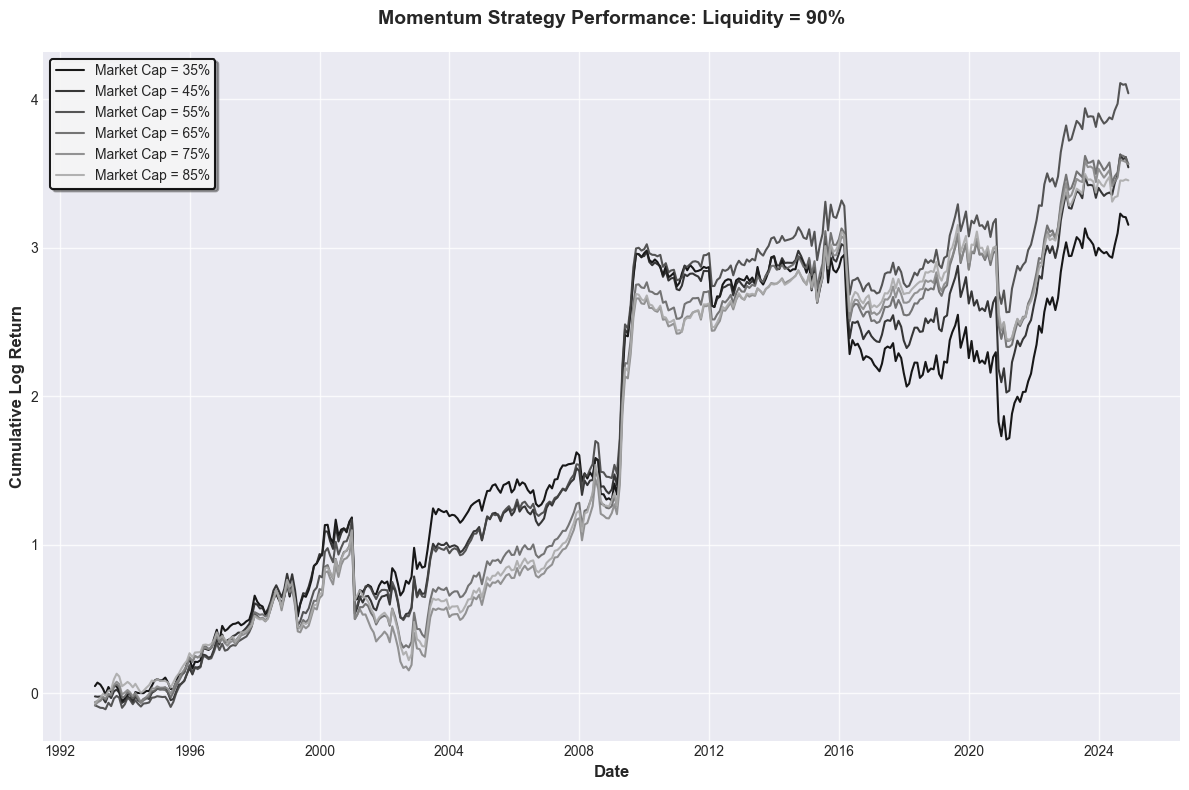

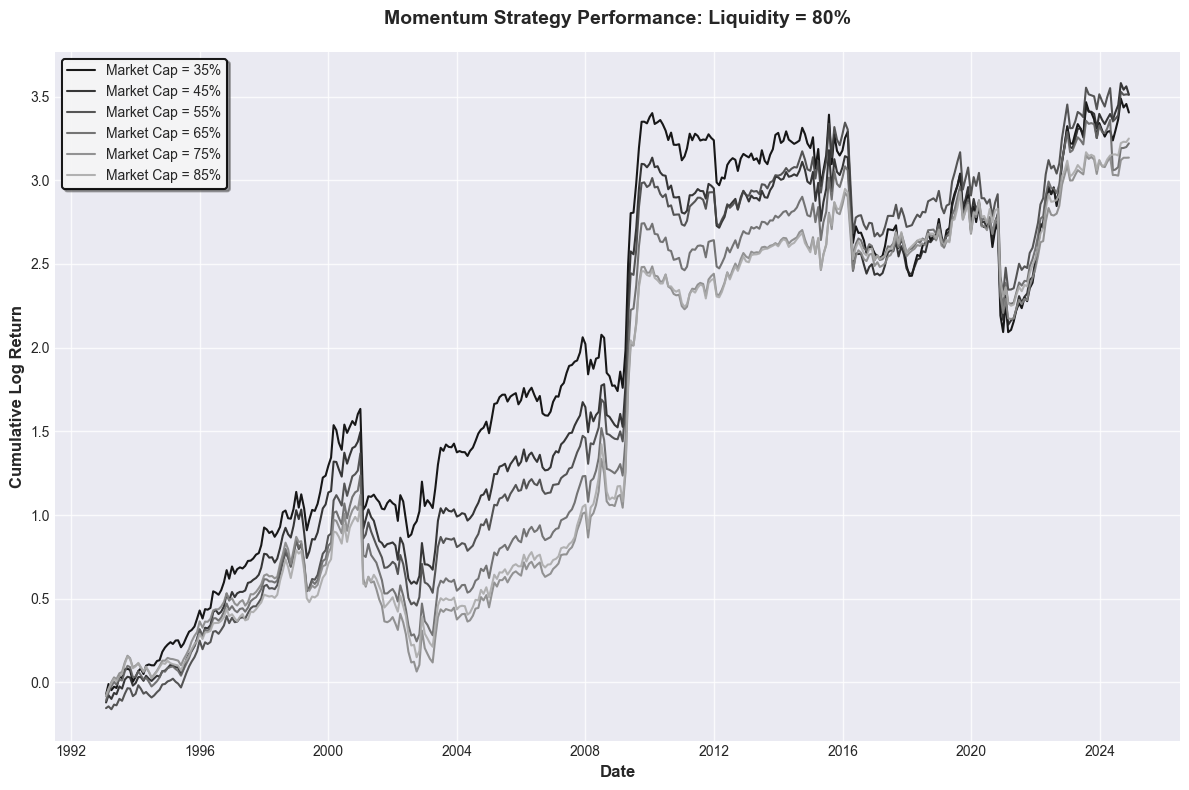

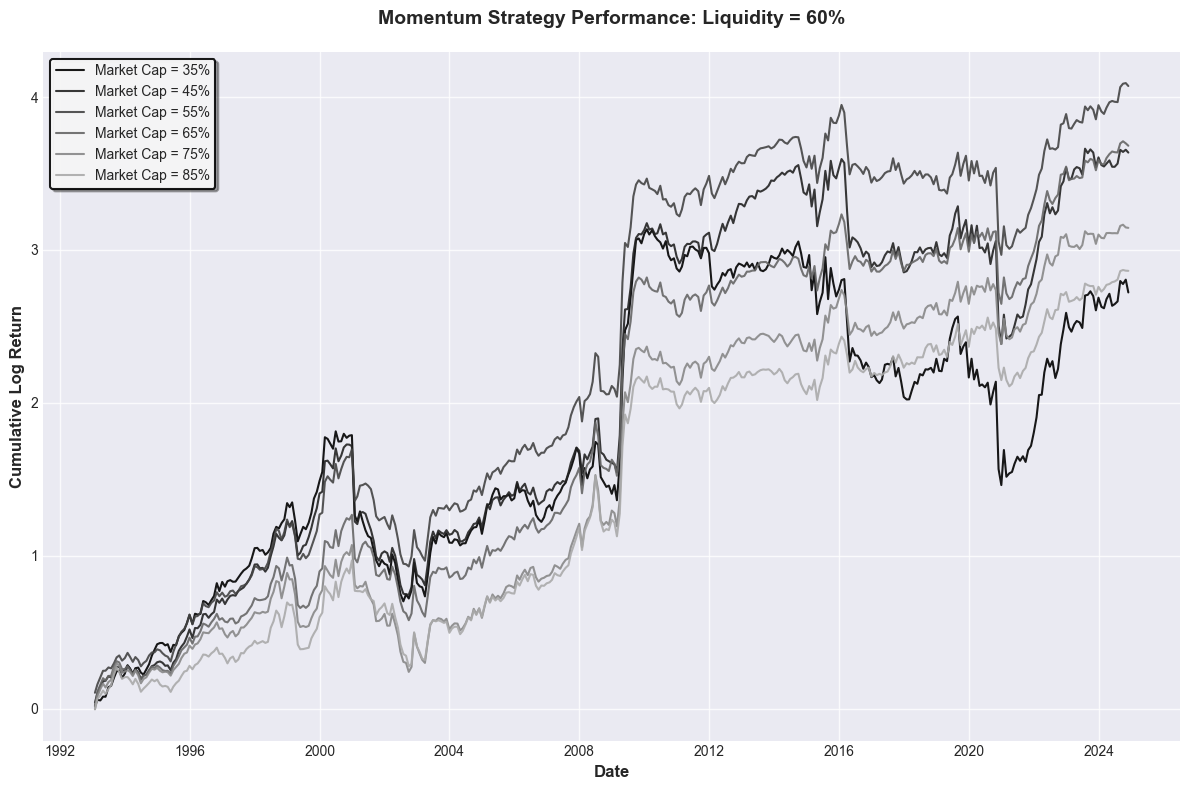

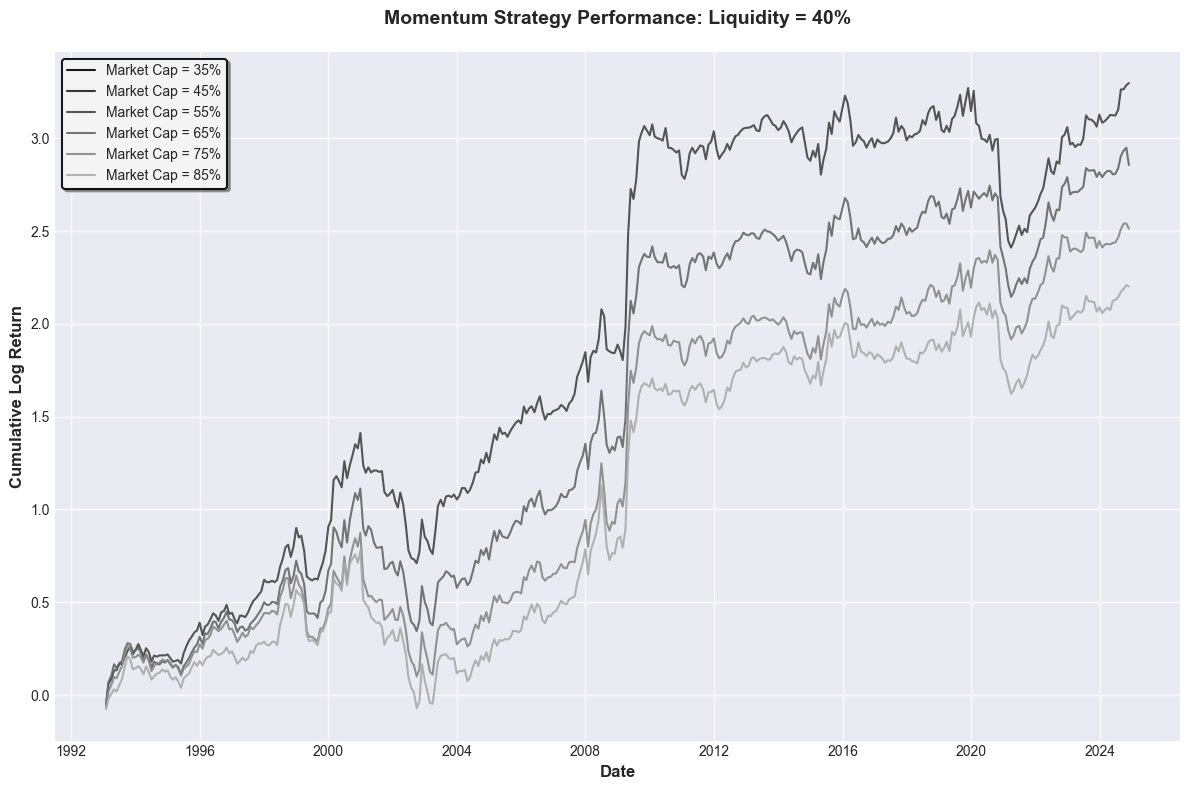


Creating best combinations plot...


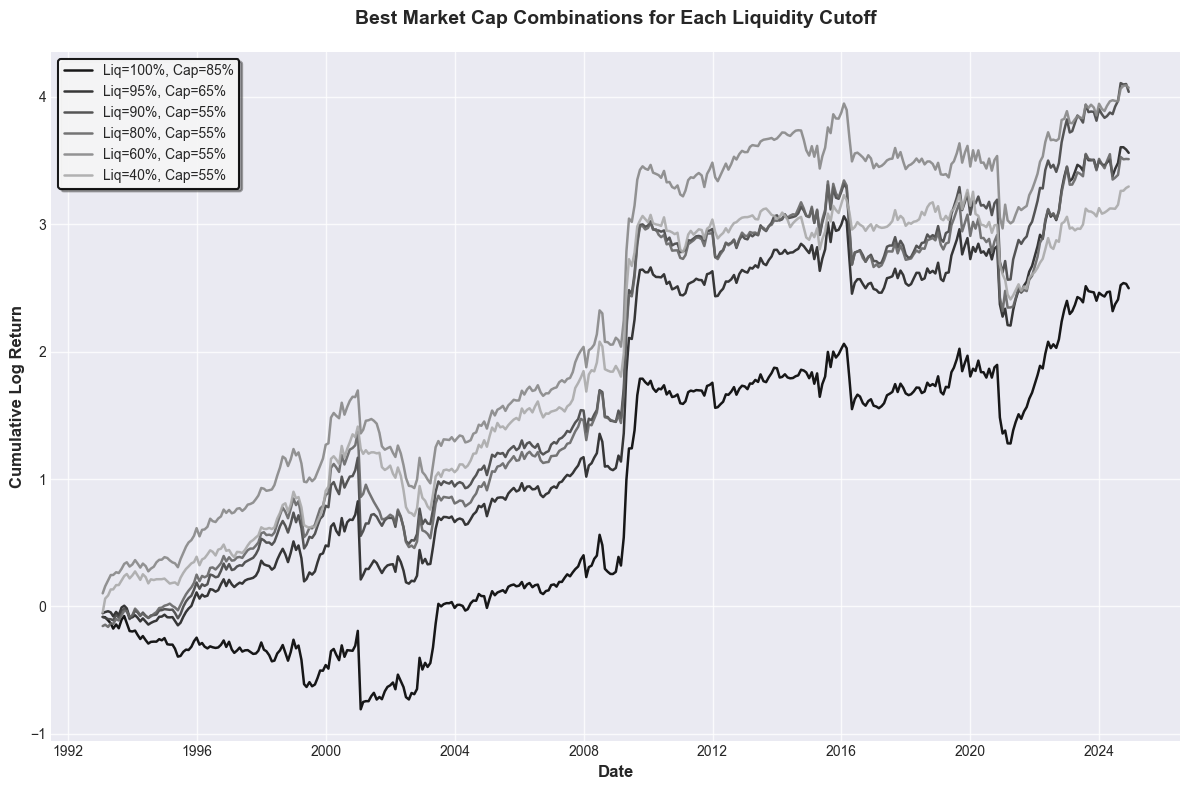


Creating combined plot for all liquidity cutoffs...


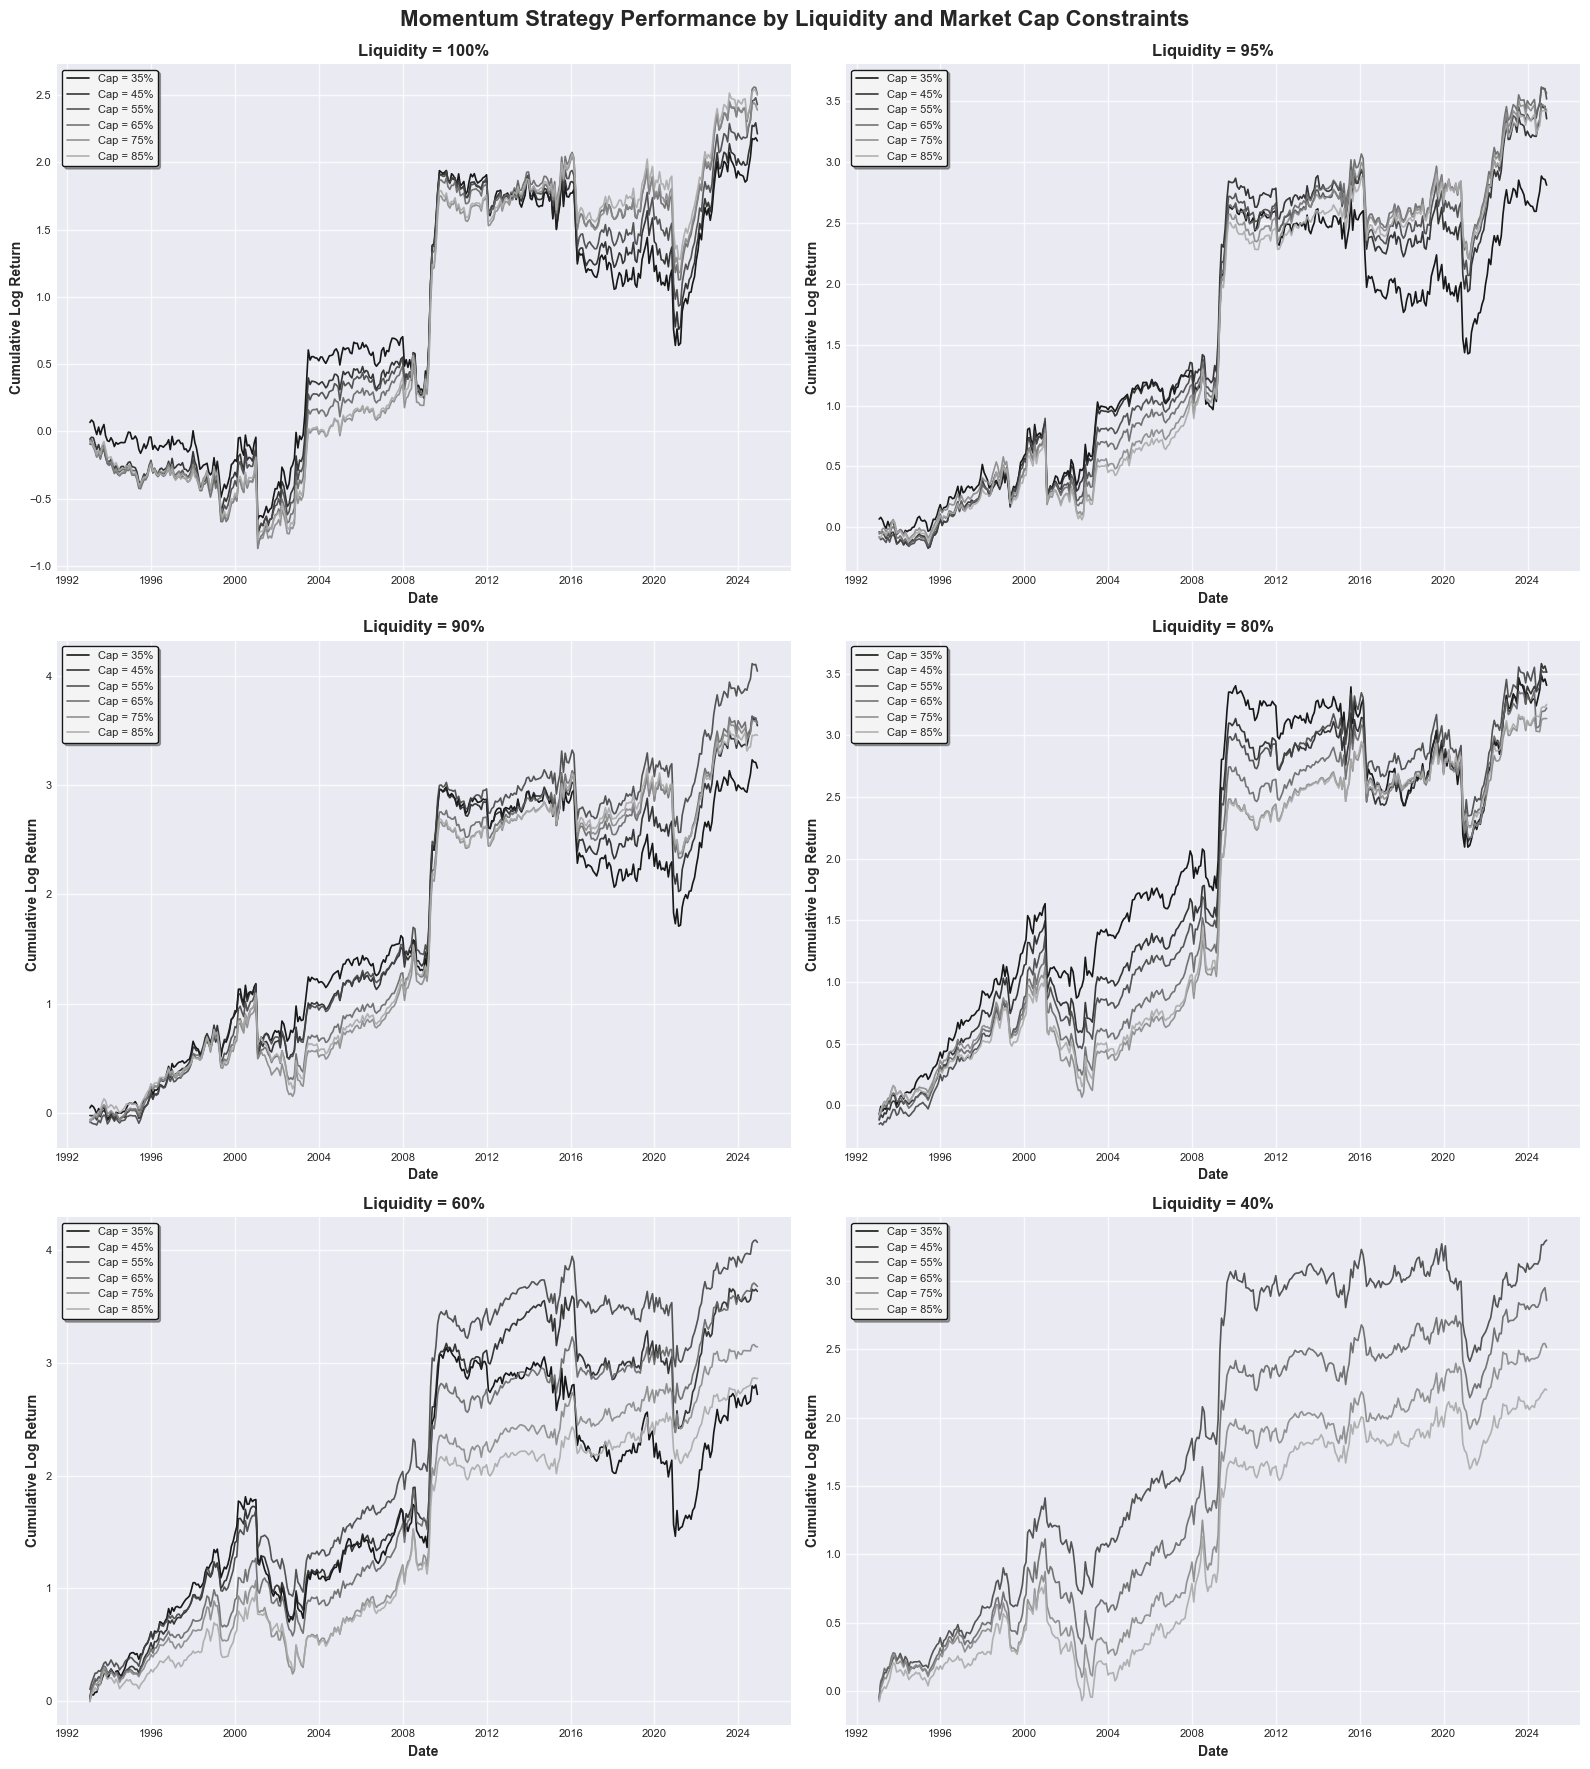


Creating individual heatmaps...


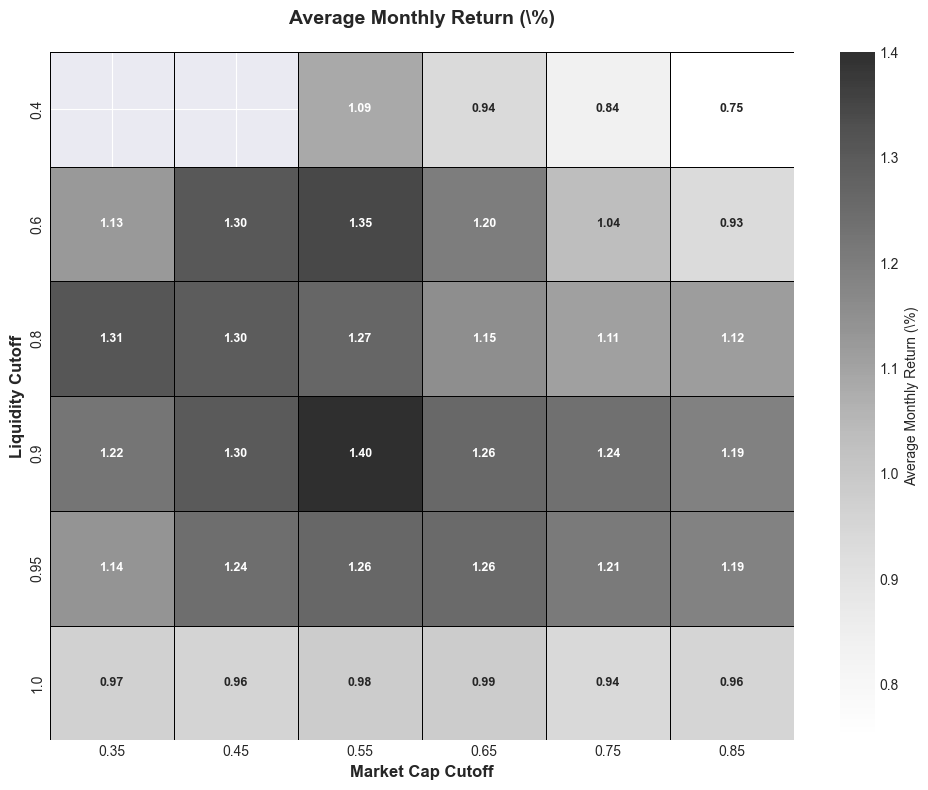

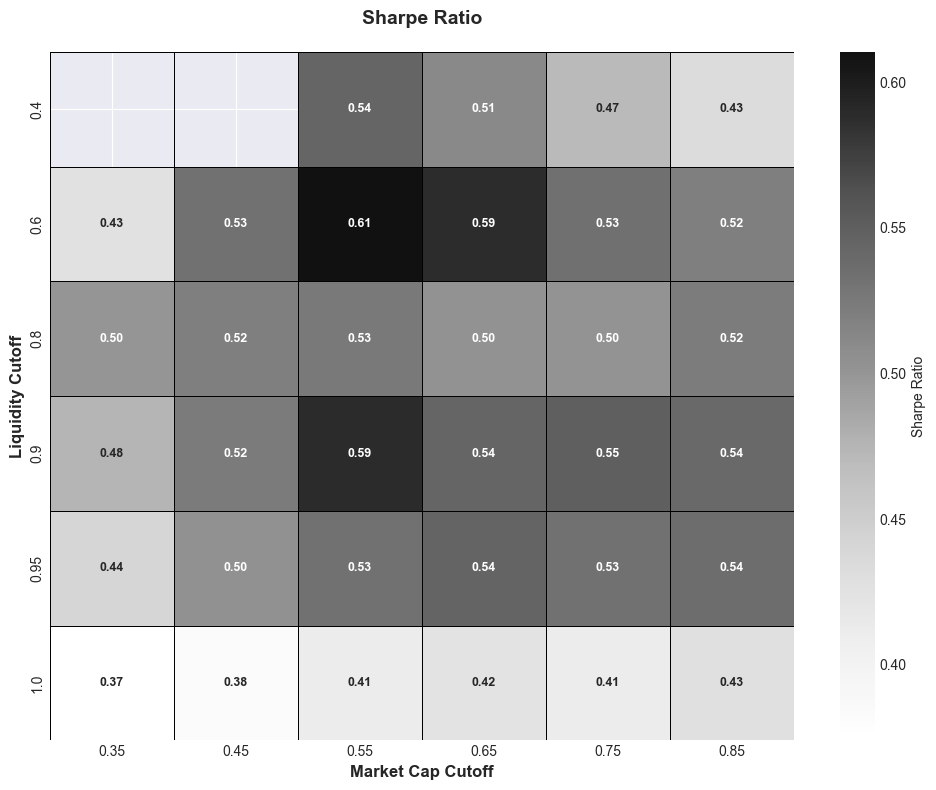

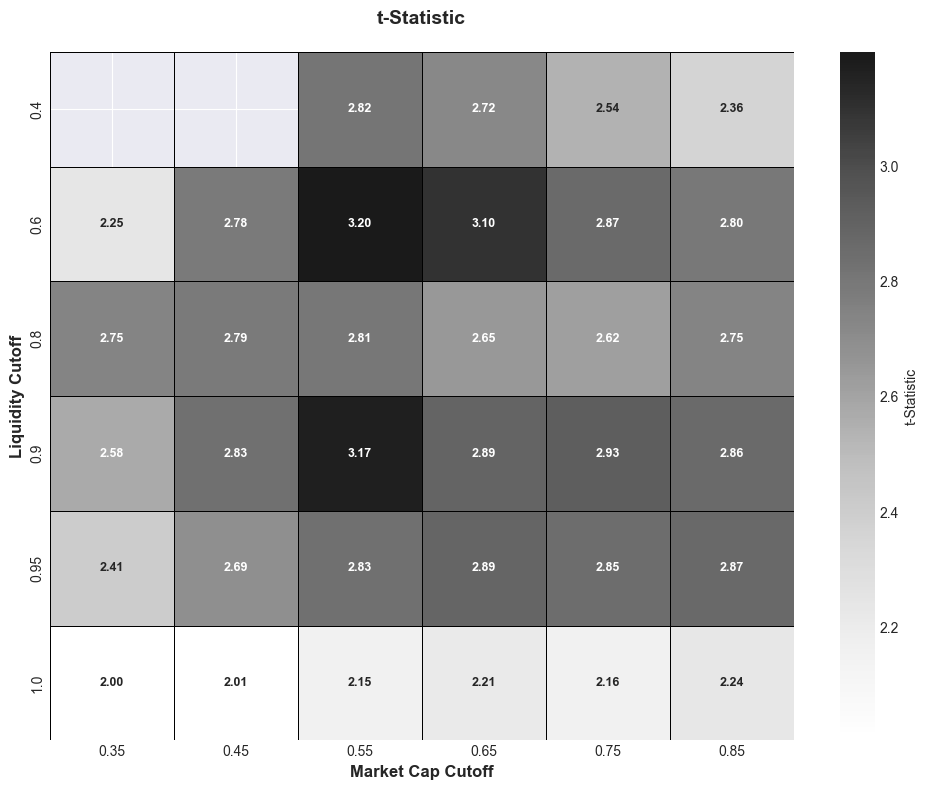

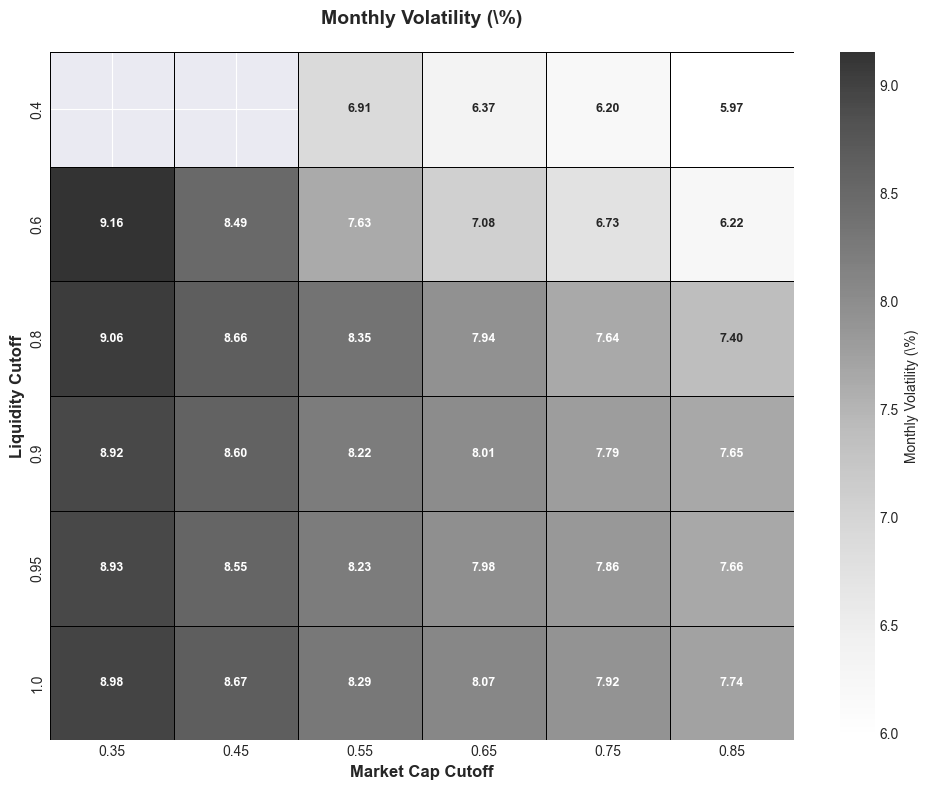

c:\Users\rodon\Arnau Rodon\Personal\Projects\analysis\market_state_momentum_venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\rodon\Arnau Rodon\Personal\Projects\analysis\market_state_momentum_venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\rodon\Arnau Rodon\Personal\Projects\analysis\market_state_momentum_venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.draw()
C:\Users\rodon\AppData\Local\Temp\ipykernel_32476\947291576.py:408: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.savefig('results/plots/heatmaps_combined_academic.png',
c:\Users\rodon\Arnau Rodon\Personal\Projects\analysis\market_state_momentum_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) mi

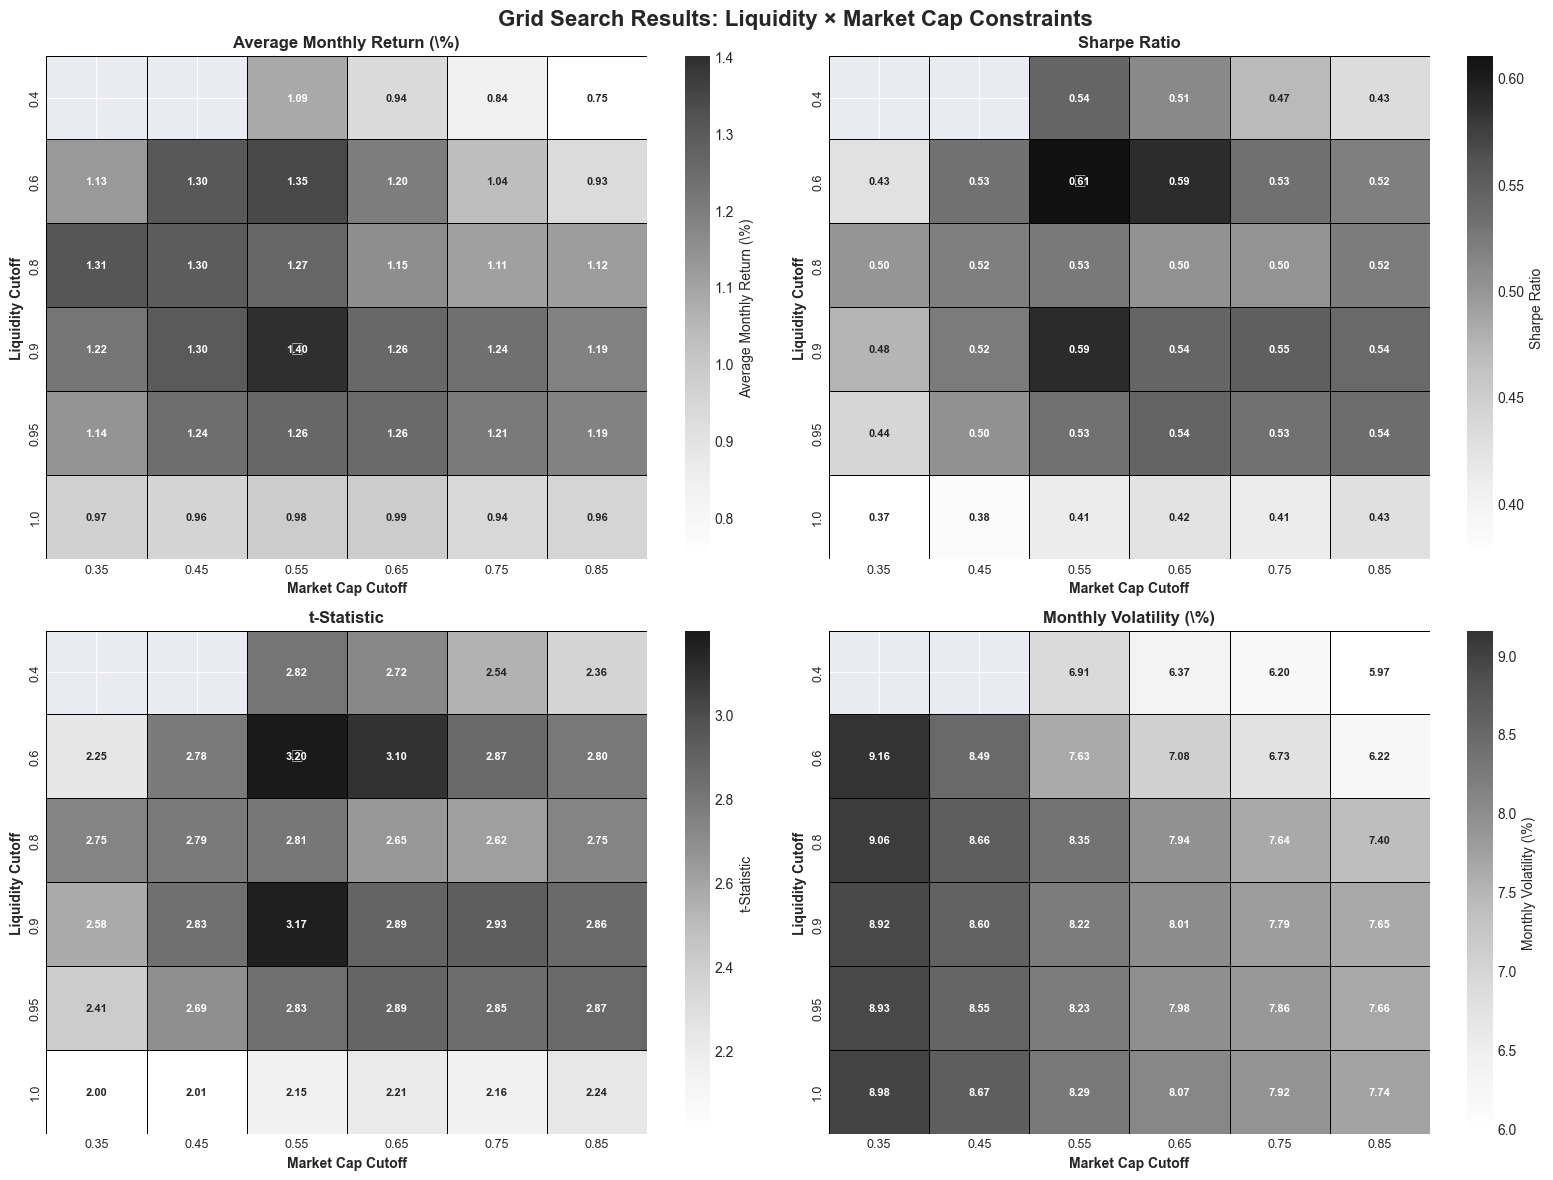


OPTIMAL PARAMETER COMBINATIONS

Best Parameter Combinations:
        Criterion Liquidity Cutoff Market Cap Cutoff  Avg Monthly Return  t-statistic  Sharpe Ratio
   Highest Return              90%               55%               1.401        3.169         0.590
Best Sharpe Ratio              60%               55%               1.345        3.200         0.611
 Best t-Statistic              60%               55%               1.345        3.200         0.611
Lowest Volatility              40%               85%               0.747        2.363         0.434

GRID SEARCH COMPLETE
Total combinations tested: 36
Successful runs: 34
Failed runs: 2

Files saved:
Individual liquidity plots:
  - results/plots/liquidity_100%_mktcap_combinations_academic.png
  - results/plots/liquidity_95%_mktcap_combinations_academic.png
  - results/plots/liquidity_90%_mktcap_combinations_academic.png
  - results/plots/liquidity_80%_mktcap_combinations_academic.png
  - results/plots/liquidity_60%_mktcap_combinati

In [36]:
"""
Analysis 6: Market Capitalization and Liquidity Constraints Grid Analysis
Testing combinations of market cap and liquidity cutoffs to find optimal constraints
Academic formatting with grayscale plots and proper LaTeX tables
"""
print("\n" + "=" * 80)
print("ANALYSIS 6: MARKET CAP AND LIQUIDITY CONSTRAINTS GRID SEARCH")
print("=" * 80)

# Parameters
J = 9
K = 3

# Define parameter grids
liquidity_cutoffs = [1.00, 0.95, 0.90, 0.80, 0.60, 0.40]
cap_cutoff_values = np.arange(0.35, 0.95, 0.10)  # Reduced granularity for efficiency
cap_cutoff_values = [round(val, 2) for val in cap_cutoff_values]

print(f"Testing {len(liquidity_cutoffs)} liquidity values × {len(cap_cutoff_values)} market cap values")
print(f"Total combinations: {len(liquidity_cutoffs) * len(cap_cutoff_values)}")

# ============================================================================
# LATEX FORMATTING FUNCTIONS
# ============================================================================

def format_percentage_latex(value):
    """Format percentage values for LaTeX with proper escaping"""
    if pd.isna(value):
        return "N/A"
    return f"{value:.2f}\\%"

def format_float_latex(value, decimals=3):
    """Format float values for LaTeX"""
    if pd.isna(value):
        return "N/A"
    return f"{value:.{decimals}f}"

def create_latex_table(df, caption, label, column_format=None):
    """Create properly formatted LaTeX table"""
    if column_format is None:
        column_format = 'c' * len(df.columns)
    
    latex_output = df.to_latex(
        index=False,
        escape=False,  # We handle escaping manually
        column_format=column_format,
        caption=caption,
        label=label,
        position='htbp'
    )
    
    # Enhance LaTeX formatting
    latex_output = latex_output.replace('\\toprule', '\\hline')
    latex_output = latex_output.replace('\\midrule', '\\hline') 
    latex_output = latex_output.replace('\\bottomrule', '\\hline')
    
    return latex_output

def add_academic_grid(ax):
    """Add consistent academic-style grid to plot"""
    ax.grid(True, alpha=0.8, linewidth=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# ============================================================================
# GRID SEARCH EXECUTION
# ============================================================================

# Store results
grid_results = {}
grid_stats = []

# Initialize progress tracking
total_combinations = len(liquidity_cutoffs) * len(cap_cutoff_values)
current_combination = 0

# Process each combination
for liq_cutoff in liquidity_cutoffs:
    print(f"\n{'='*60}")
    print(f"Processing LIQUIDITY = {liq_cutoff:.0%}")
    print(f"{'='*60}")
    
    for cap_cutoff in cap_cutoff_values:
        current_combination += 1
        print(f"\n[{current_combination}/{total_combinations}] MKT_CAP = {cap_cutoff:.0%}, LIQ = {liq_cutoff:.0%}")
        
        try:
            # Run strategy with both constraints
            port_grid, state_map = run_momentum_strategy(
                crsp_stock_data, 
                crsp_index_data, 
                comm_map,
                J=J, 
                K=K, 
                LIQ_CUTOFF=liq_cutoff,
                MKT_CAP_CUTOFF=cap_cutoff,
                market_state_lag=24,
                market_state_column='vwretd',
                transactional_framework=True,
                equal_comparision=False
            )
            
            # Analyze performance
            analysis_grid = analyze_momentum_portfolio(
                port_grid, 
                state_map,
                return_column='RET_S3',
                K=K,
                start_date='1993-01-01',
                end_date='2025-04-30'
            )
            
            # Store results
            key = (liq_cutoff, cap_cutoff)
            grid_results[key] = analysis_grid
            
            # Collect statistics
            grid_stats.append({
                'Liquidity': liq_cutoff,
                'Market Cap': cap_cutoff,
                'Avg Return (%)': analysis_grid['avg_monthly_return'] * 100,
                'Volatility (%)': analysis_grid['monthly_vol'] * 100,
                'Sharpe Ratio': analysis_grid['sharpe_ratio'],
                't-statistic': analysis_grid['t_stat'],
                'Max Drawdown (%)': analysis_grid['max_drawdown'] * 100,
                'p-value': analysis_grid['p_value']
            })
                        
        except Exception as e:
            print(f"  Error: {str(e)}")
            # Store NaN results for failed combinations
            grid_stats.append({
                'Liquidity': liq_cutoff,
                'Market Cap': cap_cutoff,
                'Avg Return (%)': np.nan,
                'Volatility (%)': np.nan,
                'Sharpe Ratio': np.nan,
                't-statistic': np.nan,
                'Max Drawdown (%)': np.nan,
                'p-value': np.nan
            })
            continue

# Convert results to DataFrame
grid_stats_df = pd.DataFrame(grid_stats)

# ============================================================================
# INDIVIDUAL PLOTS FOR EACH LIQUIDITY CUTOFF
# ============================================================================

# Define grayscale colors and line styles
grayscale_colors = ['#000000', '#222222', '#444444', '#666666', '#888888', '#AAAAAA']
line_styles = ['-', '-', '-', '-', '-', '-']  # All solid lines for better visualization

print("\nCreating individual plots for each liquidity cutoff...")

for liq_idx, liq_cutoff in enumerate(liquidity_cutoffs):
    fig_individual, ax = plt.subplots(figsize=(12, 8))
    
    # Get all market cap combinations for this liquidity cutoff
    liq_combinations = [(liq_cutoff, cap) for cap in cap_cutoff_values 
                       if (liq_cutoff, cap) in grid_results]
    
    if not liq_combinations:
        continue
    
    for i, (liq, cap) in enumerate(liq_combinations):
        color_idx = i % len(grayscale_colors)
        style_idx = i % len(line_styles)
        
        analysis = grid_results[(liq, cap)]
        ax.plot(analysis['decile_ret'].index, 
                analysis['decile_ret']['cum_log_long_short'],
                label=f'Market Cap = {cap:.0%}',
                color=grayscale_colors[color_idx],
                linestyle=line_styles[color_idx],
                linewidth=1.5,  # Thinner lines
                alpha=0.9)
    
    ax.set_title(f'Momentum Strategy Performance: Liquidity = {liq_cutoff:.0%}', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative Log Return', fontsize=12, fontweight='bold')
    
    # Enhanced legend with border
    legend = ax.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, 
                      shadow=True, framealpha=0.9, edgecolor='black', facecolor='white')
    legend.get_frame().set_linewidth(1.5)
    
    add_academic_grid(ax)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.savefig(f'results/plots/liquidity_{liq_cutoff:.0%}_mktcap_combinations_academic.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# ============================================================================
# BEST COMBINATION PLOT: Best market cap for each liquidity cutoff
# ============================================================================

print("\nCreating best combinations plot...")

# Find best combination for each liquidity cutoff (by Sharpe ratio)
best_combinations = []
for liq_cutoff in liquidity_cutoffs:
    liq_data = grid_stats_df[grid_stats_df['Liquidity'] == liq_cutoff]
    if not liq_data.empty and liq_data['Sharpe Ratio'].notna().any():
        best_idx = liq_data['Sharpe Ratio'].idxmax()
        best_row = liq_data.loc[best_idx]
        best_combinations.append((liq_cutoff, best_row['Market Cap']))

fig_best, ax_best = plt.subplots(figsize=(12, 8))

for i, (liq, best_cap) in enumerate(best_combinations):
    if (liq, best_cap) in grid_results:
        color_idx = i % len(grayscale_colors)
        style_idx = i % len(line_styles)
        
        analysis = grid_results[(liq, best_cap)]
        ax_best.plot(analysis['decile_ret'].index, 
                    analysis['decile_ret']['cum_log_long_short'],
                    label=f'Liq={liq:.0%}, Cap={best_cap:.0%}',
                    color=grayscale_colors[color_idx],
                    linestyle=line_styles[color_idx],
                    linewidth=1.8,  # Thinner lines
                    alpha=0.9)

ax_best.set_title('Best Market Cap Combinations for Each Liquidity Cutoff', 
                 fontsize=14, fontweight='bold', pad=20)
ax_best.set_xlabel('Date', fontsize=12, fontweight='bold')
ax_best.set_ylabel('Cumulative Log Return', fontsize=12, fontweight='bold')

# Enhanced legend with border
legend_best = ax_best.legend(loc='upper left', fontsize=10, frameon=True, fancybox=True, 
                           shadow=True, framealpha=0.9, edgecolor='black', facecolor='white')
legend_best.get_frame().set_linewidth(1.5)

add_academic_grid(ax_best)
ax_best.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig('results/plots/best_combinations_by_liquidity_academic.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# COMBINED PLOT: All 6 liquidity cutoffs in 3x2 grid
# ============================================================================

# Define grayscale colors and line styles
grayscale_colors = ['#000000', '#222222', '#444444', '#666666', '#888888', '#AAAAAA']
line_styles = ['-', '-', '-', '-', '-', '-']  # All solid lines for better visualization

print("\nCreating combined plot for all liquidity cutoffs...")

# Create figure with 3 rows and 2 columns
fig_combined, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()  # Flatten for easier indexing

for liq_idx, liq_cutoff in enumerate(liquidity_cutoffs):
    ax = axes[liq_idx]
    
    # Get all market cap combinations for this liquidity cutoff
    liq_combinations = [(liq_cutoff, cap) for cap in cap_cutoff_values 
                       if (liq_cutoff, cap) in grid_results]
    
    if not liq_combinations:
        ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', 
                transform=ax.transAxes, fontsize=12, fontweight='bold')
        ax.set_title(f'Liquidity = {liq_cutoff:.0%}', fontsize=12, fontweight='bold')
        continue
    
    for i, (liq, cap) in enumerate(liq_combinations):
        color_idx = i % len(grayscale_colors)
        style_idx = i % len(line_styles)
        
        analysis = grid_results[(liq, cap)]
        ax.plot(analysis['decile_ret'].index, 
                analysis['decile_ret']['cum_log_long_short'],
                label=f'Cap = {cap:.0%}',
                color=grayscale_colors[color_idx],
                linestyle=line_styles[color_idx],
                linewidth=1.2,  # Thinner lines for combined plot
                alpha=0.9)
    
    ax.set_title(f'Liquidity = {liq_cutoff:.0%}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10, fontweight='bold')
    ax.set_ylabel('Cumulative Log Return', fontsize=10, fontweight='bold')
    
    # Enhanced legend with border (smaller for combined plot)
    legend = ax.legend(loc='upper left', fontsize=8, frameon=True, fancybox=True, 
                      shadow=True, framealpha=0.9, edgecolor='black', facecolor='white')
    legend.get_frame().set_linewidth(1.0)
    
    add_academic_grid(ax)
    ax.tick_params(axis='both', which='major', labelsize=8)

# Main title for the entire figure
plt.suptitle('Momentum Strategy Performance by Liquidity and Market Cap Constraints', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Make room for the main title
plt.savefig('results/plots/liquidity_mktcap_combined_grid_academic.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# INDIVIDUAL HEATMAPS: Store each metric separately
# ============================================================================

metrics = ['Avg Return (%)', 'Sharpe Ratio', 't-statistic', 'Volatility (%)']
metric_titles = ['Average Monthly Return (\\%)', 'Sharpe Ratio', 't-Statistic', 'Monthly Volatility (\\%)']
metric_filenames = ['avg_return', 'sharpe_ratio', 'tstat', 'volatility']

print("\nCreating individual heatmaps...")

for idx, (metric, title, filename) in enumerate(zip(metrics, metric_titles, metric_filenames)):
    # Pivot data for heatmap
    pivot_data = grid_stats_df.pivot(
        index='Liquidity', 
        columns='Market Cap', 
        values=metric
    )
    
    # Create individual heatmap
    fig_heat, ax_heat = plt.subplots(figsize=(10, 8))
    
    # Use grayscale colormap
    cmap = 'Greys'
    center_val = pivot_data.values[~pd.isna(pivot_data.values)].mean()
    
    sns.heatmap(pivot_data, 
                annot=True, 
                fmt='.2f', 
                cmap=cmap,
                center=center_val,
                ax=ax_heat,
                cbar_kws={'label': title},
                linewidths=0.5, 
                linecolor='black',
                annot_kws={'fontsize': 9, 'fontweight': 'bold'})
    
    ax_heat.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax_heat.set_xlabel('Market Cap Cutoff', fontsize=12, fontweight='bold')
    ax_heat.set_ylabel('Liquidity Cutoff', fontsize=12, fontweight='bold')
    ax_heat.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.savefig(f'results/plots/heatmap_{filename}_academic.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# ============================================================================
# COMBINED HEATMAP: All metrics together
# ============================================================================

fig_combined, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (metric, title, filename) in enumerate(zip(metrics, metric_titles, metric_filenames)):
    # Pivot data for heatmap
    pivot_data = grid_stats_df.pivot(
        index='Liquidity', 
        columns='Market Cap', 
        values=metric
    )
    
    # Use grayscale colormap
    cmap = 'Greys'
    center_val = pivot_data.values[~pd.isna(pivot_data.values)].mean()
    
    sns.heatmap(pivot_data, 
                annot=True, 
                fmt='.2f', 
                cmap=cmap,
                center=center_val,
                ax=axes[idx],
                cbar_kws={'label': title},
                linewidths=0.5, 
                linecolor='black',
                annot_kws={'fontsize': 8, 'fontweight': 'bold'})
    
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Market Cap Cutoff', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Liquidity Cutoff', fontsize=10, fontweight='bold')
    axes[idx].tick_params(axis='both', which='major', labelsize=9)
    
    # Highlight best value
    if metric in ['Avg Return (%)', 'Sharpe Ratio', 't-statistic']:
        best_value = pivot_data.stack().max()
        best_idx = pivot_data.stack().idxmax()
    else:  # For volatility, lower is better
        best_value = pivot_data.stack().min()
        best_idx = pivot_data.stack().idxmin()
    
    # Add star to best cell
    if not pd.isna(best_value):
        best_y, best_x = np.where(pivot_data.values == pivot_data.loc[best_idx])
        if len(best_y) > 0:
            axes[idx].text(best_x[0] + 0.5, best_y[0] + 0.5, '★', 
                          ha='center', va='center', color='white', fontsize=14, fontweight='bold')

plt.suptitle('Grid Search Results: Liquidity × Market Cap Constraints', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('results/plots/heatmaps_combined_academic.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# COMPREHENSIVE RESULTS TABLE WITH T-STAT AND MONTHLY RETURN
# ============================================================================

# Find optimal combinations
print("\n" + "=" * 80)
print("OPTIMAL PARAMETER COMBINATIONS")
print("=" * 80)

# Best by different criteria
valid_data = grid_stats_df.dropna(subset=['Avg Return (%)', 'Sharpe Ratio', 't-statistic', 'Volatility (%)'])

if not valid_data.empty:
    best_return = valid_data.loc[valid_data['Avg Return (%)'].idxmax()]
    best_sharpe = valid_data.loc[valid_data['Sharpe Ratio'].idxmax()]
    best_tstat = valid_data.loc[valid_data['t-statistic'].idxmax()]
    min_vol = valid_data.loc[valid_data['Volatility (%)'].idxmin()]

    # Create summary table of best combinations
    best_combinations_summary = pd.DataFrame({
        'Criterion': ['Highest Return', 'Best Sharpe Ratio', 'Best t-Statistic', 'Lowest Volatility'],
        'Liquidity Cutoff': [
            f"{best_return['Liquidity']:.0%}",
            f"{best_sharpe['Liquidity']:.0%}",
            f"{best_tstat['Liquidity']:.0%}",
            f"{min_vol['Liquidity']:.0%}"
        ],
        'Market Cap Cutoff': [
            f"{best_return['Market Cap']:.0%}",
            f"{best_sharpe['Market Cap']:.0%}",
            f"{best_tstat['Market Cap']:.0%}",
            f"{min_vol['Market Cap']:.0%}"
        ],
        'Avg Monthly Return': [
            best_return['Avg Return (%)'],
            best_sharpe['Avg Return (%)'],
            best_tstat['Avg Return (%)'],
            min_vol['Avg Return (%)']
        ],
        't-statistic': [
            best_return['t-statistic'],
            best_sharpe['t-statistic'],
            best_tstat['t-statistic'],
            min_vol['t-statistic']
        ],
        'Sharpe Ratio': [
            best_return['Sharpe Ratio'],
            best_sharpe['Sharpe Ratio'],
            best_tstat['Sharpe Ratio'],
            min_vol['Sharpe Ratio']
        ]
    })

    print("\nBest Parameter Combinations:")
    print(best_combinations_summary.round(3).to_string(index=False))

    # Create LaTeX version of best combinations table
    best_latex_df = best_combinations_summary.copy()
    best_latex_df['Avg Monthly Return (\\%)'] = best_latex_df['Avg Monthly Return'].apply(format_percentage_latex)
    best_latex_df['t-statistic'] = best_latex_df['t-statistic'].apply(lambda x: format_float_latex(x, 3))
    best_latex_df['Sharpe Ratio'] = best_latex_df['Sharpe Ratio'].apply(lambda x: format_float_latex(x, 3))
    best_latex_df = best_latex_df.drop(['Avg Monthly Return'], axis=1)

    # Save best combinations table
    best_combinations_summary.to_csv('results/tables/best_constraint_combinations.csv', index=False)
    
    best_latex_table = create_latex_table(
        best_latex_df,
        caption='Optimal Parameter Combinations by Performance Criterion',
        label='tab:best_constraint_combinations',
        column_format='l|cc|ccc'
    )
    
    with open('results/tables/best_constraint_combinations.tex', 'w') as f:
        f.write(best_latex_table)

# ============================================================================
# DETAILED RESULTS TABLE WITH PROPER LATEX FORMATTING
# ============================================================================

# Save detailed results
grid_stats_df.to_csv('results/tables/liquidity_mktcap_grid_results.csv', index=False)

# Create LaTeX version of detailed results (subset for readability)
# Select representative combinations
representative_combinations = [
    (1.0, 0.15), (1.0, 0.45), (1.0, 0.75),
    (0.8, 0.15), (0.8, 0.45), (0.8, 0.75),
    (0.6, 0.15), (0.6, 0.45), (0.6, 0.75),
    (0.4, 0.15), (0.4, 0.45), (0.4, 0.75)
]

representative_data = []
for liq, cap in representative_combinations:
    row = grid_stats_df[(grid_stats_df['Liquidity'] == liq) & (grid_stats_df['Market Cap'] == cap)]
    if not row.empty:
        representative_data.append(row.iloc[0])

if representative_data:
    repr_df = pd.DataFrame(representative_data)
    
    # Format for LaTeX
    repr_latex_df = pd.DataFrame({
        'Liquidity Cutoff': repr_df['Liquidity'].apply(lambda x: f"{x:.0%}"),
        'Market Cap Cutoff': repr_df['Market Cap'].apply(lambda x: f"{x:.0%}"),
        'Avg Monthly Return (\\%)': repr_df['Avg Return (%)'].apply(format_percentage_latex),
        't-statistic': repr_df['t-statistic'].apply(lambda x: format_float_latex(x, 3)),
        'Sharpe Ratio': repr_df['Sharpe Ratio'].apply(lambda x: format_float_latex(x, 3)),
        'Volatility (\\%)': repr_df['Volatility (%)'].apply(format_percentage_latex)
    })
    
    # Save representative results
    repr_df[['Liquidity', 'Market Cap', 'Avg Return (%)', 't-statistic', 'Sharpe Ratio', 'Volatility (%)']].to_csv(
        'results/tables/representative_constraint_results.csv', index=False)
    
    repr_latex_table = create_latex_table(
        repr_latex_df,
        caption='Representative Results: Liquidity and Market Cap Constraint Combinations',
        label='tab:representative_constraint_results',
        column_format='cc|cccc'
    )
    
    with open('results/tables/representative_constraint_results.tex', 'w') as f:
        f.write(repr_latex_table)

print("\n" + "=" * 80)
print("GRID SEARCH COMPLETE")
print("=" * 80)
print(f"Total combinations tested: {len(grid_stats_df)}")
print(f"Successful runs: {grid_stats_df['Avg Return (%)'].notna().sum()}")
print(f"Failed runs: {grid_stats_df['Avg Return (%)'].isna().sum()}")

print("\nFiles saved:")
print("Individual liquidity plots:")
for liq in liquidity_cutoffs:
    print(f"  - results/plots/liquidity_{liq:.0%}_mktcap_combinations_academic.png")
print("Best combinations plot:")
print("  - results/plots/best_combinations_by_liquidity_academic.png")
print("Individual heatmaps:")
for filename in metric_filenames:
    print(f"  - results/plots/heatmap_{filename}_academic.png")
print("Combined heatmap:")
print("  - results/plots/heatmaps_combined_academic.png")
print("Tables:")
print("  - results/tables/liquidity_mktcap_grid_results.csv")
print("  - results/tables/best_constraint_combinations.csv/.tex")
print("  - results/tables/representative_constraint_results.csv/.tex")

print("=" * 80)

# ============================================================================
# ANALYSIS 7 - FORMATION/HOLDING PERIOD GRID SEARCH WITH COSTS
# ============================================================================


ANALYSIS 4: PARAMETER GRID SEARCH - MARKET STATE STRATEGY WITH COSTS
Parameters: LIQ_CUTOFF=0.8, MKT_CAP_CUTOFF=0.75

[1/3] Executing grid search with transaction costs...

Processing Market State Lag = 12 months
J=3, K=3: 


IMPLEMENTING MOMENTUM STRATEGY WITH MARKET CAP CONSTRAINTS
Parameters: J=3, K=3, LIQ=0.8, MKT_CAP=0.75

[1/8] Merging market capitalization data...
   ✓ Market cap data available for 1,784,979 observations

[2/8] Computing holding period (3-month) spreads...

[3/8] Calculating 3-month formation period returns...

[4/8] Applying market cap (≤75%) and liquidity filters...
   ✓ Market cap filter: 790,119 → 592,189 (25.1% removed)
   ✓ Liquidity filter: 592,189 → 473,310 (20.1% removed)

[5/8] Forming momentum deciles within size segment...
   ✓ Average stocks per decile:
      Decile  1:   44.5 stocks
      Decile  2:   44.0 stocks
      Decile  3:   44.0 stocks
      Decile  4:   44.1 stocks
      Decile  5:   44.1 stocks
      Decile  6:   44.0 stocks
      Decile  7:   44.0 stocks
      Decile  8:   44.1 stocks
      Decile  9:   43.9 stocks
      Decile 10:   44.4 stocks

[6/8] Creating 3-month holding period calendar...

[7/8] Merging with returns data...
   ✓ Created 1,419,806 stoc

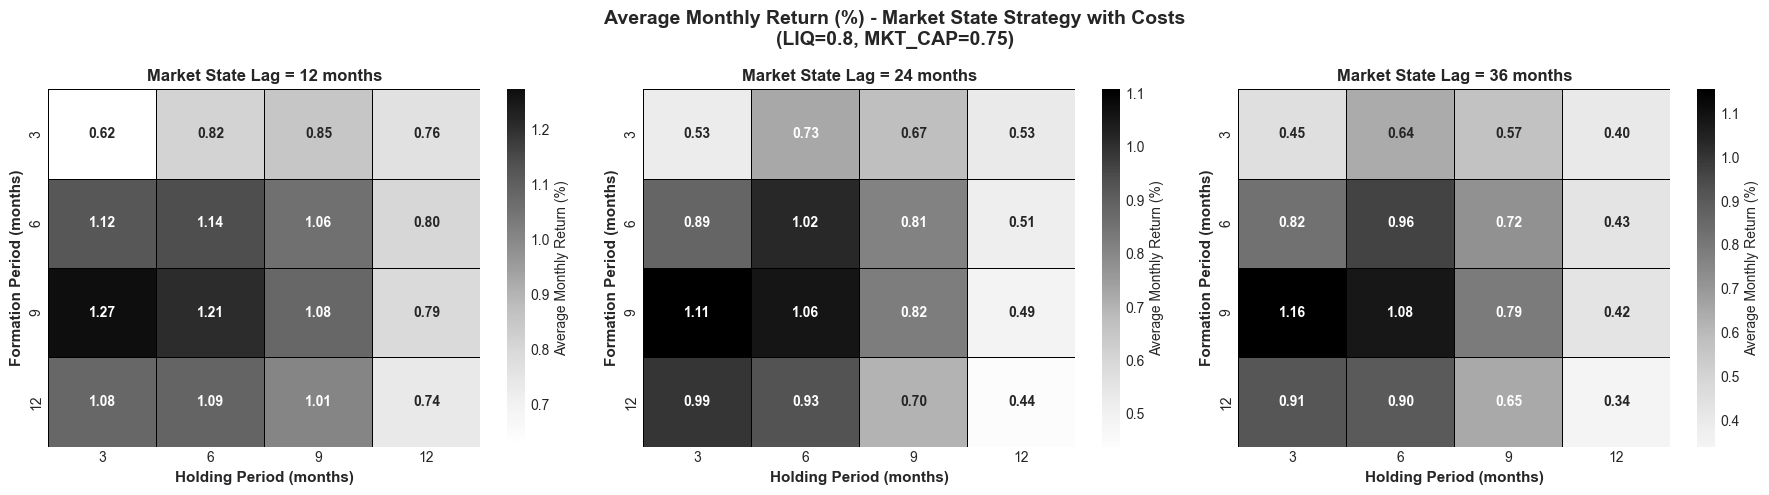

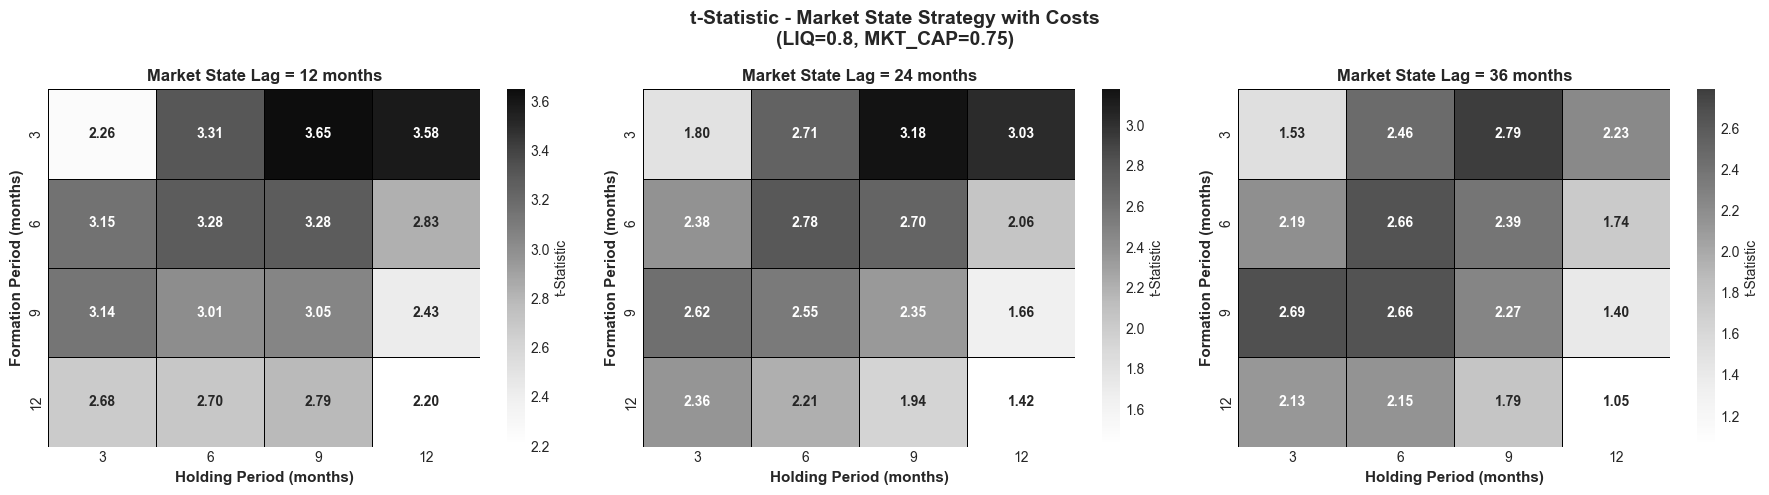

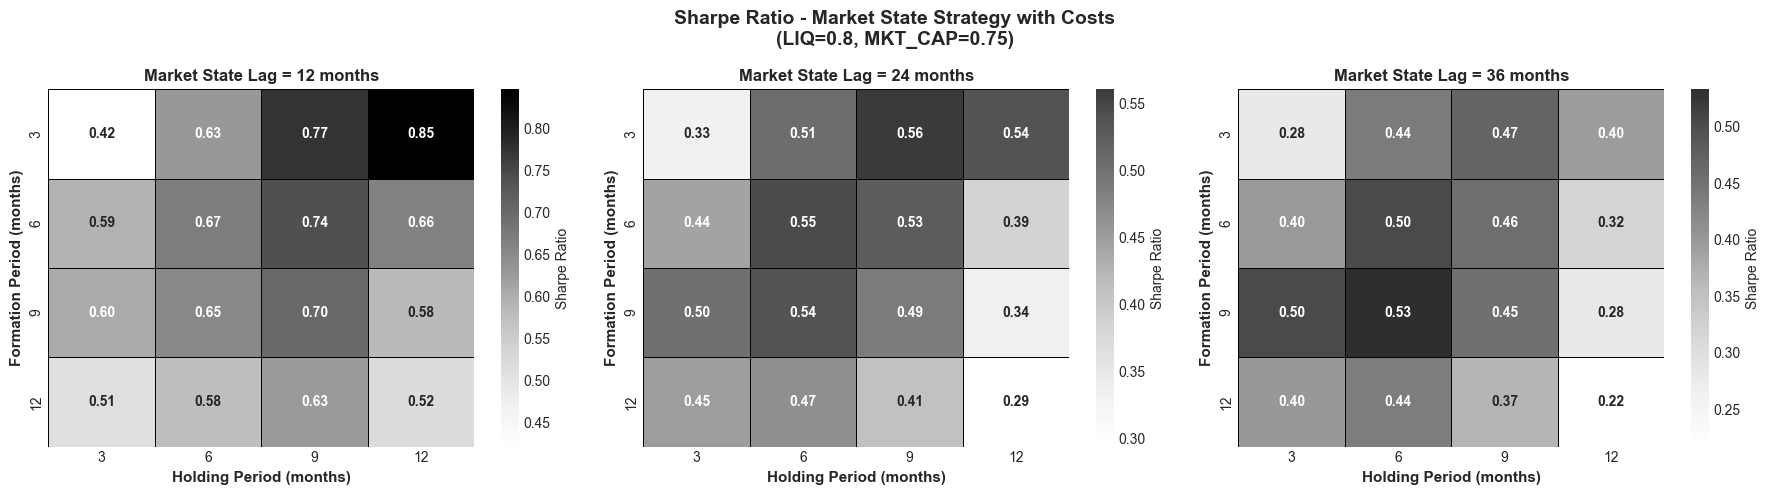

✓ Comprehensive table saved for lag 12 months
✓ Comprehensive table saved for lag 24 months
✓ Comprehensive table saved for lag 36 months


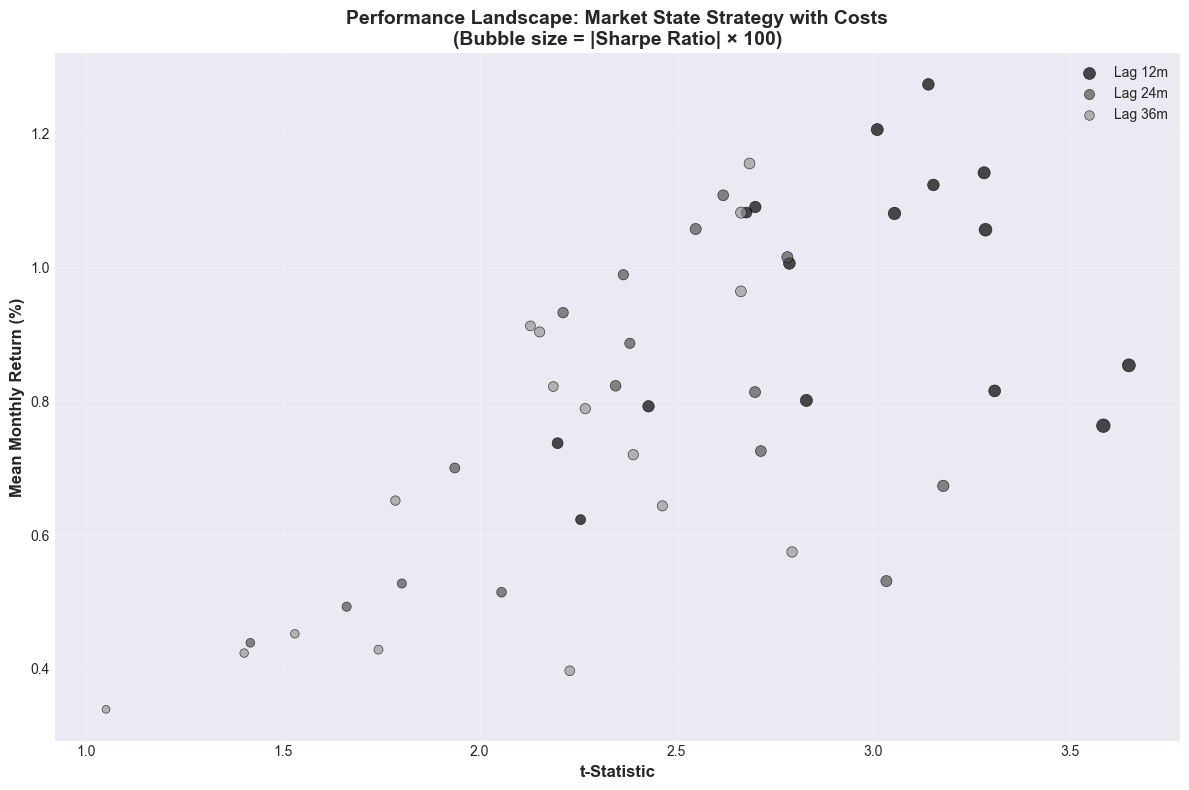


✓ Results saved for 3 market state lags
✓ Grayscale heatmaps exported successfully
✓ Comprehensive LaTeX tables with transaction costs created
✓ Best combinations summary table generated
✓ Performance landscape plot created

Best Parameter Combinations (LIQ=0.8, MKT_CAP=0.75):
 Lag  Formation  Holding      Criterion Mean Return t-Statistic Sharpe Ratio
  12          9        3 Highest Return      1.27\%       3.139        0.605
  12          3        9 Highest t-stat      0.85\%       3.649        0.775
  12          3       12 Highest Sharpe      0.76\%       3.584        0.847
  24          9        3 Highest Return      1.11\%       2.618        0.502
  24          3        9 Highest t-stat      0.67\%       3.177        0.561
  24          3        9 Highest Sharpe      0.67\%       3.177        0.561
  36          9        3 Highest Return      1.16\%       2.685        0.504
  36          3        9 Highest t-stat      0.57\%       2.793        0.471
  36          9        6 Hig

In [37]:
"""
Analysis 7: Grid Search over Formation/Holding Periods and Market State Lags
Testing market state strategy WITH COSTS (RET_S3)
Parameters: LIQ_CUTOFF=0.8, MKT_CAP_CUTOFF=0.75
Academic formatting with grayscale plots and proper LaTeX tables
"""
print("\n" + "=" * 80)
print("ANALYSIS 4: PARAMETER GRID SEARCH - MARKET STATE STRATEGY WITH COSTS")
print("Parameters: LIQ_CUTOFF=0.8, MKT_CAP_CUTOFF=0.75")
print("=" * 80)

# Define parameter grids
lags_market_state = [12, 24, 36]
formation_period_values = [3, 6, 9, 12]
holding_period_values = [3, 6, 9, 12]

# Fixed parameters for the strategy
LIQ_CUTOFF = 0.8
MKT_CAP_CUTOFF = 0.75

# ------------------------------------------------------------------------
# OPTIMIZED ANALYSIS FUNCTION
# ------------------------------------------------------------------------
def analyze_strategy_with_costs(portfolio, state_map, return_column='RET_S3', K=3):
    """
    Analyze the market state strategy with transaction costs.
    Uses the same efficient approach as the original analysis functions.
    """
    if len(portfolio) == 0:
        return None
    
    # Filter to the analysis period
    portfolio_filtered = portfolio[
        (portfolio['date'] >= '1993-01-01') & 
        (portfolio['date'] <= '2024-12-31')
    ].copy()
    
    if len(portfolio_filtered) == 0:
        return None
    
    # Calculate cohort returns efficiently
    cohort_ret = (portfolio_filtered.groupby(['date', 'momr', 'form_date'], sort=False)[return_column]
                 .mean()
                 .groupby(['date', 'momr'], sort=False)
                 .mean()
                 .reset_index())
    
    # Pivot to get decile returns
    decile_pivot = cohort_ret.pivot(index='date', columns='momr', values=return_column)
    
    # Check if we have the required deciles
    if 1 not in decile_pivot.columns or 10 not in decile_pivot.columns:
        return None
    
    # Calculate long-short strategy returns
    long_short = decile_pivot[10] - decile_pivot[1]  # winners - losers
    
    # Filter out missing values
    long_short = long_short.dropna()
    
    if len(long_short) == 0:
        return None
    
    # Calculate statistics
    mean_ret = long_short.mean() * 100  # Convert to percentage
    std_ret = long_short.std()
    sharpe = (long_short.mean() / std_ret) * np.sqrt(12) if std_ret > 0 else 0
    
    # Calculate t-statistic using HAC standard errors
    ones = np.ones(len(long_short))
    try:
        ols = sm.OLS(long_short.values, ones).fit(
            cov_type='HAC', 
            cov_kwds={'maxlags': K-1}
        )
        t_stat = ols.tvalues[0]
        p_value = ols.pvalues[0]
    except:
        t_stat = 0
        p_value = 1
    
    return {
        'mean_return': mean_ret,
        't_stat': t_stat,
        'sharpe': sharpe,
        'p_value': p_value,
        'n_observations': len(long_short)
    }

print("\n[1/3] Executing grid search with transaction costs...")

# Dictionary to store results
results_by_market_state = {}

for lag in lags_market_state:
    print(f"\nProcessing Market State Lag = {lag} months")
    
    temp_results = {}
    
    for J in formation_period_values:
        for K in holding_period_values:
            print(f"J={J}, K={K}: ", end="", flush=True)
            
            try:
                # Run the momentum strategy with costs using the new direct parameter approach
                portfolio, state_map = run_momentum_strategy(
                    crsp_stock_data, 
                    crsp_index_data, 
                    comm_map,
                    J=J, 
                    K=K, 
                    LIQ_CUTOFF=LIQ_CUTOFF,
                    MKT_CAP_CUTOFF=MKT_CAP_CUTOFF,
                    market_state_lag=lag,  # Direct parameter - much cleaner!
                    market_state_column='vwretd',
                    transactional_framework=True,
                    equal_comparision=False
                )
                
                # Analyze the strategy with costs (RET_S3)
                analysis = analyze_strategy_with_costs(portfolio, state_map, 'RET_S3', K)
                
                if analysis is not None:
                    temp_results[(J, K)] = analysis
                    print(f"✓ {analysis['mean_return']:.3f}%, t={analysis['t_stat']:.2f}")
                else:
                    print("✗ No results")
                    
            except Exception as e:
                print(f"✗ Error: {str(e)[:30]}...")
                continue
    
    # Convert to DataFrame and store
    if temp_results:
        results_df = pd.DataFrame(temp_results).T.rename_axis(['Formation', 'Holding'])
        results_by_market_state[lag] = results_df
        
        print(f"\nSummary for Market State Lag = {lag}:")
        print(results_df[['mean_return', 't_stat', 'sharpe']].round(3))
    else:
        print(f"\nNo valid results for Market State Lag = {lag}")

print("\n[2/3] Grid search execution complete!")

# ============================================================================
# VISUALIZATION AND EXPORT (GRAYSCALE ACADEMIC FORMAT)
# ============================================================================

def format_percentage_latex(value):
    """Format percentage values for LaTeX with proper escaping"""
    return f"{value:.2f}\\%"

def format_scientific_latex(value):
    """Format scientific notation for LaTeX"""
    if value < 0.001:
        return f"{value:.2e}".replace('e-0', ' \\times 10^{-').replace('e-', ' \\times 10^{-') + '}'
    else:
        return f"{value:.4f}"

print("\n[3/3] Creating visualizations and tables...")

if results_by_market_state:
    # Create grayscale heatmaps for each metric
    metrics = ['mean_return', 't_stat', 'sharpe']
    metric_names = ['Average Monthly Return (%)', 't-Statistic', 'Sharpe Ratio']
    
    for metric, metric_name in zip(metrics, metric_names):
        fig, axes = plt.subplots(1, len(results_by_market_state), 
                                figsize=(6*len(results_by_market_state), 5))
        
        # Handle case where there's only one subplot
        if len(results_by_market_state) == 1:
            axes = [axes]
        elif len(results_by_market_state) == 0:
            continue
            
        for idx, (lag, df) in enumerate(results_by_market_state.items()):
            # Pivot for heatmap
            pivot_data = df[metric].unstack()
            
            # Create grayscale heatmap
            im = sns.heatmap(pivot_data, annot=True, fmt='.2f', 
                           cmap='Greys', center=pivot_data.values.mean(), 
                           ax=axes[idx], 
                           cbar_kws={'label': metric_name},
                           linewidths=0.5, linecolor='black',
                           annot_kws={'fontsize': 10, 'fontweight': 'bold'})
            
            axes[idx].set_title(f'Market State Lag = {lag} months', 
                              fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Holding Period (months)', 
                               fontsize=11, fontweight='bold')
            axes[idx].set_ylabel('Formation Period (months)', 
                               fontsize=11, fontweight='bold')
            
            # Customize tick labels
            axes[idx].tick_params(axis='both', which='major', labelsize=10)
        
        plt.suptitle(f'{metric_name} - Market State Strategy with Costs\n(LIQ={LIQ_CUTOFF}, MKT_CAP={MKT_CAP_CUTOFF})', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'results/plots/grid_search_costs_{metric}_academic.png', 
                   dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
    
    # ========================================================================
    # COMPREHENSIVE LATEX TABLES
    # ========================================================================
    
    for lag, df in results_by_market_state.items():
        # Create comprehensive table with all metrics
        comprehensive_table = []
        
        for (formation, holding), row in df.iterrows():
            comprehensive_table.append({
                'Formation (J)': f"{formation}",
                'Holding (K)': f"{holding}",
                'Mean Return': format_percentage_latex(row['mean_return']),
                't-Statistic': f"{row['t_stat']:.3f}",
                'Sharpe Ratio': f"{row['sharpe']:.3f}",
                'p-value': format_scientific_latex(row['p_value']),
                'N Obs': f"{int(row['n_observations']):,}"
            })
        
        comp_df = pd.DataFrame(comprehensive_table)
        
        # Save comprehensive CSV
        comp_df.to_csv(f'results/tables/grid_search_costs_comprehensive_lag{lag}.csv', index=False)
        
        # Create LaTeX table with proper formatting
        latex_output = comp_df.to_latex(
            index=False,
            escape=False,
            column_format='cc|ccccc',
            caption=f'Grid Search Results - Market State Strategy with Costs (Lag = {lag} months, LIQ = {LIQ_CUTOFF}, MKT\\_CAP = {MKT_CAP_CUTOFF})',
            label=f'tab:grid_search_costs_lag{lag}',
            position='htbp'
        )
        
        # Enhance LaTeX formatting
        latex_output = latex_output.replace('\\toprule', '\\hline')
        latex_output = latex_output.replace('\\midrule', '\\cline{3-7}') 
        latex_output = latex_output.replace('\\bottomrule', '\\hline')
        
        # Add bold headers
        lines = latex_output.split('\n')
        enhanced_lines = []
        
        for line in lines:
            if 'Formation (J)' in line:
                line = line.replace('Formation (J)', '\\textbf{Formation (J)}')
                line = line.replace('Holding (K)', '\\textbf{Holding (K)}')
                line = line.replace('Mean Return', '\\textbf{Mean Return}')
                line = line.replace('t-Statistic', '\\textbf{t-Statistic}')
                line = line.replace('Sharpe Ratio', '\\textbf{Sharpe Ratio}')
                line = line.replace('p-value', '\\textbf{p-value}')
                line = line.replace('N Obs', '\\textbf{N Obs}')
            enhanced_lines.append(line)
        
        latex_output = '\n'.join(enhanced_lines)
        
        # Save enhanced LaTeX table
        with open(f'results/tables/grid_search_costs_comprehensive_lag{lag}.tex', 'w') as f:
            f.write(latex_output)
        
        print(f"✓ Comprehensive table saved for lag {lag} months")
    
    # ========================================================================
    # SUMMARY TABLE: BEST PERFORMING COMBINATIONS
    # ========================================================================
    
    # Find best combinations across all lags
    best_combinations = []
    
    for lag, df in results_by_market_state.items():
        if df.empty:
            continue
            
        # Check if we have valid data for each metric
        valid_return = df['mean_return'].dropna()
        valid_tstat = df['t_stat'].dropna()
        valid_sharpe = df['sharpe'].dropna()
        
        if not valid_return.empty:
            best_return_idx = valid_return.idxmax()
            best_return = df.loc[best_return_idx]
            
            best_combinations.append({
                'Lag': lag,
                'Formation': best_return_idx[0],
                'Holding': best_return_idx[1],
                'Criterion': 'Highest Return',
                'Mean Return': format_percentage_latex(best_return['mean_return']),
                't-Statistic': f"{best_return['t_stat']:.3f}",
                'Sharpe Ratio': f"{best_return['sharpe']:.3f}"
            })
        
        if not valid_tstat.empty:
            best_tstat_idx = valid_tstat.idxmax()
            best_tstat = df.loc[best_tstat_idx]
            
            best_combinations.append({
                'Lag': lag,
                'Formation': best_tstat_idx[0],
                'Holding': best_tstat_idx[1],
                'Criterion': 'Highest t-stat',
                'Mean Return': format_percentage_latex(best_tstat['mean_return']),
                't-Statistic': f"{best_tstat['t_stat']:.3f}",
                'Sharpe Ratio': f"{best_tstat['sharpe']:.3f}"
            })
        
        if not valid_sharpe.empty:
            best_sharpe_idx = valid_sharpe.idxmax()
            best_sharpe = df.loc[best_sharpe_idx]
            
            best_combinations.append({
                'Lag': lag,
                'Formation': best_sharpe_idx[0],
                'Holding': best_sharpe_idx[1],
                'Criterion': 'Highest Sharpe',
                'Mean Return': format_percentage_latex(best_sharpe['mean_return']),
                't-Statistic': f"{best_sharpe['t_stat']:.3f}",
                'Sharpe Ratio': f"{best_sharpe['sharpe']:.3f}"
            })
    
    if best_combinations:
        best_df = pd.DataFrame(best_combinations)
        
        # Save summary table
        best_df.to_csv('results/tables/grid_search_costs_best_combinations.csv', index=False)
        
        # Create LaTeX summary table
        summary_latex = best_df.to_latex(
            index=False,
            escape=False,
            column_format='ccc|ccc',
            caption=f'Best Parameter Combinations - Market State Strategy with Costs (LIQ = {LIQ_CUTOFF}, MKT\\_CAP = {MKT_CAP_CUTOFF})',
            label='tab:best_combinations_costs',
            position='htbp'
        )
        
        # Enhance summary table formatting
        summary_latex = summary_latex.replace('\\toprule', '\\hline')
        summary_latex = summary_latex.replace('\\midrule', '\\hline')
        summary_latex = summary_latex.replace('\\bottomrule', '\\hline')
        
        with open('results/tables/grid_search_costs_best_combinations.tex', 'w') as f:
            f.write(summary_latex)
    else:
        print("No valid combinations found for best results summary")
        best_df = pd.DataFrame()  # Create empty DataFrame for later use
    
    # ========================================================================
    # PERFORMANCE COMPARISON PLOT - WITH ERROR HANDLING
    # ========================================================================
    
    # Create a comparison plot showing the best combinations
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Extract data for plotting
    plot_data = []
    for lag, df in results_by_market_state.items():
        for (formation, holding), row in df.iterrows():
            plot_data.append({
                'Lag': lag,
                'Formation': formation,
                'Holding': holding,
                'Mean Return': row['mean_return'],
                't-Statistic': row['t_stat'],
                'Sharpe': row['sharpe']
            })
    
    if plot_data:  # Only create plot if we have data
        plot_df = pd.DataFrame(plot_data)
        
        # Remove any rows with NaN values that could cause plotting issues
        plot_df = plot_df.dropna(subset=['Mean Return', 't-Statistic', 'Sharpe'])
        
        if not plot_df.empty:
            # Create scatter plot: t-stat vs mean return, sized by Sharpe ratio
            colors = ['#000000', '#555555', '#999999']  # Grayscale colors for different lags
            
            for i, lag in enumerate(lags_market_state):
                lag_data = plot_df[plot_df['Lag'] == lag]
                if not lag_data.empty:
                    # Ensure we have valid data for scatter plot
                    valid_mask = lag_data[['t-Statistic', 'Mean Return', 'Sharpe']].notna().all(axis=1)
                    lag_data_valid = lag_data[valid_mask]
                    
                    if not lag_data_valid.empty:
                        ax.scatter(lag_data_valid['t-Statistic'], lag_data_valid['Mean Return'], 
                                  s=np.abs(lag_data_valid['Sharpe'])*100 + 10,  # Ensure positive size
                                  alpha=0.7, 
                                  label=f'Lag {lag}m', 
                                  edgecolors='black', 
                                  linewidth=0.5,
                                  color=colors[i % len(colors)])
            
            ax.set_xlabel('t-Statistic', fontsize=12, fontweight='bold')
            ax.set_ylabel('Mean Monthly Return (%)', fontsize=12, fontweight='bold')
            ax.set_title('Performance Landscape: Market State Strategy with Costs\n(Bubble size = |Sharpe Ratio| × 100)', 
                        fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            
            # Only add legend if we have data points
            if ax.collections:  # Check if any scatter points were actually plotted
                ax.legend(fontsize=10)
            
            plt.tight_layout()
            plt.savefig('results/plots/grid_search_costs_performance_landscape.png', 
                       dpi=300, bbox_inches='tight', facecolor='white')
            plt.show()
        else:
            print("No valid data for performance landscape plot")
    else:
        print("No data available for performance landscape plot")
    
    print(f"\n✓ Results saved for {len(results_by_market_state)} market state lags")
    print("✓ Grayscale heatmaps exported successfully")
    print("✓ Comprehensive LaTeX tables with transaction costs created")
    print("✓ Best combinations summary table generated")
    print("✓ Performance landscape plot created")
    
    # Display best combinations
    if not best_df.empty:
        print(f"\nBest Parameter Combinations (LIQ={LIQ_CUTOFF}, MKT_CAP={MKT_CAP_CUTOFF}):")
        print(best_df.to_string(index=False))
    else:
        print(f"\nNo valid parameter combinations found (LIQ={LIQ_CUTOFF}, MKT_CAP={MKT_CAP_CUTOFF})")
    
    # Display overall summary statistics
    print(f"\nOverall Summary:")
    print(f"Total parameter combinations tested: {sum(len(df) for df in results_by_market_state.values())}")
    
    # Only show summary if we have valid data
    if plot_data and not pd.DataFrame(plot_data).empty:
        plot_df = pd.DataFrame(plot_data).dropna(subset=['Mean Return', 't-Statistic', 'Sharpe'])
        if not plot_df.empty:
            print(f"Best overall mean return: {plot_df['Mean Return'].max():.3f}%")
            print(f"Best overall t-statistic: {plot_df['t-Statistic'].max():.3f}")
            print(f"Best overall Sharpe ratio: {plot_df['Sharpe'].max():.3f}")
        else:
            print("No valid results to summarize")
    else:
        print("No valid results to summarize")
    
else:
    print("\n⚠ Warning: No valid results generated. Check data and parameters.")

print("\n" + "=" * 80)
print("GRID SEARCH ANALYSIS WITH TRANSACTION COSTS COMPLETE")
print("Files created:")
print("- results/plots/grid_search_costs_{metric}_academic.png (for each metric)")
print("- results/plots/grid_search_costs_performance_landscape.png")
print("- results/tables/grid_search_costs_comprehensive_lag{lag}.csv (for each lag)")
print("- results/tables/grid_search_costs_comprehensive_lag{lag}.tex (for each lag)")
print("- results/tables/grid_search_costs_best_combinations.csv")
print("- results/tables/grid_search_costs_best_combinations.tex")
print("=" * 80)